In [1]:
import tensorflow as tf
from keras.models import Model
from keras.optimizers import Adam
from keras import layers, callbacks

from keras.utils import to_categorical

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import numpy as np

from tensorflow.python.keras.utils.vis_utils import plot_model
import pydot

from scipy.stats import norm
from scipy import stats
import os

from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
import dataframe_image as dfi
import pickle
import math

2023-05-19 10:58:52.734727: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-19 10:58:52.761711: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
channel_width = 79
nr_classes = 3

using_weights = True

#### Save parameters

In [3]:
name = 'Test' #name of model - should be descriptive
save_folder = 'singleScan_Test_lesscrazy' #hyperparameter description her
if using_weights == True:
    save_folder = save_folder + '_W'
    name = name + '_weighted'

### Gotta load in some data

In [4]:
datapath = 'All_data/'
labelpath = 'All_labels/'
data_list = os.listdir(datapath)
#print(data_list)

#all_data = [] #if we want to have data and labels in one list
complete_data = []
complete_labels = []

total_channels = 79
total_scans_pr_sample = 1


for csv_file in data_list:
    data_file = datapath + csv_file
    current_data_file = pd.read_csv(data_file,header=None)

    label_file = labelpath + csv_file
    label_file = label_file.replace('.csv', '_labels.csv')
    current_label_file = pd.read_csv(label_file,header=None)

    for data_iter in range(len(current_data_file.index)):
        #Pulling out the data from a row and putting it in the list
        current_data_point = np.array(current_data_file.iloc[data_iter])
        #current_data_point = current_data_point.reshape(total_scans_pr_sample,total_channels)
        complete_data.append(current_data_point)
        
        #adding the label to the datamatrix as the last row
        label_row = np.array(current_label_file.iloc[data_iter])
        #label_row = label_row.reshape(1,total_channels)
        complete_labels.append(label_row)
        
        #all_data.append(np.vstack([current_data_point, label_row])) #if we want to have data and labels in one list


In [5]:
print(complete_labels[1].shape)
print(complete_data[1].shape)
print(len(complete_labels))
print(len(complete_data))

(79,)
(79,)
290700
290700


### Print some random samples to check validity

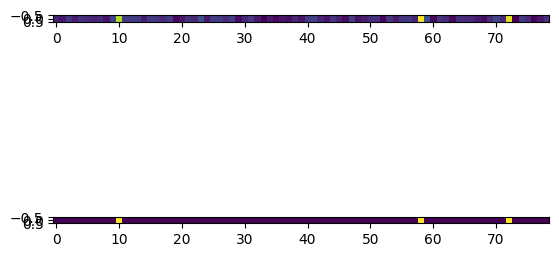

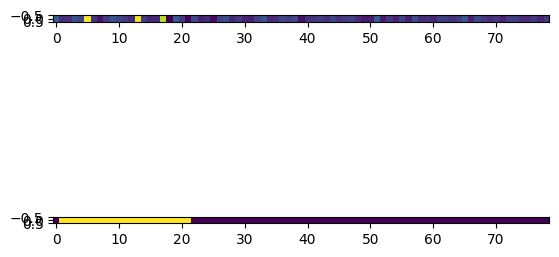

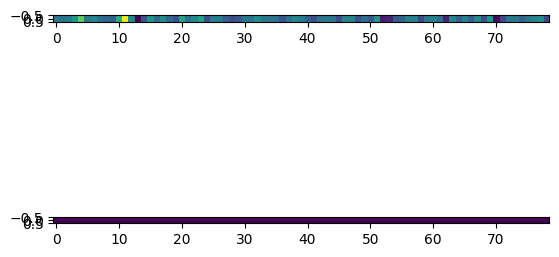

In [6]:
import random
listNumbers = random.sample(range(len(complete_labels)), 3)

for af in listNumbers:
    a = np.copy(complete_data[af])
    a = np.reshape(a, (1, channel_width))
    figure, axis = plt.subplots(2,1)
    axis[0].imshow(a)
    a = np.copy(complete_labels[af])
    a = np.reshape(a, (1, channel_width))
    axis[1].imshow(a)
    plt.show()



### Splits data in train and test

In [7]:
data_train, data_test, labels_train, labels_test = train_test_split(complete_data, complete_labels, train_size=0.8, random_state=112)

# One hot encoding
#labels_test = to_categorical(labels_test)
#labels_train = to_categorical(labels_train)

data_train = np.array(data_train)
data_test = np.array(data_test)
labels_train = np.array(labels_train)
labels_test = np.array(labels_test)
print(labels_test.shape)

(58140, 79)


In [8]:
def weighted_mean_squared_error(class_weight):
  def loss(y_true, y_pred):
          y_true = tf.dtypes.cast(y_true, tf.float32)
          y_pred = tf.dtypes.cast(y_pred, tf.float32)
#             y_pred=  tf.transpose(y_pred, perm=[1, 0,2])

          
          weight = tf.constant(class_weight, dtype=tf.float32)
          weight_per_sample = tf.transpose(tf.gather(weight, tf.argmax(y_true, axis=-1)))
          weight_per_sample = tf.expand_dims(weight_per_sample, axis=-1)
#             losses = tf.keras.losses.mean_squared_error(y_true, y_pred)
          losses = tf.math.square(y_true-y_pred)*weight_per_sample
          return tf.reduce_mean(losses, axis=-1)
  return loss

### Normalise data a bit

In [9]:
# Make a scaler from training data
test = data_train[0]

#reshape to 1d features
""" nr_data_train = data_train.shape[0]
data_train = data_train.reshape(nr_data_train, channel_width)
nr_data_test = data_test.shape[0]
data_test = data_test.reshape(nr_data_test, channel_width) """

scaler = preprocessing.StandardScaler().fit(data_train)

# scale everything using that scaler
data_train = scaler.transform(data_train)
data_test = scaler.transform(data_test)

#reshaping back to 2d features
""" data_train = data_train.reshape(nr_data_train, channel_width)
data_test = data_test.reshape(nr_data_test, channel_width) """

' data_train = data_train.reshape(nr_data_train, channel_width)\ndata_test = data_test.reshape(nr_data_test, channel_width) '

In [10]:
#fix shape
#labels_test = labels_test.reshape(nr_data_test,channel_width)
#labels_train = labels_train.reshape(nr_data_train,channel_width)
print(labels_test.shape)
print(labels_train.shape)
print(data_test.shape)
#print(labels_test[1])

(58140, 79)
(232560, 79)
(58140, 79)


In [11]:
labels_test = to_categorical(labels_test)
labels_train = to_categorical(labels_train)
print(labels_test.shape)
#print(labels_test.reshape(920,3,79).shape)
#print(labels_test[1])

(58140, 79, 3)


#### Adding class weights 
Will only be used if weights is set to true in the top

In [12]:
#class_weights = [1.0, 4.5, 36.0] #crazy
class_weights = [1.0, 5.0, 10.0]
class_weights = np.array([class_weights[i] for i in range(len(class_weights))])

## Building a model

In [13]:
signal_size = 1

sf = 6
y = layers.Input(shape=(channel_width,1), dtype='float32', name='Input')
x = layers.Conv1D(sf, 3, padding='same', activation='relu', use_bias=True)(y)
x = layers.Conv1D(sf, 3, padding='same', activation='relu')(x)
#x = layers.Conv1D(sf, 3, padding='same', activation='relu')(x)
x = layers.MaxPool1D(pool_size=2,strides=2)(x)
x = layers.Conv1D(sf*2, 3, padding='same', activation='relu')(x)
x = layers.Conv1D(sf*2, 3, padding='same', activation='relu')(x)
#x = layers.Conv1D(sf*2, 3, padding='same', activation='relu')(x)
x = layers.MaxPool1D(pool_size=2,strides=2)(x)
x = layers.Conv1D(sf*4, 3, padding='same', activation='relu')(x)
x = layers.Conv1D(sf*4, 3, padding='same', activation='relu')(x)
#x = layers.Conv1D(sf*4, 3, padding='same', activation='relu')(x)
x = layers.MaxPool1D(pool_size=2,strides=2)(x)
x = layers.Conv1D(sf*8, 3, padding='same', activation='relu')(x)
x = layers.Conv1D(sf*8, 3, padding='same', activation='relu')(x)
#x = layers.Conv1D(sf*8, 3, padding='same', activation='relu')(x)
x = layers.MaxPool1D(pool_size=2,strides=2)(x)
x = layers.Flatten()(x)


class_layer = [{}]*channel_width
output_layer = [{}]*channel_width
for iter in range(channel_width):
    class_layer[iter] = layers.Dropout(rate=0.3)(x)
    class_layer[iter] = layers.Dense(sf,activation='relu')(class_layer[iter])
    class_layer[iter] = layers.Dropout(rate=0.3)(class_layer[iter])
    #class_layer[iter] = layers.Dense(64,activation='relu')(class_layer[iter])
    output_layer[iter] = layers.Dense(nr_classes, activation='softmax', name=('out'+str(iter)))(class_layer[iter])



model = Model(inputs=[y], outputs=[out_layer for out_layer in output_layer])
model.summary()

2023-05-19 10:59:30.551406: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-19 10:59:30.554429: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-05-19 10:59:30.554521: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input (InputLayer)             [(None, 79, 1)]      0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 79, 6)        24          ['Input[0][0]']                  
                                                                                                  
 conv1d_1 (Conv1D)              (None, 79, 6)        114         ['conv1d[0][0]']                 
                                                                                                  
 max_pooling1d (MaxPooling1D)   (None, 39, 6)        0           ['conv1d_1[0][0]']               
                                                                                              

 dropout_52 (Dropout)           (None, 192)          0           ['flatten[0][0]']                
                                                                                                  
 dropout_54 (Dropout)           (None, 192)          0           ['flatten[0][0]']                
                                                                                                  
 dropout_56 (Dropout)           (None, 192)          0           ['flatten[0][0]']                
                                                                                                  
 dropout_58 (Dropout)           (None, 192)          0           ['flatten[0][0]']                
                                                                                                  
 dropout_60 (Dropout)           (None, 192)          0           ['flatten[0][0]']                
                                                                                                  
 dropout_6

                                                                                                  
 dropout_136 (Dropout)          (None, 192)          0           ['flatten[0][0]']                
                                                                                                  
 dropout_138 (Dropout)          (None, 192)          0           ['flatten[0][0]']                
                                                                                                  
 dropout_140 (Dropout)          (None, 192)          0           ['flatten[0][0]']                
                                                                                                  
 dropout_142 (Dropout)          (None, 192)          0           ['flatten[0][0]']                
                                                                                                  
 dropout_144 (Dropout)          (None, 192)          0           ['flatten[0][0]']                
          

 dense_30 (Dense)               (None, 6)            1158        ['dropout_60[0][0]']             
                                                                                                  
 dense_31 (Dense)               (None, 6)            1158        ['dropout_62[0][0]']             
                                                                                                  
 dense_32 (Dense)               (None, 6)            1158        ['dropout_64[0][0]']             
                                                                                                  
 dense_33 (Dense)               (None, 6)            1158        ['dropout_66[0][0]']             
                                                                                                  
 dense_34 (Dense)               (None, 6)            1158        ['dropout_68[0][0]']             
                                                                                                  
 dense_35 

                                                                                                  
 dense_72 (Dense)               (None, 6)            1158        ['dropout_144[0][0]']            
                                                                                                  
 dense_73 (Dense)               (None, 6)            1158        ['dropout_146[0][0]']            
                                                                                                  
 dense_74 (Dense)               (None, 6)            1158        ['dropout_148[0][0]']            
                                                                                                  
 dense_75 (Dense)               (None, 6)            1158        ['dropout_150[0][0]']            
                                                                                                  
 dense_76 (Dense)               (None, 6)            1158        ['dropout_152[0][0]']            
          

 dropout_69 (Dropout)           (None, 6)            0           ['dense_34[0][0]']               
                                                                                                  
 dropout_71 (Dropout)           (None, 6)            0           ['dense_35[0][0]']               
                                                                                                  
 dropout_73 (Dropout)           (None, 6)            0           ['dense_36[0][0]']               
                                                                                                  
 dropout_75 (Dropout)           (None, 6)            0           ['dense_37[0][0]']               
                                                                                                  
 dropout_77 (Dropout)           (None, 6)            0           ['dense_38[0][0]']               
                                                                                                  
 dropout_7

                                                                                                  
 dropout_153 (Dropout)          (None, 6)            0           ['dense_76[0][0]']               
                                                                                                  
 dropout_155 (Dropout)          (None, 6)            0           ['dense_77[0][0]']               
                                                                                                  
 dropout_157 (Dropout)          (None, 6)            0           ['dense_78[0][0]']               
                                                                                                  
 out0 (Dense)                   (None, 3)            21          ['dropout_1[0][0]']              
                                                                                                  
 out1 (Dense)                   (None, 3)            21          ['dropout_3[0][0]']              
          

 out38 (Dense)                  (None, 3)            21          ['dropout_77[0][0]']             
                                                                                                  
 out39 (Dense)                  (None, 3)            21          ['dropout_79[0][0]']             
                                                                                                  
 out40 (Dense)                  (None, 3)            21          ['dropout_81[0][0]']             
                                                                                                  
 out41 (Dense)                  (None, 3)            21          ['dropout_83[0][0]']             
                                                                                                  
 out42 (Dense)                  (None, 3)            21          ['dropout_85[0][0]']             
                                                                                                  
 out43 (De

Total params: 107,055
Trainable params: 107,055
Non-trainable params: 0
__________________________________________________________________________________________________


In [14]:
# ------------- model compilation --------------
ourAdam = Adam()
optimizer = tf.keras.optimizers.RMSprop()

if using_weights == True:
        loss_func = weighted_mean_squared_error(class_weights)
else:
        #loss_func = 'mse'
        loss_func = 'categorical_crossentropy'

metric_T = 'accuracy'
loss_dict = {}
metric_dict = {}
for iter in range(channel_width):
        loss_dict['out'+str(iter)] = loss_func
        metric_dict['out'+str(iter)] = metric_T



model.compile(optimizer=ourAdam, loss = loss_dict,
              metrics=metric_T) 
                     


In [15]:
#uncomment to load pretrained model
# from tensorflow import keras
# model = keras.models.load_model('bignet')

In [16]:
# Set the model training parameters
# Stop model training when the training loss is not dropped
callbacks_list = [callbacks.EarlyStopping(
                        monitor='val_loss', 
                        patience=5, 
                        verbose=0, 
                        mode='auto',
                        restore_best_weights=True,
                    )
                            ]

# ------------- Starting model Training --------------
BATCH_SIZE = 4096
EPOCH = 300


hist = model.fit(data_train,[labels_train[:,iter,:] for iter in range(channel_width)],
          batch_size = BATCH_SIZE, 
          epochs = EPOCH, 
          callbacks= callbacks_list,
          validation_split=0.25)


Epoch 1/300


2023-05-19 10:59:50.649250: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-05-19 10:59:51.380032: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


43/43 [==============================] - 22s 168ms/step - loss: 31.3315 - out0_loss: 0.1657 - out1_loss: 0.2941 - out2_loss: 0.3068 - out3_loss: 0.2887 - out4_loss: 0.3063 - out5_loss: 0.2893 - out6_loss: 0.3698 - out7_loss: 0.3527 - out8_loss: 0.3744 - out9_loss: 0.3666 - out10_loss: 0.3740 - out11_loss: 0.4144 - out12_loss: 0.4180 - out13_loss: 0.4022 - out14_loss: 0.4167 - out15_loss: 0.4208 - out16_loss: 0.4455 - out17_loss: 0.4514 - out18_loss: 0.4471 - out19_loss: 0.4324 - out20_loss: 0.4458 - out21_loss: 0.4622 - out22_loss: 0.4423 - out23_loss: 0.4533 - out24_loss: 0.4539 - out25_loss: 0.4403 - out26_loss: 0.4828 - out27_loss: 0.4237 - out28_loss: 0.4520 - out29_loss: 0.4263 - out30_loss: 0.4619 - out31_loss: 0.4475 - out32_loss: 0.4573 - out33_loss: 0.4436 - out34_loss: 0.4454 - out35_loss: 0.4292 - out36_loss: 0.4536 - out37_loss: 0.4476 - out38_loss: 0.4692 - out39_loss: 0.4265 - out40_loss: 0.4427 - out41_loss: 0.4516 - out42_loss: 0.4418 - out43_loss: 0.4315 - out44_loss: 

 2/43 [>.............................] - ETA: 2s - loss: 29.1280 - out0_loss: 0.1097 - out1_loss: 0.2858 - out2_loss: 0.2985 - out3_loss: 0.2585 - out4_loss: 0.2935 - out5_loss: 0.2727 - out6_loss: 0.3529 - out7_loss: 0.3590 - out8_loss: 0.3548 - out9_loss: 0.3485 - out10_loss: 0.3628 - out11_loss: 0.3843 - out12_loss: 0.3801 - out13_loss: 0.3699 - out14_loss: 0.3808 - out15_loss: 0.4078 - out16_loss: 0.4275 - out17_loss: 0.4235 - out18_loss: 0.4290 - out19_loss: 0.4160 - out20_loss: 0.4192 - out21_loss: 0.4175 - out22_loss: 0.4179 - out23_loss: 0.3982 - out24_loss: 0.4157 - out25_loss: 0.3995 - out26_loss: 0.4452 - out27_loss: 0.3875 - out28_loss: 0.4162 - out29_loss: 0.3811 - out30_loss: 0.4499 - out31_loss: 0.4235 - out32_loss: 0.4331 - out33_loss: 0.4086 - out34_loss: 0.4392 - out35_loss: 0.4065 - out36_loss: 0.4468 - out37_loss: 0.4158 - out38_loss: 0.4607 - out39_loss: 0.3893 - out40_loss: 0.4090 - out41_loss: 0.4081 - out42_loss: 0.4191 - out43_loss: 0.3911 - out44_loss: 0.3941 

43/43 [==============================] - 3s 63ms/step - loss: 24.5357 - out0_loss: 0.1086 - out1_loss: 0.2611 - out2_loss: 0.2734 - out3_loss: 0.2397 - out4_loss: 0.2755 - out5_loss: 0.2438 - out6_loss: 0.3073 - out7_loss: 0.2884 - out8_loss: 0.2953 - out9_loss: 0.2760 - out10_loss: 0.3068 - out11_loss: 0.3611 - out12_loss: 0.2948 - out13_loss: 0.2968 - out14_loss: 0.3231 - out15_loss: 0.3632 - out16_loss: 0.3396 - out17_loss: 0.3454 - out18_loss: 0.3689 - out19_loss: 0.3554 - out20_loss: 0.3250 - out21_loss: 0.3106 - out22_loss: 0.3315 - out23_loss: 0.3409 - out24_loss: 0.3553 - out25_loss: 0.3352 - out26_loss: 0.3460 - out27_loss: 0.3055 - out28_loss: 0.3422 - out29_loss: 0.3191 - out30_loss: 0.3986 - out31_loss: 0.3809 - out32_loss: 0.3325 - out33_loss: 0.3386 - out34_loss: 0.3918 - out35_loss: 0.3358 - out36_loss: 0.3711 - out37_loss: 0.3561 - out38_loss: 0.4572 - out39_loss: 0.3181 - out40_loss: 0.3268 - out41_loss: 0.3476 - out42_loss: 0.3424 - out43_loss: 0.3072 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 20.7863 - out0_loss: 0.0945 - out1_loss: 0.2459 - out2_loss: 0.2512 - out3_loss: 0.2212 - out4_loss: 0.2539 - out5_loss: 0.2359 - out6_loss: 0.2709 - out7_loss: 0.2442 - out8_loss: 0.2671 - out9_loss: 0.2389 - out10_loss: 0.2480 - out11_loss: 0.3180 - out12_loss: 0.2516 - out13_loss: 0.2692 - out14_loss: 0.2850 - out15_loss: 0.3295 - out16_loss: 0.2725 - out17_loss: 0.2772 - out18_loss: 0.3097 - out19_loss: 0.2876 - out20_loss: 0.2658 - out21_loss: 0.2421 - out22_loss: 0.2832 - out23_loss: 0.2884 - out24_loss: 0.3102 - out25_loss: 0.2795 - out26_loss: 0.2849 - out27_loss: 0.2388 - out28_loss: 0.3080 - out29_loss: 0.2772 - out30_loss: 0.3519 - out31_loss: 0.3430 - out32_loss: 0.2709 - out33_loss: 0.3126 - out34_loss: 0.3342 - out35_loss: 0.2625 - out36_loss: 0.3217 - out37_loss: 0.2983 - out38_loss: 0.4296 - out39_loss: 0.2552 - out40_loss: 0.2814 - out41_loss: 0.2906 - out42_loss: 0.2903 - out43_loss: 0.2477 - out44_loss: 0.3186 

43/43 [==============================] - 3s 63ms/step - loss: 19.3602 - out0_loss: 0.1070 - out1_loss: 0.2267 - out2_loss: 0.2413 - out3_loss: 0.2034 - out4_loss: 0.2344 - out5_loss: 0.2079 - out6_loss: 0.2510 - out7_loss: 0.2295 - out8_loss: 0.2463 - out9_loss: 0.2176 - out10_loss: 0.2377 - out11_loss: 0.2838 - out12_loss: 0.2453 - out13_loss: 0.2453 - out14_loss: 0.2721 - out15_loss: 0.3292 - out16_loss: 0.2698 - out17_loss: 0.2591 - out18_loss: 0.2869 - out19_loss: 0.2586 - out20_loss: 0.2522 - out21_loss: 0.2327 - out22_loss: 0.2623 - out23_loss: 0.2796 - out24_loss: 0.2895 - out25_loss: 0.2773 - out26_loss: 0.2776 - out27_loss: 0.2292 - out28_loss: 0.2866 - out29_loss: 0.2492 - out30_loss: 0.3072 - out31_loss: 0.2987 - out32_loss: 0.2653 - out33_loss: 0.2727 - out34_loss: 0.2934 - out35_loss: 0.2504 - out36_loss: 0.3173 - out37_loss: 0.2772 - out38_loss: 0.3188 - out39_loss: 0.2476 - out40_loss: 0.2616 - out41_loss: 0.2652 - out42_loss: 0.2670 - out43_loss: 0.2329 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 18.2527 - out0_loss: 0.1155 - out1_loss: 0.2057 - out2_loss: 0.2308 - out3_loss: 0.1905 - out4_loss: 0.2166 - out5_loss: 0.1914 - out6_loss: 0.2366 - out7_loss: 0.2138 - out8_loss: 0.2408 - out9_loss: 0.2100 - out10_loss: 0.2310 - out11_loss: 0.2424 - out12_loss: 0.2311 - out13_loss: 0.2103 - out14_loss: 0.2598 - out15_loss: 0.3086 - out16_loss: 0.2513 - out17_loss: 0.2456 - out18_loss: 0.2775 - out19_loss: 0.2420 - out20_loss: 0.2371 - out21_loss: 0.2067 - out22_loss: 0.2261 - out23_loss: 0.2554 - out24_loss: 0.2613 - out25_loss: 0.2592 - out26_loss: 0.2658 - out27_loss: 0.2101 - out28_loss: 0.2651 - out29_loss: 0.2214 - out30_loss: 0.2653 - out31_loss: 0.2580 - out32_loss: 0.2576 - out33_loss: 0.2427 - out34_loss: 0.2758 - out35_loss: 0.2374 - out36_loss: 0.3124 - out37_loss: 0.2698 - out38_loss: 0.2799 - out39_loss: 0.2377 - out40_loss: 0.2578 - out41_loss: 0.2524 - out42_loss: 0.2656 - out43_loss: 0.2299 - out44_loss: 0.2851 

43/43 [==============================] - 3s 64ms/step - loss: 17.5025 - out0_loss: 0.1032 - out1_loss: 0.2070 - out2_loss: 0.2245 - out3_loss: 0.1887 - out4_loss: 0.2040 - out5_loss: 0.1838 - out6_loss: 0.2279 - out7_loss: 0.2127 - out8_loss: 0.2249 - out9_loss: 0.1984 - out10_loss: 0.2186 - out11_loss: 0.2285 - out12_loss: 0.2271 - out13_loss: 0.2159 - out14_loss: 0.2466 - out15_loss: 0.3151 - out16_loss: 0.2499 - out17_loss: 0.2289 - out18_loss: 0.2578 - out19_loss: 0.2301 - out20_loss: 0.2293 - out21_loss: 0.2099 - out22_loss: 0.2368 - out23_loss: 0.2590 - out24_loss: 0.2623 - out25_loss: 0.2589 - out26_loss: 0.2554 - out27_loss: 0.2088 - out28_loss: 0.2679 - out29_loss: 0.2287 - out30_loss: 0.2532 - out31_loss: 0.2475 - out32_loss: 0.2468 - out33_loss: 0.2319 - out34_loss: 0.2540 - out35_loss: 0.2260 - out36_loss: 0.2925 - out37_loss: 0.2570 - out38_loss: 0.2727 - out39_loss: 0.2215 - out40_loss: 0.2394 - out41_loss: 0.2352 - out42_loss: 0.2432 - out43_loss: 0.2152 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 16.8554 - out0_loss: 0.1137 - out1_loss: 0.1867 - out2_loss: 0.2227 - out3_loss: 0.1954 - out4_loss: 0.1950 - out5_loss: 0.1747 - out6_loss: 0.2114 - out7_loss: 0.2004 - out8_loss: 0.2073 - out9_loss: 0.1923 - out10_loss: 0.2069 - out11_loss: 0.2108 - out12_loss: 0.2264 - out13_loss: 0.2107 - out14_loss: 0.2424 - out15_loss: 0.3003 - out16_loss: 0.2470 - out17_loss: 0.2150 - out18_loss: 0.2567 - out19_loss: 0.2254 - out20_loss: 0.2320 - out21_loss: 0.2132 - out22_loss: 0.2183 - out23_loss: 0.2531 - out24_loss: 0.2503 - out25_loss: 0.2533 - out26_loss: 0.2481 - out27_loss: 0.2068 - out28_loss: 0.2482 - out29_loss: 0.2041 - out30_loss: 0.2214 - out31_loss: 0.2287 - out32_loss: 0.2366 - out33_loss: 0.2241 - out34_loss: 0.2355 - out35_loss: 0.2189 - out36_loss: 0.2907 - out37_loss: 0.2605 - out38_loss: 0.2677 - out39_loss: 0.2127 - out40_loss: 0.2293 - out41_loss: 0.2223 - out42_loss: 0.2387 - out43_loss: 0.2033 - out44_loss: 0.2699 

43/43 [==============================] - 3s 63ms/step - loss: 16.3127 - out0_loss: 0.1001 - out1_loss: 0.1931 - out2_loss: 0.2124 - out3_loss: 0.1767 - out4_loss: 0.1874 - out5_loss: 0.1670 - out6_loss: 0.2121 - out7_loss: 0.2001 - out8_loss: 0.2078 - out9_loss: 0.1844 - out10_loss: 0.2052 - out11_loss: 0.2141 - out12_loss: 0.2134 - out13_loss: 0.1999 - out14_loss: 0.2283 - out15_loss: 0.2972 - out16_loss: 0.2356 - out17_loss: 0.2120 - out18_loss: 0.2337 - out19_loss: 0.2174 - out20_loss: 0.2126 - out21_loss: 0.1936 - out22_loss: 0.2205 - out23_loss: 0.2462 - out24_loss: 0.2432 - out25_loss: 0.2436 - out26_loss: 0.2367 - out27_loss: 0.1941 - out28_loss: 0.2526 - out29_loss: 0.2124 - out30_loss: 0.2361 - out31_loss: 0.2299 - out32_loss: 0.2305 - out33_loss: 0.2172 - out34_loss: 0.2342 - out35_loss: 0.2103 - out36_loss: 0.2740 - out37_loss: 0.2413 - out38_loss: 0.2552 - out39_loss: 0.2049 - out40_loss: 0.2225 - out41_loss: 0.2173 - out42_loss: 0.2282 - out43_loss: 0.2006 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 15.8128 - out0_loss: 0.0958 - out1_loss: 0.1873 - out2_loss: 0.2141 - out3_loss: 0.1714 - out4_loss: 0.1808 - out5_loss: 0.1615 - out6_loss: 0.2101 - out7_loss: 0.1957 - out8_loss: 0.2083 - out9_loss: 0.1641 - out10_loss: 0.1926 - out11_loss: 0.2100 - out12_loss: 0.1959 - out13_loss: 0.1871 - out14_loss: 0.2084 - out15_loss: 0.2808 - out16_loss: 0.2336 - out17_loss: 0.2131 - out18_loss: 0.2291 - out19_loss: 0.2123 - out20_loss: 0.2111 - out21_loss: 0.1898 - out22_loss: 0.2065 - out23_loss: 0.2456 - out24_loss: 0.2345 - out25_loss: 0.2317 - out26_loss: 0.2408 - out27_loss: 0.1989 - out28_loss: 0.2541 - out29_loss: 0.2063 - out30_loss: 0.2273 - out31_loss: 0.2278 - out32_loss: 0.2236 - out33_loss: 0.1987 - out34_loss: 0.2239 - out35_loss: 0.2047 - out36_loss: 0.2615 - out37_loss: 0.2346 - out38_loss: 0.2356 - out39_loss: 0.1891 - out40_loss: 0.2043 - out41_loss: 0.2123 - out42_loss: 0.2323 - out43_loss: 0.1876 - out44_loss: 0.2597 

43/43 [==============================] - 3s 62ms/step - loss: 15.3493 - out0_loss: 0.0974 - out1_loss: 0.1845 - out2_loss: 0.2017 - out3_loss: 0.1657 - out4_loss: 0.1749 - out5_loss: 0.1531 - out6_loss: 0.2007 - out7_loss: 0.1876 - out8_loss: 0.1937 - out9_loss: 0.1712 - out10_loss: 0.1940 - out11_loss: 0.2063 - out12_loss: 0.2024 - out13_loss: 0.1875 - out14_loss: 0.2082 - out15_loss: 0.2773 - out16_loss: 0.2241 - out17_loss: 0.2014 - out18_loss: 0.2140 - out19_loss: 0.2075 - out20_loss: 0.1980 - out21_loss: 0.1831 - out22_loss: 0.2087 - out23_loss: 0.2349 - out24_loss: 0.2288 - out25_loss: 0.2310 - out26_loss: 0.2208 - out27_loss: 0.1830 - out28_loss: 0.2373 - out29_loss: 0.1976 - out30_loss: 0.2223 - out31_loss: 0.2161 - out32_loss: 0.2152 - out33_loss: 0.2033 - out34_loss: 0.2213 - out35_loss: 0.1987 - out36_loss: 0.2604 - out37_loss: 0.2281 - out38_loss: 0.2279 - out39_loss: 0.1957 - out40_loss: 0.2087 - out41_loss: 0.2041 - out42_loss: 0.2174 - out43_loss: 0.1899 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 14.9545 - out0_loss: 0.0904 - out1_loss: 0.1645 - out2_loss: 0.1982 - out3_loss: 0.1574 - out4_loss: 0.1802 - out5_loss: 0.1573 - out6_loss: 0.2055 - out7_loss: 0.1873 - out8_loss: 0.1984 - out9_loss: 0.1632 - out10_loss: 0.1871 - out11_loss: 0.1992 - out12_loss: 0.1919 - out13_loss: 0.1788 - out14_loss: 0.2023 - out15_loss: 0.2758 - out16_loss: 0.2281 - out17_loss: 0.2117 - out18_loss: 0.2160 - out19_loss: 0.2144 - out20_loss: 0.1957 - out21_loss: 0.1801 - out22_loss: 0.2061 - out23_loss: 0.2332 - out24_loss: 0.2206 - out25_loss: 0.2205 - out26_loss: 0.2073 - out27_loss: 0.1848 - out28_loss: 0.2350 - out29_loss: 0.2020 - out30_loss: 0.2203 - out31_loss: 0.2192 - out32_loss: 0.2018 - out33_loss: 0.1865 - out34_loss: 0.2047 - out35_loss: 0.1947 - out36_loss: 0.2542 - out37_loss: 0.2245 - out38_loss: 0.2175 - out39_loss: 0.1939 - out40_loss: 0.2008 - out41_loss: 0.1950 - out42_loss: 0.2141 - out43_loss: 0.1927 - out44_loss: 0.2438 

43/43 [==============================] - 3s 63ms/step - loss: 14.5863 - out0_loss: 0.0946 - out1_loss: 0.1746 - out2_loss: 0.1923 - out3_loss: 0.1561 - out4_loss: 0.1653 - out5_loss: 0.1426 - out6_loss: 0.1903 - out7_loss: 0.1779 - out8_loss: 0.1830 - out9_loss: 0.1617 - out10_loss: 0.1796 - out11_loss: 0.1982 - out12_loss: 0.1938 - out13_loss: 0.1788 - out14_loss: 0.1929 - out15_loss: 0.2582 - out16_loss: 0.2091 - out17_loss: 0.1939 - out18_loss: 0.2051 - out19_loss: 0.2011 - out20_loss: 0.1856 - out21_loss: 0.1771 - out22_loss: 0.1998 - out23_loss: 0.2273 - out24_loss: 0.2175 - out25_loss: 0.2199 - out26_loss: 0.2094 - out27_loss: 0.1768 - out28_loss: 0.2233 - out29_loss: 0.1886 - out30_loss: 0.2104 - out31_loss: 0.2088 - out32_loss: 0.2050 - out33_loss: 0.1951 - out34_loss: 0.2123 - out35_loss: 0.1896 - out36_loss: 0.2491 - out37_loss: 0.2188 - out38_loss: 0.2092 - out39_loss: 0.1863 - out40_loss: 0.1980 - out41_loss: 0.1951 - out42_loss: 0.2067 - out43_loss: 0.1838 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 14.1799 - out0_loss: 0.0948 - out1_loss: 0.1677 - out2_loss: 0.1858 - out3_loss: 0.1424 - out4_loss: 0.1571 - out5_loss: 0.1385 - out6_loss: 0.1790 - out7_loss: 0.1685 - out8_loss: 0.1790 - out9_loss: 0.1519 - out10_loss: 0.1632 - out11_loss: 0.1892 - out12_loss: 0.1957 - out13_loss: 0.1725 - out14_loss: 0.1903 - out15_loss: 0.2548 - out16_loss: 0.1999 - out17_loss: 0.1914 - out18_loss: 0.1979 - out19_loss: 0.2035 - out20_loss: 0.1827 - out21_loss: 0.1670 - out22_loss: 0.1939 - out23_loss: 0.2230 - out24_loss: 0.2087 - out25_loss: 0.2032 - out26_loss: 0.1858 - out27_loss: 0.1613 - out28_loss: 0.2117 - out29_loss: 0.1870 - out30_loss: 0.2121 - out31_loss: 0.2047 - out32_loss: 0.1892 - out33_loss: 0.1854 - out34_loss: 0.2013 - out35_loss: 0.1760 - out36_loss: 0.2370 - out37_loss: 0.1998 - out38_loss: 0.2008 - out39_loss: 0.1836 - out40_loss: 0.1920 - out41_loss: 0.1998 - out42_loss: 0.2045 - out43_loss: 0.1802 - out44_loss: 0.2401 

43/43 [==============================] - 3s 66ms/step - loss: 13.9251 - out0_loss: 0.0925 - out1_loss: 0.1668 - out2_loss: 0.1771 - out3_loss: 0.1494 - out4_loss: 0.1559 - out5_loss: 0.1349 - out6_loss: 0.1827 - out7_loss: 0.1618 - out8_loss: 0.1737 - out9_loss: 0.1516 - out10_loss: 0.1688 - out11_loss: 0.1851 - out12_loss: 0.1867 - out13_loss: 0.1724 - out14_loss: 0.1815 - out15_loss: 0.2421 - out16_loss: 0.1960 - out17_loss: 0.1880 - out18_loss: 0.1959 - out19_loss: 0.1942 - out20_loss: 0.1773 - out21_loss: 0.1706 - out22_loss: 0.1931 - out23_loss: 0.2179 - out24_loss: 0.2095 - out25_loss: 0.2109 - out26_loss: 0.2019 - out27_loss: 0.1709 - out28_loss: 0.2131 - out29_loss: 0.1822 - out30_loss: 0.2016 - out31_loss: 0.2034 - out32_loss: 0.1969 - out33_loss: 0.1887 - out34_loss: 0.2055 - out35_loss: 0.1801 - out36_loss: 0.2358 - out37_loss: 0.2090 - out38_loss: 0.2008 - out39_loss: 0.1804 - out40_loss: 0.1903 - out41_loss: 0.1882 - out42_loss: 0.1969 - out43_loss: 0.1768 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 13.6064 - out0_loss: 0.0849 - out1_loss: 0.1589 - out2_loss: 0.1759 - out3_loss: 0.1498 - out4_loss: 0.1410 - out5_loss: 0.1292 - out6_loss: 0.1751 - out7_loss: 0.1470 - out8_loss: 0.1654 - out9_loss: 0.1482 - out10_loss: 0.1484 - out11_loss: 0.1764 - out12_loss: 0.1906 - out13_loss: 0.1673 - out14_loss: 0.1747 - out15_loss: 0.2217 - out16_loss: 0.1925 - out17_loss: 0.1709 - out18_loss: 0.1804 - out19_loss: 0.1847 - out20_loss: 0.1695 - out21_loss: 0.1678 - out22_loss: 0.1797 - out23_loss: 0.2048 - out24_loss: 0.2079 - out25_loss: 0.1969 - out26_loss: 0.1929 - out27_loss: 0.1688 - out28_loss: 0.2233 - out29_loss: 0.1872 - out30_loss: 0.1991 - out31_loss: 0.1986 - out32_loss: 0.2052 - out33_loss: 0.1964 - out34_loss: 0.2035 - out35_loss: 0.1712 - out36_loss: 0.2274 - out37_loss: 0.2068 - out38_loss: 0.1879 - out39_loss: 0.1720 - out40_loss: 0.1888 - out41_loss: 0.1893 - out42_loss: 0.2068 - out43_loss: 0.1860 - out44_loss: 0.2420 

43/43 [==============================] - 3s 68ms/step - loss: 13.3878 - out0_loss: 0.0907 - out1_loss: 0.1601 - out2_loss: 0.1650 - out3_loss: 0.1428 - out4_loss: 0.1446 - out5_loss: 0.1271 - out6_loss: 0.1768 - out7_loss: 0.1546 - out8_loss: 0.1654 - out9_loss: 0.1435 - out10_loss: 0.1613 - out11_loss: 0.1729 - out12_loss: 0.1810 - out13_loss: 0.1670 - out14_loss: 0.1752 - out15_loss: 0.2297 - out16_loss: 0.1877 - out17_loss: 0.1824 - out18_loss: 0.1904 - out19_loss: 0.1890 - out20_loss: 0.1727 - out21_loss: 0.1650 - out22_loss: 0.1883 - out23_loss: 0.2063 - out24_loss: 0.2043 - out25_loss: 0.2018 - out26_loss: 0.1969 - out27_loss: 0.1662 - out28_loss: 0.2061 - out29_loss: 0.1760 - out30_loss: 0.1954 - out31_loss: 0.1960 - out32_loss: 0.1920 - out33_loss: 0.1843 - out34_loss: 0.2012 - out35_loss: 0.1737 - out36_loss: 0.2135 - out37_loss: 0.2009 - out38_loss: 0.1954 - out39_loss: 0.1751 - out40_loss: 0.1840 - out41_loss: 0.1815 - out42_loss: 0.1909 - out43_loss: 0.1721 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 13.1371 - out0_loss: 0.0850 - out1_loss: 0.1508 - out2_loss: 0.1619 - out3_loss: 0.1388 - out4_loss: 0.1356 - out5_loss: 0.1076 - out6_loss: 0.1611 - out7_loss: 0.1541 - out8_loss: 0.1685 - out9_loss: 0.1378 - out10_loss: 0.1530 - out11_loss: 0.1643 - out12_loss: 0.1759 - out13_loss: 0.1625 - out14_loss: 0.1621 - out15_loss: 0.2167 - out16_loss: 0.1800 - out17_loss: 0.1840 - out18_loss: 0.1730 - out19_loss: 0.1701 - out20_loss: 0.1655 - out21_loss: 0.1719 - out22_loss: 0.1950 - out23_loss: 0.2087 - out24_loss: 0.1975 - out25_loss: 0.1970 - out26_loss: 0.1998 - out27_loss: 0.1638 - out28_loss: 0.2115 - out29_loss: 0.1781 - out30_loss: 0.1941 - out31_loss: 0.1922 - out32_loss: 0.1779 - out33_loss: 0.1792 - out34_loss: 0.2046 - out35_loss: 0.1779 - out36_loss: 0.2087 - out37_loss: 0.1989 - out38_loss: 0.1986 - out39_loss: 0.1715 - out40_loss: 0.1822 - out41_loss: 0.1870 - out42_loss: 0.1967 - out43_loss: 0.1828 - out44_loss: 0.2072 

43/43 [==============================] - 3s 69ms/step - loss: 12.8782 - out0_loss: 0.0900 - out1_loss: 0.1513 - out2_loss: 0.1579 - out3_loss: 0.1361 - out4_loss: 0.1369 - out5_loss: 0.1213 - out6_loss: 0.1701 - out7_loss: 0.1479 - out8_loss: 0.1596 - out9_loss: 0.1363 - out10_loss: 0.1562 - out11_loss: 0.1637 - out12_loss: 0.1745 - out13_loss: 0.1619 - out14_loss: 0.1691 - out15_loss: 0.2153 - out16_loss: 0.1811 - out17_loss: 0.1795 - out18_loss: 0.1862 - out19_loss: 0.1852 - out20_loss: 0.1673 - out21_loss: 0.1612 - out22_loss: 0.1831 - out23_loss: 0.1988 - out24_loss: 0.1975 - out25_loss: 0.1944 - out26_loss: 0.1914 - out27_loss: 0.1628 - out28_loss: 0.1997 - out29_loss: 0.1706 - out30_loss: 0.1899 - out31_loss: 0.1830 - out32_loss: 0.1867 - out33_loss: 0.1781 - out34_loss: 0.1953 - out35_loss: 0.1668 - out36_loss: 0.1992 - out37_loss: 0.1908 - out38_loss: 0.1893 - out39_loss: 0.1709 - out40_loss: 0.1773 - out41_loss: 0.1767 - out42_loss: 0.1840 - out43_loss: 0.1671 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 12.6383 - out0_loss: 0.0990 - out1_loss: 0.1526 - out2_loss: 0.1596 - out3_loss: 0.1268 - out4_loss: 0.1345 - out5_loss: 0.1220 - out6_loss: 0.1644 - out7_loss: 0.1492 - out8_loss: 0.1513 - out9_loss: 0.1333 - out10_loss: 0.1536 - out11_loss: 0.1609 - out12_loss: 0.1674 - out13_loss: 0.1604 - out14_loss: 0.1617 - out15_loss: 0.2097 - out16_loss: 0.1755 - out17_loss: 0.1729 - out18_loss: 0.1682 - out19_loss: 0.1872 - out20_loss: 0.1641 - out21_loss: 0.1629 - out22_loss: 0.1800 - out23_loss: 0.1861 - out24_loss: 0.1954 - out25_loss: 0.1914 - out26_loss: 0.1839 - out27_loss: 0.1487 - out28_loss: 0.1914 - out29_loss: 0.1588 - out30_loss: 0.1911 - out31_loss: 0.1731 - out32_loss: 0.1875 - out33_loss: 0.1656 - out34_loss: 0.1833 - out35_loss: 0.1599 - out36_loss: 0.1900 - out37_loss: 0.1820 - out38_loss: 0.1843 - out39_loss: 0.1640 - out40_loss: 0.1716 - out41_loss: 0.1703 - out42_loss: 0.1734 - out43_loss: 0.1656 - out44_loss: 0.2108 

43/43 [==============================] - 3s 68ms/step - loss: 12.5328 - out0_loss: 0.0889 - out1_loss: 0.1462 - out2_loss: 0.1528 - out3_loss: 0.1324 - out4_loss: 0.1325 - out5_loss: 0.1193 - out6_loss: 0.1635 - out7_loss: 0.1426 - out8_loss: 0.1537 - out9_loss: 0.1311 - out10_loss: 0.1510 - out11_loss: 0.1603 - out12_loss: 0.1704 - out13_loss: 0.1594 - out14_loss: 0.1646 - out15_loss: 0.2053 - out16_loss: 0.1770 - out17_loss: 0.1774 - out18_loss: 0.1835 - out19_loss: 0.1825 - out20_loss: 0.1644 - out21_loss: 0.1578 - out22_loss: 0.1799 - out23_loss: 0.1917 - out24_loss: 0.1944 - out25_loss: 0.1890 - out26_loss: 0.1878 - out27_loss: 0.1596 - out28_loss: 0.1956 - out29_loss: 0.1671 - out30_loss: 0.1846 - out31_loss: 0.1747 - out32_loss: 0.1836 - out33_loss: 0.1726 - out34_loss: 0.1925 - out35_loss: 0.1636 - out36_loss: 0.1942 - out37_loss: 0.1836 - out38_loss: 0.1857 - out39_loss: 0.1680 - out40_loss: 0.1739 - out41_loss: 0.1699 - out42_loss: 0.1784 - out43_loss: 0.1643 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 12.4279 - out0_loss: 0.0938 - out1_loss: 0.1485 - out2_loss: 0.1468 - out3_loss: 0.1263 - out4_loss: 0.1322 - out5_loss: 0.1264 - out6_loss: 0.1603 - out7_loss: 0.1401 - out8_loss: 0.1468 - out9_loss: 0.1299 - out10_loss: 0.1552 - out11_loss: 0.1533 - out12_loss: 0.1653 - out13_loss: 0.1686 - out14_loss: 0.1658 - out15_loss: 0.2080 - out16_loss: 0.1745 - out17_loss: 0.1801 - out18_loss: 0.1864 - out19_loss: 0.1852 - out20_loss: 0.1579 - out21_loss: 0.1601 - out22_loss: 0.1909 - out23_loss: 0.1914 - out24_loss: 0.1940 - out25_loss: 0.1957 - out26_loss: 0.1952 - out27_loss: 0.1746 - out28_loss: 0.2044 - out29_loss: 0.1703 - out30_loss: 0.1837 - out31_loss: 0.1796 - out32_loss: 0.1757 - out33_loss: 0.1584 - out34_loss: 0.1827 - out35_loss: 0.1661 - out36_loss: 0.1824 - out37_loss: 0.1822 - out38_loss: 0.1809 - out39_loss: 0.1670 - out40_loss: 0.1657 - out41_loss: 0.1648 - out42_loss: 0.1816 - out43_loss: 0.1585 - out44_loss: 0.1952 

43/43 [==============================] - 3s 68ms/step - loss: 12.2817 - out0_loss: 0.0878 - out1_loss: 0.1416 - out2_loss: 0.1482 - out3_loss: 0.1301 - out4_loss: 0.1302 - out5_loss: 0.1177 - out6_loss: 0.1605 - out7_loss: 0.1397 - out8_loss: 0.1489 - out9_loss: 0.1283 - out10_loss: 0.1501 - out11_loss: 0.1581 - out12_loss: 0.1679 - out13_loss: 0.1579 - out14_loss: 0.1633 - out15_loss: 0.1975 - out16_loss: 0.1749 - out17_loss: 0.1757 - out18_loss: 0.1823 - out19_loss: 0.1813 - out20_loss: 0.1615 - out21_loss: 0.1564 - out22_loss: 0.1783 - out23_loss: 0.1866 - out24_loss: 0.1917 - out25_loss: 0.1861 - out26_loss: 0.1858 - out27_loss: 0.1579 - out28_loss: 0.1922 - out29_loss: 0.1655 - out30_loss: 0.1807 - out31_loss: 0.1694 - out32_loss: 0.1809 - out33_loss: 0.1647 - out34_loss: 0.1911 - out35_loss: 0.1601 - out36_loss: 0.1904 - out37_loss: 0.1794 - out38_loss: 0.1818 - out39_loss: 0.1652 - out40_loss: 0.1700 - out41_loss: 0.1656 - out42_loss: 0.1748 - out43_loss: 0.1623 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 12.1314 - out0_loss: 0.0884 - out1_loss: 0.1344 - out2_loss: 0.1402 - out3_loss: 0.1280 - out4_loss: 0.1216 - out5_loss: 0.1190 - out6_loss: 0.1484 - out7_loss: 0.1373 - out8_loss: 0.1445 - out9_loss: 0.1242 - out10_loss: 0.1528 - out11_loss: 0.1527 - out12_loss: 0.1624 - out13_loss: 0.1529 - out14_loss: 0.1555 - out15_loss: 0.1944 - out16_loss: 0.1716 - out17_loss: 0.1813 - out18_loss: 0.1849 - out19_loss: 0.1887 - out20_loss: 0.1577 - out21_loss: 0.1560 - out22_loss: 0.1757 - out23_loss: 0.1842 - out24_loss: 0.1941 - out25_loss: 0.1883 - out26_loss: 0.1911 - out27_loss: 0.1652 - out28_loss: 0.1892 - out29_loss: 0.1542 - out30_loss: 0.1773 - out31_loss: 0.1659 - out32_loss: 0.1824 - out33_loss: 0.1679 - out34_loss: 0.1911 - out35_loss: 0.1615 - out36_loss: 0.1962 - out37_loss: 0.1811 - out38_loss: 0.1797 - out39_loss: 0.1545 - out40_loss: 0.1778 - out41_loss: 0.1791 - out42_loss: 0.1851 - out43_loss: 0.1672 - out44_loss: 0.1908 

43/43 [==============================] - 3s 66ms/step - loss: 11.8797 - out0_loss: 0.0870 - out1_loss: 0.1379 - out2_loss: 0.1447 - out3_loss: 0.1270 - out4_loss: 0.1253 - out5_loss: 0.1140 - out6_loss: 0.1546 - out7_loss: 0.1333 - out8_loss: 0.1423 - out9_loss: 0.1233 - out10_loss: 0.1467 - out11_loss: 0.1521 - out12_loss: 0.1628 - out13_loss: 0.1524 - out14_loss: 0.1571 - out15_loss: 0.1870 - out16_loss: 0.1694 - out17_loss: 0.1719 - out18_loss: 0.1767 - out19_loss: 0.1780 - out20_loss: 0.1566 - out21_loss: 0.1510 - out22_loss: 0.1729 - out23_loss: 0.1805 - out24_loss: 0.1873 - out25_loss: 0.1806 - out26_loss: 0.1823 - out27_loss: 0.1537 - out28_loss: 0.1856 - out29_loss: 0.1615 - out30_loss: 0.1745 - out31_loss: 0.1630 - out32_loss: 0.1753 - out33_loss: 0.1576 - out34_loss: 0.1865 - out35_loss: 0.1570 - out36_loss: 0.1852 - out37_loss: 0.1726 - out38_loss: 0.1722 - out39_loss: 0.1538 - out40_loss: 0.1669 - out41_loss: 0.1602 - out42_loss: 0.1703 - out43_loss: 0.1591 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 11.7942 - out0_loss: 0.0841 - out1_loss: 0.1386 - out2_loss: 0.1471 - out3_loss: 0.1304 - out4_loss: 0.1288 - out5_loss: 0.1190 - out6_loss: 0.1687 - out7_loss: 0.1323 - out8_loss: 0.1374 - out9_loss: 0.1167 - out10_loss: 0.1457 - out11_loss: 0.1553 - out12_loss: 0.1602 - out13_loss: 0.1530 - out14_loss: 0.1538 - out15_loss: 0.1840 - out16_loss: 0.1668 - out17_loss: 0.1798 - out18_loss: 0.1860 - out19_loss: 0.1789 - out20_loss: 0.1592 - out21_loss: 0.1484 - out22_loss: 0.1761 - out23_loss: 0.1771 - out24_loss: 0.1893 - out25_loss: 0.1748 - out26_loss: 0.1812 - out27_loss: 0.1529 - out28_loss: 0.1840 - out29_loss: 0.1670 - out30_loss: 0.1691 - out31_loss: 0.1573 - out32_loss: 0.1710 - out33_loss: 0.1498 - out34_loss: 0.1793 - out35_loss: 0.1509 - out36_loss: 0.1853 - out37_loss: 0.1702 - out38_loss: 0.1629 - out39_loss: 0.1431 - out40_loss: 0.1567 - out41_loss: 0.1545 - out42_loss: 0.1700 - out43_loss: 0.1504 - out44_loss: 0.1814 

43/43 [==============================] - 3s 66ms/step - loss: 11.6055 - out0_loss: 0.0861 - out1_loss: 0.1349 - out2_loss: 0.1408 - out3_loss: 0.1242 - out4_loss: 0.1228 - out5_loss: 0.1114 - out6_loss: 0.1522 - out7_loss: 0.1292 - out8_loss: 0.1403 - out9_loss: 0.1214 - out10_loss: 0.1432 - out11_loss: 0.1487 - out12_loss: 0.1602 - out13_loss: 0.1505 - out14_loss: 0.1552 - out15_loss: 0.1812 - out16_loss: 0.1655 - out17_loss: 0.1614 - out18_loss: 0.1746 - out19_loss: 0.1709 - out20_loss: 0.1550 - out21_loss: 0.1481 - out22_loss: 0.1705 - out23_loss: 0.1639 - out24_loss: 0.1842 - out25_loss: 0.1756 - out26_loss: 0.1795 - out27_loss: 0.1520 - out28_loss: 0.1818 - out29_loss: 0.1573 - out30_loss: 0.1716 - out31_loss: 0.1596 - out32_loss: 0.1711 - out33_loss: 0.1550 - out34_loss: 0.1790 - out35_loss: 0.1552 - out36_loss: 0.1822 - out37_loss: 0.1677 - out38_loss: 0.1671 - out39_loss: 0.1483 - out40_loss: 0.1649 - out41_loss: 0.1565 - out42_loss: 0.1673 - out43_loss: 0.1562 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 11.6986 - out0_loss: 0.0774 - out1_loss: 0.1336 - out2_loss: 0.1482 - out3_loss: 0.1341 - out4_loss: 0.1234 - out5_loss: 0.1177 - out6_loss: 0.1470 - out7_loss: 0.1236 - out8_loss: 0.1328 - out9_loss: 0.1156 - out10_loss: 0.1361 - out11_loss: 0.1425 - out12_loss: 0.1622 - out13_loss: 0.1578 - out14_loss: 0.1565 - out15_loss: 0.1771 - out16_loss: 0.1711 - out17_loss: 0.1536 - out18_loss: 0.1832 - out19_loss: 0.1621 - out20_loss: 0.1436 - out21_loss: 0.1494 - out22_loss: 0.1688 - out23_loss: 0.1601 - out24_loss: 0.1871 - out25_loss: 0.1723 - out26_loss: 0.1935 - out27_loss: 0.1576 - out28_loss: 0.1851 - out29_loss: 0.1567 - out30_loss: 0.1675 - out31_loss: 0.1604 - out32_loss: 0.1801 - out33_loss: 0.1622 - out34_loss: 0.1812 - out35_loss: 0.1547 - out36_loss: 0.1776 - out37_loss: 0.1619 - out38_loss: 0.1657 - out39_loss: 0.1483 - out40_loss: 0.1575 - out41_loss: 0.1611 - out42_loss: 0.1678 - out43_loss: 0.1621 - out44_loss: 0.1881 

43/43 [==============================] - 3s 66ms/step - loss: 11.3444 - out0_loss: 0.0857 - out1_loss: 0.1312 - out2_loss: 0.1388 - out3_loss: 0.1226 - out4_loss: 0.1205 - out5_loss: 0.1105 - out6_loss: 0.1494 - out7_loss: 0.1265 - out8_loss: 0.1358 - out9_loss: 0.1188 - out10_loss: 0.1418 - out11_loss: 0.1442 - out12_loss: 0.1564 - out13_loss: 0.1492 - out14_loss: 0.1537 - out15_loss: 0.1738 - out16_loss: 0.1634 - out17_loss: 0.1494 - out18_loss: 0.1717 - out19_loss: 0.1605 - out20_loss: 0.1527 - out21_loss: 0.1446 - out22_loss: 0.1675 - out23_loss: 0.1517 - out24_loss: 0.1828 - out25_loss: 0.1721 - out26_loss: 0.1774 - out27_loss: 0.1499 - out28_loss: 0.1789 - out29_loss: 0.1545 - out30_loss: 0.1685 - out31_loss: 0.1563 - out32_loss: 0.1675 - out33_loss: 0.1513 - out34_loss: 0.1730 - out35_loss: 0.1508 - out36_loss: 0.1798 - out37_loss: 0.1642 - out38_loss: 0.1647 - out39_loss: 0.1460 - out40_loss: 0.1617 - out41_loss: 0.1528 - out42_loss: 0.1649 - out43_loss: 0.1549 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 11.1227 - out0_loss: 0.0868 - out1_loss: 0.1438 - out2_loss: 0.1404 - out3_loss: 0.1223 - out4_loss: 0.1150 - out5_loss: 0.1067 - out6_loss: 0.1473 - out7_loss: 0.1226 - out8_loss: 0.1367 - out9_loss: 0.1251 - out10_loss: 0.1369 - out11_loss: 0.1426 - out12_loss: 0.1614 - out13_loss: 0.1557 - out14_loss: 0.1602 - out15_loss: 0.1655 - out16_loss: 0.1612 - out17_loss: 0.1357 - out18_loss: 0.1765 - out19_loss: 0.1575 - out20_loss: 0.1464 - out21_loss: 0.1461 - out22_loss: 0.1673 - out23_loss: 0.1461 - out24_loss: 0.1747 - out25_loss: 0.1709 - out26_loss: 0.1834 - out27_loss: 0.1540 - out28_loss: 0.1760 - out29_loss: 0.1556 - out30_loss: 0.1733 - out31_loss: 0.1592 - out32_loss: 0.1627 - out33_loss: 0.1485 - out34_loss: 0.1755 - out35_loss: 0.1488 - out36_loss: 0.1806 - out37_loss: 0.1649 - out38_loss: 0.1675 - out39_loss: 0.1476 - out40_loss: 0.1654 - out41_loss: 0.1507 - out42_loss: 0.1588 - out43_loss: 0.1496 - out44_loss: 0.1740 

43/43 [==============================] - 3s 64ms/step - loss: 11.1409 - out0_loss: 0.0851 - out1_loss: 0.1297 - out2_loss: 0.1364 - out3_loss: 0.1197 - out4_loss: 0.1189 - out5_loss: 0.1083 - out6_loss: 0.1456 - out7_loss: 0.1231 - out8_loss: 0.1347 - out9_loss: 0.1176 - out10_loss: 0.1399 - out11_loss: 0.1399 - out12_loss: 0.1537 - out13_loss: 0.1471 - out14_loss: 0.1506 - out15_loss: 0.1683 - out16_loss: 0.1620 - out17_loss: 0.1387 - out18_loss: 0.1682 - out19_loss: 0.1537 - out20_loss: 0.1509 - out21_loss: 0.1425 - out22_loss: 0.1653 - out23_loss: 0.1493 - out24_loss: 0.1801 - out25_loss: 0.1699 - out26_loss: 0.1761 - out27_loss: 0.1470 - out28_loss: 0.1750 - out29_loss: 0.1519 - out30_loss: 0.1666 - out31_loss: 0.1532 - out32_loss: 0.1656 - out33_loss: 0.1490 - out34_loss: 0.1684 - out35_loss: 0.1492 - out36_loss: 0.1782 - out37_loss: 0.1606 - out38_loss: 0.1618 - out39_loss: 0.1432 - out40_loss: 0.1593 - out41_loss: 0.1512 - out42_loss: 0.1629 - out43_loss: 0.1527 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 11.1709 - out0_loss: 0.0875 - out1_loss: 0.1431 - out2_loss: 0.1399 - out3_loss: 0.1249 - out4_loss: 0.1273 - out5_loss: 0.1091 - out6_loss: 0.1523 - out7_loss: 0.1226 - out8_loss: 0.1359 - out9_loss: 0.1108 - out10_loss: 0.1438 - out11_loss: 0.1445 - out12_loss: 0.1604 - out13_loss: 0.1497 - out14_loss: 0.1510 - out15_loss: 0.1694 - out16_loss: 0.1767 - out17_loss: 0.1364 - out18_loss: 0.1638 - out19_loss: 0.1583 - out20_loss: 0.1526 - out21_loss: 0.1453 - out22_loss: 0.1751 - out23_loss: 0.1497 - out24_loss: 0.1867 - out25_loss: 0.1680 - out26_loss: 0.1859 - out27_loss: 0.1413 - out28_loss: 0.1692 - out29_loss: 0.1513 - out30_loss: 0.1640 - out31_loss: 0.1514 - out32_loss: 0.1594 - out33_loss: 0.1421 - out34_loss: 0.1561 - out35_loss: 0.1397 - out36_loss: 0.1749 - out37_loss: 0.1591 - out38_loss: 0.1628 - out39_loss: 0.1425 - out40_loss: 0.1559 - out41_loss: 0.1443 - out42_loss: 0.1665 - out43_loss: 0.1584 - out44_loss: 0.1784 

43/43 [==============================] - 3s 64ms/step - loss: 10.9894 - out0_loss: 0.0847 - out1_loss: 0.1272 - out2_loss: 0.1352 - out3_loss: 0.1185 - out4_loss: 0.1178 - out5_loss: 0.1073 - out6_loss: 0.1463 - out7_loss: 0.1221 - out8_loss: 0.1320 - out9_loss: 0.1151 - out10_loss: 0.1395 - out11_loss: 0.1374 - out12_loss: 0.1521 - out13_loss: 0.1456 - out14_loss: 0.1479 - out15_loss: 0.1635 - out16_loss: 0.1606 - out17_loss: 0.1362 - out18_loss: 0.1676 - out19_loss: 0.1511 - out20_loss: 0.1485 - out21_loss: 0.1395 - out22_loss: 0.1640 - out23_loss: 0.1465 - out24_loss: 0.1757 - out25_loss: 0.1646 - out26_loss: 0.1741 - out27_loss: 0.1464 - out28_loss: 0.1712 - out29_loss: 0.1515 - out30_loss: 0.1643 - out31_loss: 0.1517 - out32_loss: 0.1640 - out33_loss: 0.1466 - out34_loss: 0.1660 - out35_loss: 0.1466 - out36_loss: 0.1761 - out37_loss: 0.1575 - out38_loss: 0.1595 - out39_loss: 0.1417 - out40_loss: 0.1588 - out41_loss: 0.1483 - out42_loss: 0.1609 - out43_loss: 0.1514 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 10.8962 - out0_loss: 0.0842 - out1_loss: 0.1106 - out2_loss: 0.1287 - out3_loss: 0.1204 - out4_loss: 0.1124 - out5_loss: 0.1020 - out6_loss: 0.1474 - out7_loss: 0.1275 - out8_loss: 0.1337 - out9_loss: 0.1146 - out10_loss: 0.1389 - out11_loss: 0.1426 - out12_loss: 0.1624 - out13_loss: 0.1467 - out14_loss: 0.1481 - out15_loss: 0.1655 - out16_loss: 0.1651 - out17_loss: 0.1417 - out18_loss: 0.1681 - out19_loss: 0.1536 - out20_loss: 0.1513 - out21_loss: 0.1439 - out22_loss: 0.1617 - out23_loss: 0.1421 - out24_loss: 0.1717 - out25_loss: 0.1629 - out26_loss: 0.1618 - out27_loss: 0.1369 - out28_loss: 0.1680 - out29_loss: 0.1415 - out30_loss: 0.1619 - out31_loss: 0.1397 - out32_loss: 0.1581 - out33_loss: 0.1426 - out34_loss: 0.1629 - out35_loss: 0.1393 - out36_loss: 0.1802 - out37_loss: 0.1512 - out38_loss: 0.1531 - out39_loss: 0.1420 - out40_loss: 0.1526 - out41_loss: 0.1477 - out42_loss: 0.1566 - out43_loss: 0.1475 - out44_loss: 0.1755 

43/43 [==============================] - 3s 64ms/step - loss: 10.7901 - out0_loss: 0.0839 - out1_loss: 0.1241 - out2_loss: 0.1332 - out3_loss: 0.1151 - out4_loss: 0.1158 - out5_loss: 0.1061 - out6_loss: 0.1439 - out7_loss: 0.1175 - out8_loss: 0.1301 - out9_loss: 0.1149 - out10_loss: 0.1378 - out11_loss: 0.1347 - out12_loss: 0.1500 - out13_loss: 0.1439 - out14_loss: 0.1469 - out15_loss: 0.1582 - out16_loss: 0.1583 - out17_loss: 0.1318 - out18_loss: 0.1644 - out19_loss: 0.1482 - out20_loss: 0.1465 - out21_loss: 0.1364 - out22_loss: 0.1608 - out23_loss: 0.1446 - out24_loss: 0.1710 - out25_loss: 0.1601 - out26_loss: 0.1721 - out27_loss: 0.1429 - out28_loss: 0.1683 - out29_loss: 0.1464 - out30_loss: 0.1611 - out31_loss: 0.1481 - out32_loss: 0.1613 - out33_loss: 0.1447 - out34_loss: 0.1644 - out35_loss: 0.1446 - out36_loss: 0.1742 - out37_loss: 0.1542 - out38_loss: 0.1569 - out39_loss: 0.1400 - out40_loss: 0.1559 - out41_loss: 0.1452 - out42_loss: 0.1584 - out43_loss: 0.1488 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 10.9310 - out0_loss: 0.0811 - out1_loss: 0.1387 - out2_loss: 0.1309 - out3_loss: 0.1113 - out4_loss: 0.1172 - out5_loss: 0.1109 - out6_loss: 0.1471 - out7_loss: 0.1194 - out8_loss: 0.1273 - out9_loss: 0.1129 - out10_loss: 0.1406 - out11_loss: 0.1379 - out12_loss: 0.1574 - out13_loss: 0.1552 - out14_loss: 0.1519 - out15_loss: 0.1620 - out16_loss: 0.1694 - out17_loss: 0.1317 - out18_loss: 0.1740 - out19_loss: 0.1498 - out20_loss: 0.1488 - out21_loss: 0.1387 - out22_loss: 0.1678 - out23_loss: 0.1402 - out24_loss: 0.1699 - out25_loss: 0.1691 - out26_loss: 0.1760 - out27_loss: 0.1532 - out28_loss: 0.1747 - out29_loss: 0.1528 - out30_loss: 0.1691 - out31_loss: 0.1478 - out32_loss: 0.1690 - out33_loss: 0.1613 - out34_loss: 0.1686 - out35_loss: 0.1491 - out36_loss: 0.1859 - out37_loss: 0.1527 - out38_loss: 0.1561 - out39_loss: 0.1386 - out40_loss: 0.1561 - out41_loss: 0.1510 - out42_loss: 0.1631 - out43_loss: 0.1578 - out44_loss: 0.1683 

43/43 [==============================] - 3s 63ms/step - loss: 10.6492 - out0_loss: 0.0838 - out1_loss: 0.1235 - out2_loss: 0.1317 - out3_loss: 0.1115 - out4_loss: 0.1145 - out5_loss: 0.1054 - out6_loss: 0.1419 - out7_loss: 0.1154 - out8_loss: 0.1288 - out9_loss: 0.1136 - out10_loss: 0.1366 - out11_loss: 0.1330 - out12_loss: 0.1486 - out13_loss: 0.1431 - out14_loss: 0.1456 - out15_loss: 0.1553 - out16_loss: 0.1575 - out17_loss: 0.1294 - out18_loss: 0.1630 - out19_loss: 0.1453 - out20_loss: 0.1469 - out21_loss: 0.1342 - out22_loss: 0.1585 - out23_loss: 0.1427 - out24_loss: 0.1674 - out25_loss: 0.1573 - out26_loss: 0.1708 - out27_loss: 0.1414 - out28_loss: 0.1650 - out29_loss: 0.1463 - out30_loss: 0.1600 - out31_loss: 0.1449 - out32_loss: 0.1605 - out33_loss: 0.1432 - out34_loss: 0.1614 - out35_loss: 0.1435 - out36_loss: 0.1727 - out37_loss: 0.1513 - out38_loss: 0.1558 - out39_loss: 0.1379 - out40_loss: 0.1567 - out41_loss: 0.1432 - out42_loss: 0.1575 - out43_loss: 0.1476 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 10.6805 - out0_loss: 0.0861 - out1_loss: 0.1384 - out2_loss: 0.1346 - out3_loss: 0.1141 - out4_loss: 0.1152 - out5_loss: 0.0993 - out6_loss: 0.1374 - out7_loss: 0.1123 - out8_loss: 0.1228 - out9_loss: 0.1124 - out10_loss: 0.1428 - out11_loss: 0.1422 - out12_loss: 0.1519 - out13_loss: 0.1440 - out14_loss: 0.1507 - out15_loss: 0.1681 - out16_loss: 0.1662 - out17_loss: 0.1393 - out18_loss: 0.1700 - out19_loss: 0.1482 - out20_loss: 0.1479 - out21_loss: 0.1354 - out22_loss: 0.1642 - out23_loss: 0.1404 - out24_loss: 0.1691 - out25_loss: 0.1576 - out26_loss: 0.1724 - out27_loss: 0.1457 - out28_loss: 0.1570 - out29_loss: 0.1477 - out30_loss: 0.1661 - out31_loss: 0.1411 - out32_loss: 0.1673 - out33_loss: 0.1453 - out34_loss: 0.1704 - out35_loss: 0.1444 - out36_loss: 0.1767 - out37_loss: 0.1528 - out38_loss: 0.1580 - out39_loss: 0.1448 - out40_loss: 0.1508 - out41_loss: 0.1450 - out42_loss: 0.1607 - out43_loss: 0.1488 - out44_loss: 0.1676 

43/43 [==============================] - 3s 64ms/step - loss: 10.4847 - out0_loss: 0.0833 - out1_loss: 0.1214 - out2_loss: 0.1299 - out3_loss: 0.1077 - out4_loss: 0.1139 - out5_loss: 0.1038 - out6_loss: 0.1396 - out7_loss: 0.1128 - out8_loss: 0.1272 - out9_loss: 0.1103 - out10_loss: 0.1352 - out11_loss: 0.1303 - out12_loss: 0.1471 - out13_loss: 0.1421 - out14_loss: 0.1445 - out15_loss: 0.1509 - out16_loss: 0.1554 - out17_loss: 0.1281 - out18_loss: 0.1616 - out19_loss: 0.1438 - out20_loss: 0.1447 - out21_loss: 0.1314 - out22_loss: 0.1579 - out23_loss: 0.1410 - out24_loss: 0.1632 - out25_loss: 0.1543 - out26_loss: 0.1688 - out27_loss: 0.1399 - out28_loss: 0.1622 - out29_loss: 0.1443 - out30_loss: 0.1582 - out31_loss: 0.1432 - out32_loss: 0.1582 - out33_loss: 0.1416 - out34_loss: 0.1605 - out35_loss: 0.1435 - out36_loss: 0.1723 - out37_loss: 0.1478 - out38_loss: 0.1542 - out39_loss: 0.1360 - out40_loss: 0.1532 - out41_loss: 0.1422 - out42_loss: 0.1548 - out43_loss: 0.1452 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 10.5741 - out0_loss: 0.0756 - out1_loss: 0.1186 - out2_loss: 0.1294 - out3_loss: 0.1072 - out4_loss: 0.1128 - out5_loss: 0.0983 - out6_loss: 0.1404 - out7_loss: 0.1200 - out8_loss: 0.1257 - out9_loss: 0.1172 - out10_loss: 0.1371 - out11_loss: 0.1283 - out12_loss: 0.1495 - out13_loss: 0.1409 - out14_loss: 0.1471 - out15_loss: 0.1525 - out16_loss: 0.1702 - out17_loss: 0.1293 - out18_loss: 0.1685 - out19_loss: 0.1495 - out20_loss: 0.1443 - out21_loss: 0.1380 - out22_loss: 0.1653 - out23_loss: 0.1352 - out24_loss: 0.1642 - out25_loss: 0.1565 - out26_loss: 0.1778 - out27_loss: 0.1453 - out28_loss: 0.1587 - out29_loss: 0.1460 - out30_loss: 0.1538 - out31_loss: 0.1433 - out32_loss: 0.1518 - out33_loss: 0.1360 - out34_loss: 0.1529 - out35_loss: 0.1369 - out36_loss: 0.1782 - out37_loss: 0.1460 - out38_loss: 0.1395 - out39_loss: 0.1364 - out40_loss: 0.1666 - out41_loss: 0.1485 - out42_loss: 0.1565 - out43_loss: 0.1449 - out44_loss: 0.1745 

43/43 [==============================] - 3s 67ms/step - loss: 10.4174 - out0_loss: 0.0827 - out1_loss: 0.1199 - out2_loss: 0.1289 - out3_loss: 0.1077 - out4_loss: 0.1132 - out5_loss: 0.1037 - out6_loss: 0.1398 - out7_loss: 0.1127 - out8_loss: 0.1260 - out9_loss: 0.1114 - out10_loss: 0.1339 - out11_loss: 0.1310 - out12_loss: 0.1468 - out13_loss: 0.1415 - out14_loss: 0.1437 - out15_loss: 0.1482 - out16_loss: 0.1557 - out17_loss: 0.1273 - out18_loss: 0.1592 - out19_loss: 0.1419 - out20_loss: 0.1435 - out21_loss: 0.1322 - out22_loss: 0.1565 - out23_loss: 0.1397 - out24_loss: 0.1634 - out25_loss: 0.1538 - out26_loss: 0.1695 - out27_loss: 0.1369 - out28_loss: 0.1607 - out29_loss: 0.1431 - out30_loss: 0.1577 - out31_loss: 0.1414 - out32_loss: 0.1579 - out33_loss: 0.1400 - out34_loss: 0.1573 - out35_loss: 0.1404 - out36_loss: 0.1712 - out37_loss: 0.1467 - out38_loss: 0.1535 - out39_loss: 0.1349 - out40_loss: 0.1522 - out41_loss: 0.1412 - out42_loss: 0.1544 - out43_loss: 0.1450 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 10.4293 - out0_loss: 0.0807 - out1_loss: 0.1260 - out2_loss: 0.1274 - out3_loss: 0.1052 - out4_loss: 0.1204 - out5_loss: 0.1063 - out6_loss: 0.1345 - out7_loss: 0.1080 - out8_loss: 0.1310 - out9_loss: 0.1105 - out10_loss: 0.1380 - out11_loss: 0.1268 - out12_loss: 0.1499 - out13_loss: 0.1455 - out14_loss: 0.1481 - out15_loss: 0.1427 - out16_loss: 0.1497 - out17_loss: 0.1302 - out18_loss: 0.1690 - out19_loss: 0.1432 - out20_loss: 0.1426 - out21_loss: 0.1342 - out22_loss: 0.1628 - out23_loss: 0.1387 - out24_loss: 0.1668 - out25_loss: 0.1589 - out26_loss: 0.1722 - out27_loss: 0.1445 - out28_loss: 0.1632 - out29_loss: 0.1528 - out30_loss: 0.1652 - out31_loss: 0.1535 - out32_loss: 0.1657 - out33_loss: 0.1462 - out34_loss: 0.1722 - out35_loss: 0.1424 - out36_loss: 0.1686 - out37_loss: 0.1469 - out38_loss: 0.1591 - out39_loss: 0.1392 - out40_loss: 0.1553 - out41_loss: 0.1429 - out42_loss: 0.1590 - out43_loss: 0.1341 - out44_loss: 0.1521 

43/43 [==============================] - 3s 69ms/step - loss: 10.3043 - out0_loss: 0.0827 - out1_loss: 0.1184 - out2_loss: 0.1286 - out3_loss: 0.1075 - out4_loss: 0.1124 - out5_loss: 0.1023 - out6_loss: 0.1371 - out7_loss: 0.1109 - out8_loss: 0.1252 - out9_loss: 0.1097 - out10_loss: 0.1337 - out11_loss: 0.1277 - out12_loss: 0.1441 - out13_loss: 0.1402 - out14_loss: 0.1423 - out15_loss: 0.1452 - out16_loss: 0.1524 - out17_loss: 0.1251 - out18_loss: 0.1587 - out19_loss: 0.1409 - out20_loss: 0.1444 - out21_loss: 0.1304 - out22_loss: 0.1551 - out23_loss: 0.1395 - out24_loss: 0.1613 - out25_loss: 0.1502 - out26_loss: 0.1672 - out27_loss: 0.1363 - out28_loss: 0.1588 - out29_loss: 0.1411 - out30_loss: 0.1559 - out31_loss: 0.1409 - out32_loss: 0.1564 - out33_loss: 0.1399 - out34_loss: 0.1574 - out35_loss: 0.1388 - out36_loss: 0.1680 - out37_loss: 0.1442 - out38_loss: 0.1522 - out39_loss: 0.1328 - out40_loss: 0.1522 - out41_loss: 0.1385 - out42_loss: 0.1537 - out43_loss: 0.1442 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 10.4068 - out0_loss: 0.0751 - out1_loss: 0.1225 - out2_loss: 0.1232 - out3_loss: 0.1058 - out4_loss: 0.1059 - out5_loss: 0.1069 - out6_loss: 0.1333 - out7_loss: 0.1134 - out8_loss: 0.1234 - out9_loss: 0.1106 - out10_loss: 0.1383 - out11_loss: 0.1316 - out12_loss: 0.1441 - out13_loss: 0.1502 - out14_loss: 0.1429 - out15_loss: 0.1473 - out16_loss: 0.1516 - out17_loss: 0.1345 - out18_loss: 0.1578 - out19_loss: 0.1326 - out20_loss: 0.1489 - out21_loss: 0.1316 - out22_loss: 0.1525 - out23_loss: 0.1360 - out24_loss: 0.1652 - out25_loss: 0.1479 - out26_loss: 0.1718 - out27_loss: 0.1327 - out28_loss: 0.1596 - out29_loss: 0.1436 - out30_loss: 0.1582 - out31_loss: 0.1433 - out32_loss: 0.1647 - out33_loss: 0.1496 - out34_loss: 0.1669 - out35_loss: 0.1438 - out36_loss: 0.1767 - out37_loss: 0.1483 - out38_loss: 0.1557 - out39_loss: 0.1388 - out40_loss: 0.1522 - out41_loss: 0.1449 - out42_loss: 0.1480 - out43_loss: 0.1389 - out44_loss: 0.1541 

43/43 [==============================] - 3s 66ms/step - loss: 10.1934 - out0_loss: 0.0818 - out1_loss: 0.1171 - out2_loss: 0.1270 - out3_loss: 0.1055 - out4_loss: 0.1117 - out5_loss: 0.1016 - out6_loss: 0.1364 - out7_loss: 0.1095 - out8_loss: 0.1248 - out9_loss: 0.1092 - out10_loss: 0.1329 - out11_loss: 0.1275 - out12_loss: 0.1434 - out13_loss: 0.1391 - out14_loss: 0.1404 - out15_loss: 0.1409 - out16_loss: 0.1520 - out17_loss: 0.1241 - out18_loss: 0.1567 - out19_loss: 0.1379 - out20_loss: 0.1420 - out21_loss: 0.1289 - out22_loss: 0.1536 - out23_loss: 0.1381 - out24_loss: 0.1593 - out25_loss: 0.1493 - out26_loss: 0.1668 - out27_loss: 0.1338 - out28_loss: 0.1566 - out29_loss: 0.1407 - out30_loss: 0.1547 - out31_loss: 0.1397 - out32_loss: 0.1540 - out33_loss: 0.1386 - out34_loss: 0.1559 - out35_loss: 0.1385 - out36_loss: 0.1670 - out37_loss: 0.1430 - out38_loss: 0.1504 - out39_loss: 0.1333 - out40_loss: 0.1499 - out41_loss: 0.1386 - out42_loss: 0.1517 - out43_loss: 0.1421 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 10.0132 - out0_loss: 0.0800 - out1_loss: 0.1112 - out2_loss: 0.1346 - out3_loss: 0.1027 - out4_loss: 0.1101 - out5_loss: 0.1041 - out6_loss: 0.1351 - out7_loss: 0.1053 - out8_loss: 0.1156 - out9_loss: 0.1080 - out10_loss: 0.1366 - out11_loss: 0.1304 - out12_loss: 0.1366 - out13_loss: 0.1378 - out14_loss: 0.1332 - out15_loss: 0.1391 - out16_loss: 0.1444 - out17_loss: 0.1184 - out18_loss: 0.1543 - out19_loss: 0.1306 - out20_loss: 0.1369 - out21_loss: 0.1209 - out22_loss: 0.1492 - out23_loss: 0.1344 - out24_loss: 0.1585 - out25_loss: 0.1490 - out26_loss: 0.1775 - out27_loss: 0.1371 - out28_loss: 0.1577 - out29_loss: 0.1375 - out30_loss: 0.1528 - out31_loss: 0.1250 - out32_loss: 0.1414 - out33_loss: 0.1229 - out34_loss: 0.1476 - out35_loss: 0.1329 - out36_loss: 0.1661 - out37_loss: 0.1375 - out38_loss: 0.1470 - out39_loss: 0.1221 - out40_loss: 0.1482 - out41_loss: 0.1301 - out42_loss: 0.1471 - out43_loss: 0.1449 - out44_loss: 0.1589 

43/43 [==============================] - 3s 65ms/step - loss: 10.0569 - out0_loss: 0.0817 - out1_loss: 0.1154 - out2_loss: 0.1269 - out3_loss: 0.1041 - out4_loss: 0.1099 - out5_loss: 0.1011 - out6_loss: 0.1366 - out7_loss: 0.1071 - out8_loss: 0.1234 - out9_loss: 0.1080 - out10_loss: 0.1308 - out11_loss: 0.1247 - out12_loss: 0.1414 - out13_loss: 0.1370 - out14_loss: 0.1403 - out15_loss: 0.1383 - out16_loss: 0.1503 - out17_loss: 0.1223 - out18_loss: 0.1547 - out19_loss: 0.1358 - out20_loss: 0.1399 - out21_loss: 0.1266 - out22_loss: 0.1509 - out23_loss: 0.1360 - out24_loss: 0.1568 - out25_loss: 0.1463 - out26_loss: 0.1637 - out27_loss: 0.1328 - out28_loss: 0.1540 - out29_loss: 0.1385 - out30_loss: 0.1526 - out31_loss: 0.1383 - out32_loss: 0.1542 - out33_loss: 0.1369 - out34_loss: 0.1538 - out35_loss: 0.1376 - out36_loss: 0.1655 - out37_loss: 0.1404 - out38_loss: 0.1502 - out39_loss: 0.1307 - out40_loss: 0.1486 - out41_loss: 0.1356 - out42_loss: 0.1501 - out43_loss: 0.1401 - out44_loss: 0.

 2/43 [>.............................] - ETA: 2s - loss: 10.0373 - out0_loss: 0.0772 - out1_loss: 0.1162 - out2_loss: 0.1329 - out3_loss: 0.0996 - out4_loss: 0.1045 - out5_loss: 0.1016 - out6_loss: 0.1267 - out7_loss: 0.1076 - out8_loss: 0.1242 - out9_loss: 0.1123 - out10_loss: 0.1354 - out11_loss: 0.1165 - out12_loss: 0.1444 - out13_loss: 0.1307 - out14_loss: 0.1286 - out15_loss: 0.1332 - out16_loss: 0.1509 - out17_loss: 0.1111 - out18_loss: 0.1529 - out19_loss: 0.1358 - out20_loss: 0.1419 - out21_loss: 0.1254 - out22_loss: 0.1406 - out23_loss: 0.1279 - out24_loss: 0.1594 - out25_loss: 0.1445 - out26_loss: 0.1688 - out27_loss: 0.1240 - out28_loss: 0.1456 - out29_loss: 0.1325 - out30_loss: 0.1434 - out31_loss: 0.1300 - out32_loss: 0.1543 - out33_loss: 0.1229 - out34_loss: 0.1450 - out35_loss: 0.1339 - out36_loss: 0.1572 - out37_loss: 0.1293 - out38_loss: 0.1484 - out39_loss: 0.1320 - out40_loss: 0.1368 - out41_loss: 0.1276 - out42_loss: 0.1626 - out43_loss: 0.1519 - out44_loss: 0.1645 

43/43 [==============================] - 3s 65ms/step - loss: 9.9842 - out0_loss: 0.0817 - out1_loss: 0.1142 - out2_loss: 0.1247 - out3_loss: 0.1036 - out4_loss: 0.1084 - out5_loss: 0.1001 - out6_loss: 0.1342 - out7_loss: 0.1075 - out8_loss: 0.1220 - out9_loss: 0.1078 - out10_loss: 0.1303 - out11_loss: 0.1236 - out12_loss: 0.1408 - out13_loss: 0.1370 - out14_loss: 0.1398 - out15_loss: 0.1361 - out16_loss: 0.1501 - out17_loss: 0.1218 - out18_loss: 0.1546 - out19_loss: 0.1361 - out20_loss: 0.1401 - out21_loss: 0.1263 - out22_loss: 0.1503 - out23_loss: 0.1349 - out24_loss: 0.1564 - out25_loss: 0.1437 - out26_loss: 0.1638 - out27_loss: 0.1308 - out28_loss: 0.1521 - out29_loss: 0.1376 - out30_loss: 0.1523 - out31_loss: 0.1364 - out32_loss: 0.1529 - out33_loss: 0.1371 - out34_loss: 0.1539 - out35_loss: 0.1359 - out36_loss: 0.1639 - out37_loss: 0.1396 - out38_loss: 0.1491 - out39_loss: 0.1299 - out40_loss: 0.1476 - out41_loss: 0.1353 - out42_loss: 0.1492 - out43_loss: 0.1397 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 9.7165 - out0_loss: 0.0726 - out1_loss: 0.1118 - out2_loss: 0.1212 - out3_loss: 0.1000 - out4_loss: 0.0989 - out5_loss: 0.0967 - out6_loss: 0.1260 - out7_loss: 0.1086 - out8_loss: 0.1209 - out9_loss: 0.0972 - out10_loss: 0.1190 - out11_loss: 0.1110 - out12_loss: 0.1347 - out13_loss: 0.1236 - out14_loss: 0.1290 - out15_loss: 0.1247 - out16_loss: 0.1437 - out17_loss: 0.1170 - out18_loss: 0.1420 - out19_loss: 0.1295 - out20_loss: 0.1395 - out21_loss: 0.1191 - out22_loss: 0.1408 - out23_loss: 0.1294 - out24_loss: 0.1483 - out25_loss: 0.1468 - out26_loss: 0.1546 - out27_loss: 0.1268 - out28_loss: 0.1435 - out29_loss: 0.1320 - out30_loss: 0.1500 - out31_loss: 0.1331 - out32_loss: 0.1555 - out33_loss: 0.1328 - out34_loss: 0.1475 - out35_loss: 0.1327 - out36_loss: 0.1647 - out37_loss: 0.1412 - out38_loss: 0.1553 - out39_loss: 0.1451 - out40_loss: 0.1568 - out41_loss: 0.1335 - out42_loss: 0.1436 - out43_loss: 0.1397 - out44_loss: 0.1582 -

43/43 [==============================] - 3s 66ms/step - loss: 9.8946 - out0_loss: 0.0804 - out1_loss: 0.1121 - out2_loss: 0.1240 - out3_loss: 0.1023 - out4_loss: 0.1088 - out5_loss: 0.0995 - out6_loss: 0.1335 - out7_loss: 0.1066 - out8_loss: 0.1218 - out9_loss: 0.1060 - out10_loss: 0.1303 - out11_loss: 0.1227 - out12_loss: 0.1399 - out13_loss: 0.1364 - out14_loss: 0.1387 - out15_loss: 0.1337 - out16_loss: 0.1483 - out17_loss: 0.1210 - out18_loss: 0.1526 - out19_loss: 0.1348 - out20_loss: 0.1392 - out21_loss: 0.1239 - out22_loss: 0.1484 - out23_loss: 0.1343 - out24_loss: 0.1557 - out25_loss: 0.1433 - out26_loss: 0.1630 - out27_loss: 0.1305 - out28_loss: 0.1508 - out29_loss: 0.1375 - out30_loss: 0.1518 - out31_loss: 0.1360 - out32_loss: 0.1523 - out33_loss: 0.1346 - out34_loss: 0.1526 - out35_loss: 0.1345 - out36_loss: 0.1646 - out37_loss: 0.1382 - out38_loss: 0.1466 - out39_loss: 0.1300 - out40_loss: 0.1477 - out41_loss: 0.1327 - out42_loss: 0.1479 - out43_loss: 0.1392 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 10.1155 - out0_loss: 0.0754 - out1_loss: 0.1126 - out2_loss: 0.1211 - out3_loss: 0.0996 - out4_loss: 0.1108 - out5_loss: 0.0949 - out6_loss: 0.1428 - out7_loss: 0.1063 - out8_loss: 0.1230 - out9_loss: 0.1127 - out10_loss: 0.1344 - out11_loss: 0.1296 - out12_loss: 0.1456 - out13_loss: 0.1362 - out14_loss: 0.1439 - out15_loss: 0.1289 - out16_loss: 0.1548 - out17_loss: 0.1198 - out18_loss: 0.1545 - out19_loss: 0.1360 - out20_loss: 0.1397 - out21_loss: 0.1207 - out22_loss: 0.1442 - out23_loss: 0.1323 - out24_loss: 0.1499 - out25_loss: 0.1489 - out26_loss: 0.1687 - out27_loss: 0.1341 - out28_loss: 0.1576 - out29_loss: 0.1425 - out30_loss: 0.1668 - out31_loss: 0.1478 - out32_loss: 0.1657 - out33_loss: 0.1511 - out34_loss: 0.1599 - out35_loss: 0.1410 - out36_loss: 0.1696 - out37_loss: 0.1439 - out38_loss: 0.1581 - out39_loss: 0.1417 - out40_loss: 0.1462 - out41_loss: 0.1354 - out42_loss: 0.1514 - out43_loss: 0.1373 - out44_loss: 0.1630 

43/43 [==============================] - 3s 64ms/step - loss: 9.8328 - out0_loss: 0.0803 - out1_loss: 0.1118 - out2_loss: 0.1230 - out3_loss: 0.1023 - out4_loss: 0.1087 - out5_loss: 0.0985 - out6_loss: 0.1337 - out7_loss: 0.1056 - out8_loss: 0.1214 - out9_loss: 0.1070 - out10_loss: 0.1282 - out11_loss: 0.1220 - out12_loss: 0.1395 - out13_loss: 0.1363 - out14_loss: 0.1384 - out15_loss: 0.1316 - out16_loss: 0.1470 - out17_loss: 0.1214 - out18_loss: 0.1515 - out19_loss: 0.1343 - out20_loss: 0.1388 - out21_loss: 0.1245 - out22_loss: 0.1475 - out23_loss: 0.1328 - out24_loss: 0.1541 - out25_loss: 0.1411 - out26_loss: 0.1618 - out27_loss: 0.1286 - out28_loss: 0.1500 - out29_loss: 0.1369 - out30_loss: 0.1509 - out31_loss: 0.1348 - out32_loss: 0.1521 - out33_loss: 0.1348 - out34_loss: 0.1525 - out35_loss: 0.1357 - out36_loss: 0.1627 - out37_loss: 0.1361 - out38_loss: 0.1465 - out39_loss: 0.1288 - out40_loss: 0.1474 - out41_loss: 0.1331 - out42_loss: 0.1464 - out43_loss: 0.1376 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 9.7272 - out0_loss: 0.0759 - out1_loss: 0.1059 - out2_loss: 0.1184 - out3_loss: 0.0986 - out4_loss: 0.1019 - out5_loss: 0.0912 - out6_loss: 0.1259 - out7_loss: 0.1068 - out8_loss: 0.1206 - out9_loss: 0.1081 - out10_loss: 0.1262 - out11_loss: 0.1162 - out12_loss: 0.1336 - out13_loss: 0.1368 - out14_loss: 0.1365 - out15_loss: 0.1316 - out16_loss: 0.1412 - out17_loss: 0.1111 - out18_loss: 0.1509 - out19_loss: 0.1297 - out20_loss: 0.1395 - out21_loss: 0.1205 - out22_loss: 0.1379 - out23_loss: 0.1329 - out24_loss: 0.1549 - out25_loss: 0.1494 - out26_loss: 0.1646 - out27_loss: 0.1227 - out28_loss: 0.1469 - out29_loss: 0.1370 - out30_loss: 0.1448 - out31_loss: 0.1289 - out32_loss: 0.1644 - out33_loss: 0.1352 - out34_loss: 0.1545 - out35_loss: 0.1385 - out36_loss: 0.1694 - out37_loss: 0.1357 - out38_loss: 0.1491 - out39_loss: 0.1323 - out40_loss: 0.1503 - out41_loss: 0.1329 - out42_loss: 0.1512 - out43_loss: 0.1405 - out44_loss: 0.1703 -

43/43 [==============================] - 3s 64ms/step - loss: 9.7332 - out0_loss: 0.0796 - out1_loss: 0.1124 - out2_loss: 0.1217 - out3_loss: 0.1001 - out4_loss: 0.1075 - out5_loss: 0.0975 - out6_loss: 0.1330 - out7_loss: 0.1049 - out8_loss: 0.1198 - out9_loss: 0.1063 - out10_loss: 0.1269 - out11_loss: 0.1205 - out12_loss: 0.1386 - out13_loss: 0.1348 - out14_loss: 0.1372 - out15_loss: 0.1287 - out16_loss: 0.1450 - out17_loss: 0.1194 - out18_loss: 0.1500 - out19_loss: 0.1330 - out20_loss: 0.1376 - out21_loss: 0.1229 - out22_loss: 0.1466 - out23_loss: 0.1314 - out24_loss: 0.1521 - out25_loss: 0.1382 - out26_loss: 0.1607 - out27_loss: 0.1282 - out28_loss: 0.1479 - out29_loss: 0.1351 - out30_loss: 0.1498 - out31_loss: 0.1334 - out32_loss: 0.1506 - out33_loss: 0.1340 - out34_loss: 0.1516 - out35_loss: 0.1339 - out36_loss: 0.1628 - out37_loss: 0.1352 - out38_loss: 0.1453 - out39_loss: 0.1279 - out40_loss: 0.1459 - out41_loss: 0.1318 - out42_loss: 0.1465 - out43_loss: 0.1363 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 9.5208 - out0_loss: 0.0789 - out1_loss: 0.1019 - out2_loss: 0.1182 - out3_loss: 0.1011 - out4_loss: 0.1017 - out5_loss: 0.0913 - out6_loss: 0.1262 - out7_loss: 0.1026 - out8_loss: 0.1148 - out9_loss: 0.1038 - out10_loss: 0.1247 - out11_loss: 0.1253 - out12_loss: 0.1390 - out13_loss: 0.1361 - out14_loss: 0.1413 - out15_loss: 0.1283 - out16_loss: 0.1344 - out17_loss: 0.1215 - out18_loss: 0.1438 - out19_loss: 0.1299 - out20_loss: 0.1288 - out21_loss: 0.1117 - out22_loss: 0.1411 - out23_loss: 0.1287 - out24_loss: 0.1448 - out25_loss: 0.1282 - out26_loss: 0.1496 - out27_loss: 0.1220 - out28_loss: 0.1417 - out29_loss: 0.1318 - out30_loss: 0.1560 - out31_loss: 0.1400 - out32_loss: 0.1503 - out33_loss: 0.1365 - out34_loss: 0.1528 - out35_loss: 0.1353 - out36_loss: 0.1683 - out37_loss: 0.1380 - out38_loss: 0.1391 - out39_loss: 0.1162 - out40_loss: 0.1523 - out41_loss: 0.1244 - out42_loss: 0.1493 - out43_loss: 0.1360 - out44_loss: 0.1486 -

43/43 [==============================] - 3s 64ms/step - loss: 9.6836 - out0_loss: 0.0790 - out1_loss: 0.1102 - out2_loss: 0.1209 - out3_loss: 0.1001 - out4_loss: 0.1086 - out5_loss: 0.0971 - out6_loss: 0.1307 - out7_loss: 0.1045 - out8_loss: 0.1199 - out9_loss: 0.1056 - out10_loss: 0.1273 - out11_loss: 0.1180 - out12_loss: 0.1375 - out13_loss: 0.1345 - out14_loss: 0.1365 - out15_loss: 0.1281 - out16_loss: 0.1455 - out17_loss: 0.1181 - out18_loss: 0.1496 - out19_loss: 0.1316 - out20_loss: 0.1368 - out21_loss: 0.1223 - out22_loss: 0.1453 - out23_loss: 0.1312 - out24_loss: 0.1537 - out25_loss: 0.1374 - out26_loss: 0.1606 - out27_loss: 0.1261 - out28_loss: 0.1474 - out29_loss: 0.1349 - out30_loss: 0.1496 - out31_loss: 0.1328 - out32_loss: 0.1496 - out33_loss: 0.1330 - out34_loss: 0.1496 - out35_loss: 0.1333 - out36_loss: 0.1606 - out37_loss: 0.1347 - out38_loss: 0.1451 - out39_loss: 0.1274 - out40_loss: 0.1441 - out41_loss: 0.1304 - out42_loss: 0.1461 - out43_loss: 0.1356 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 9.4121 - out0_loss: 0.0734 - out1_loss: 0.1030 - out2_loss: 0.1165 - out3_loss: 0.0967 - out4_loss: 0.1119 - out5_loss: 0.1013 - out6_loss: 0.1294 - out7_loss: 0.1004 - out8_loss: 0.1157 - out9_loss: 0.0991 - out10_loss: 0.1238 - out11_loss: 0.1161 - out12_loss: 0.1381 - out13_loss: 0.1290 - out14_loss: 0.1340 - out15_loss: 0.1266 - out16_loss: 0.1419 - out17_loss: 0.1084 - out18_loss: 0.1434 - out19_loss: 0.1302 - out20_loss: 0.1381 - out21_loss: 0.1196 - out22_loss: 0.1449 - out23_loss: 0.1291 - out24_loss: 0.1581 - out25_loss: 0.1339 - out26_loss: 0.1610 - out27_loss: 0.1286 - out28_loss: 0.1462 - out29_loss: 0.1343 - out30_loss: 0.1465 - out31_loss: 0.1296 - out32_loss: 0.1395 - out33_loss: 0.1278 - out34_loss: 0.1400 - out35_loss: 0.1304 - out36_loss: 0.1526 - out37_loss: 0.1223 - out38_loss: 0.1277 - out39_loss: 0.1145 - out40_loss: 0.1343 - out41_loss: 0.1146 - out42_loss: 0.1313 - out43_loss: 0.1246 - out44_loss: 0.1358 -

43/43 [==============================] - 3s 65ms/step - loss: 9.5829 - out0_loss: 0.0791 - out1_loss: 0.1097 - out2_loss: 0.1193 - out3_loss: 0.0993 - out4_loss: 0.1058 - out5_loss: 0.0957 - out6_loss: 0.1313 - out7_loss: 0.1025 - out8_loss: 0.1189 - out9_loss: 0.1054 - out10_loss: 0.1273 - out11_loss: 0.1176 - out12_loss: 0.1364 - out13_loss: 0.1333 - out14_loss: 0.1341 - out15_loss: 0.1250 - out16_loss: 0.1442 - out17_loss: 0.1179 - out18_loss: 0.1476 - out19_loss: 0.1316 - out20_loss: 0.1354 - out21_loss: 0.1215 - out22_loss: 0.1440 - out23_loss: 0.1298 - out24_loss: 0.1518 - out25_loss: 0.1351 - out26_loss: 0.1601 - out27_loss: 0.1262 - out28_loss: 0.1450 - out29_loss: 0.1347 - out30_loss: 0.1475 - out31_loss: 0.1322 - out32_loss: 0.1485 - out33_loss: 0.1324 - out34_loss: 0.1499 - out35_loss: 0.1324 - out36_loss: 0.1589 - out37_loss: 0.1322 - out38_loss: 0.1433 - out39_loss: 0.1253 - out40_loss: 0.1435 - out41_loss: 0.1297 - out42_loss: 0.1445 - out43_loss: 0.1337 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 9.2845 - out0_loss: 0.0733 - out1_loss: 0.1084 - out2_loss: 0.1128 - out3_loss: 0.0963 - out4_loss: 0.0974 - out5_loss: 0.0859 - out6_loss: 0.1280 - out7_loss: 0.0991 - out8_loss: 0.1119 - out9_loss: 0.0973 - out10_loss: 0.1163 - out11_loss: 0.1126 - out12_loss: 0.1322 - out13_loss: 0.1238 - out14_loss: 0.1316 - out15_loss: 0.1192 - out16_loss: 0.1406 - out17_loss: 0.1227 - out18_loss: 0.1461 - out19_loss: 0.1225 - out20_loss: 0.1234 - out21_loss: 0.1154 - out22_loss: 0.1414 - out23_loss: 0.1304 - out24_loss: 0.1462 - out25_loss: 0.1345 - out26_loss: 0.1582 - out27_loss: 0.1235 - out28_loss: 0.1450 - out29_loss: 0.1316 - out30_loss: 0.1399 - out31_loss: 0.1281 - out32_loss: 0.1457 - out33_loss: 0.1280 - out34_loss: 0.1404 - out35_loss: 0.1285 - out36_loss: 0.1612 - out37_loss: 0.1333 - out38_loss: 0.1475 - out39_loss: 0.1252 - out40_loss: 0.1445 - out41_loss: 0.1279 - out42_loss: 0.1315 - out43_loss: 0.1241 - out44_loss: 0.1377 -

43/43 [==============================] - 3s 64ms/step - loss: 9.5405 - out0_loss: 0.0790 - out1_loss: 0.1085 - out2_loss: 0.1181 - out3_loss: 0.0988 - out4_loss: 0.1065 - out5_loss: 0.0961 - out6_loss: 0.1306 - out7_loss: 0.1022 - out8_loss: 0.1181 - out9_loss: 0.1041 - out10_loss: 0.1251 - out11_loss: 0.1174 - out12_loss: 0.1365 - out13_loss: 0.1329 - out14_loss: 0.1347 - out15_loss: 0.1216 - out16_loss: 0.1439 - out17_loss: 0.1175 - out18_loss: 0.1482 - out19_loss: 0.1306 - out20_loss: 0.1349 - out21_loss: 0.1214 - out22_loss: 0.1435 - out23_loss: 0.1293 - out24_loss: 0.1503 - out25_loss: 0.1335 - out26_loss: 0.1593 - out27_loss: 0.1249 - out28_loss: 0.1450 - out29_loss: 0.1334 - out30_loss: 0.1465 - out31_loss: 0.1322 - out32_loss: 0.1473 - out33_loss: 0.1326 - out34_loss: 0.1498 - out35_loss: 0.1329 - out36_loss: 0.1603 - out37_loss: 0.1315 - out38_loss: 0.1433 - out39_loss: 0.1259 - out40_loss: 0.1420 - out41_loss: 0.1296 - out42_loss: 0.1435 - out43_loss: 0.1341 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 9.6027 - out0_loss: 0.0766 - out1_loss: 0.1101 - out2_loss: 0.1149 - out3_loss: 0.0981 - out4_loss: 0.1095 - out5_loss: 0.0992 - out6_loss: 0.1345 - out7_loss: 0.1039 - out8_loss: 0.1176 - out9_loss: 0.1059 - out10_loss: 0.1255 - out11_loss: 0.1213 - out12_loss: 0.1406 - out13_loss: 0.1259 - out14_loss: 0.1320 - out15_loss: 0.1187 - out16_loss: 0.1441 - out17_loss: 0.1188 - out18_loss: 0.1540 - out19_loss: 0.1322 - out20_loss: 0.1289 - out21_loss: 0.1172 - out22_loss: 0.1491 - out23_loss: 0.1414 - out24_loss: 0.1556 - out25_loss: 0.1366 - out26_loss: 0.1604 - out27_loss: 0.1418 - out28_loss: 0.1585 - out29_loss: 0.1453 - out30_loss: 0.1468 - out31_loss: 0.1394 - out32_loss: 0.1475 - out33_loss: 0.1325 - out34_loss: 0.1510 - out35_loss: 0.1410 - out36_loss: 0.1584 - out37_loss: 0.1335 - out38_loss: 0.1447 - out39_loss: 0.1265 - out40_loss: 0.1456 - out41_loss: 0.1264 - out42_loss: 0.1423 - out43_loss: 0.1251 - out44_loss: 0.1405 -

43/43 [==============================] - 3s 65ms/step - loss: 9.4901 - out0_loss: 0.0781 - out1_loss: 0.1070 - out2_loss: 0.1159 - out3_loss: 0.0991 - out4_loss: 0.1061 - out5_loss: 0.0955 - out6_loss: 0.1297 - out7_loss: 0.1025 - out8_loss: 0.1177 - out9_loss: 0.1041 - out10_loss: 0.1246 - out11_loss: 0.1165 - out12_loss: 0.1358 - out13_loss: 0.1327 - out14_loss: 0.1350 - out15_loss: 0.1191 - out16_loss: 0.1427 - out17_loss: 0.1167 - out18_loss: 0.1472 - out19_loss: 0.1300 - out20_loss: 0.1348 - out21_loss: 0.1212 - out22_loss: 0.1434 - out23_loss: 0.1298 - out24_loss: 0.1498 - out25_loss: 0.1342 - out26_loss: 0.1584 - out27_loss: 0.1246 - out28_loss: 0.1436 - out29_loss: 0.1320 - out30_loss: 0.1463 - out31_loss: 0.1306 - out32_loss: 0.1457 - out33_loss: 0.1308 - out34_loss: 0.1490 - out35_loss: 0.1309 - out36_loss: 0.1582 - out37_loss: 0.1313 - out38_loss: 0.1427 - out39_loss: 0.1250 - out40_loss: 0.1428 - out41_loss: 0.1280 - out42_loss: 0.1429 - out43_loss: 0.1325 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 9.5091 - out0_loss: 0.0740 - out1_loss: 0.1057 - out2_loss: 0.1206 - out3_loss: 0.0920 - out4_loss: 0.1061 - out5_loss: 0.0912 - out6_loss: 0.1265 - out7_loss: 0.0979 - out8_loss: 0.1138 - out9_loss: 0.1030 - out10_loss: 0.1263 - out11_loss: 0.1188 - out12_loss: 0.1391 - out13_loss: 0.1244 - out14_loss: 0.1271 - out15_loss: 0.1148 - out16_loss: 0.1363 - out17_loss: 0.1194 - out18_loss: 0.1463 - out19_loss: 0.1268 - out20_loss: 0.1348 - out21_loss: 0.1227 - out22_loss: 0.1487 - out23_loss: 0.1388 - out24_loss: 0.1532 - out25_loss: 0.1477 - out26_loss: 0.1660 - out27_loss: 0.1281 - out28_loss: 0.1510 - out29_loss: 0.1353 - out30_loss: 0.1486 - out31_loss: 0.1318 - out32_loss: 0.1543 - out33_loss: 0.1283 - out34_loss: 0.1437 - out35_loss: 0.1278 - out36_loss: 0.1584 - out37_loss: 0.1202 - out38_loss: 0.1326 - out39_loss: 0.1174 - out40_loss: 0.1309 - out41_loss: 0.1254 - out42_loss: 0.1456 - out43_loss: 0.1384 - out44_loss: 0.1399 -

43/43 [==============================] - 3s 64ms/step - loss: 9.4006 - out0_loss: 0.0780 - out1_loss: 0.1064 - out2_loss: 0.1139 - out3_loss: 0.0977 - out4_loss: 0.1060 - out5_loss: 0.0938 - out6_loss: 0.1286 - out7_loss: 0.1012 - out8_loss: 0.1172 - out9_loss: 0.1032 - out10_loss: 0.1243 - out11_loss: 0.1149 - out12_loss: 0.1347 - out13_loss: 0.1317 - out14_loss: 0.1326 - out15_loss: 0.1178 - out16_loss: 0.1411 - out17_loss: 0.1153 - out18_loss: 0.1462 - out19_loss: 0.1283 - out20_loss: 0.1340 - out21_loss: 0.1183 - out22_loss: 0.1429 - out23_loss: 0.1287 - out24_loss: 0.1471 - out25_loss: 0.1321 - out26_loss: 0.1576 - out27_loss: 0.1231 - out28_loss: 0.1422 - out29_loss: 0.1314 - out30_loss: 0.1467 - out31_loss: 0.1283 - out32_loss: 0.1456 - out33_loss: 0.1304 - out34_loss: 0.1470 - out35_loss: 0.1301 - out36_loss: 0.1582 - out37_loss: 0.1311 - out38_loss: 0.1411 - out39_loss: 0.1244 - out40_loss: 0.1423 - out41_loss: 0.1271 - out42_loss: 0.1410 - out43_loss: 0.1320 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 9.3124 - out0_loss: 0.0771 - out1_loss: 0.0997 - out2_loss: 0.1073 - out3_loss: 0.0937 - out4_loss: 0.0949 - out5_loss: 0.0861 - out6_loss: 0.1267 - out7_loss: 0.0992 - out8_loss: 0.1175 - out9_loss: 0.0964 - out10_loss: 0.1231 - out11_loss: 0.1131 - out12_loss: 0.1415 - out13_loss: 0.1327 - out14_loss: 0.1415 - out15_loss: 0.1186 - out16_loss: 0.1399 - out17_loss: 0.1232 - out18_loss: 0.1521 - out19_loss: 0.1297 - out20_loss: 0.1335 - out21_loss: 0.1288 - out22_loss: 0.1456 - out23_loss: 0.1332 - out24_loss: 0.1497 - out25_loss: 0.1310 - out26_loss: 0.1541 - out27_loss: 0.1271 - out28_loss: 0.1452 - out29_loss: 0.1360 - out30_loss: 0.1503 - out31_loss: 0.1351 - out32_loss: 0.1452 - out33_loss: 0.1334 - out34_loss: 0.1520 - out35_loss: 0.1323 - out36_loss: 0.1581 - out37_loss: 0.1314 - out38_loss: 0.1381 - out39_loss: 0.1237 - out40_loss: 0.1312 - out41_loss: 0.1199 - out42_loss: 0.1283 - out43_loss: 0.1266 - out44_loss: 0.1282 -

43/43 [==============================] - 3s 63ms/step - loss: 9.3507 - out0_loss: 0.0770 - out1_loss: 0.1063 - out2_loss: 0.1134 - out3_loss: 0.0967 - out4_loss: 0.1051 - out5_loss: 0.0934 - out6_loss: 0.1286 - out7_loss: 0.1003 - out8_loss: 0.1170 - out9_loss: 0.1025 - out10_loss: 0.1234 - out11_loss: 0.1130 - out12_loss: 0.1347 - out13_loss: 0.1320 - out14_loss: 0.1322 - out15_loss: 0.1159 - out16_loss: 0.1410 - out17_loss: 0.1155 - out18_loss: 0.1454 - out19_loss: 0.1272 - out20_loss: 0.1329 - out21_loss: 0.1194 - out22_loss: 0.1419 - out23_loss: 0.1269 - out24_loss: 0.1483 - out25_loss: 0.1312 - out26_loss: 0.1571 - out27_loss: 0.1222 - out28_loss: 0.1411 - out29_loss: 0.1319 - out30_loss: 0.1458 - out31_loss: 0.1284 - out32_loss: 0.1449 - out33_loss: 0.1304 - out34_loss: 0.1473 - out35_loss: 0.1307 - out36_loss: 0.1580 - out37_loss: 0.1283 - out38_loss: 0.1410 - out39_loss: 0.1244 - out40_loss: 0.1417 - out41_loss: 0.1256 - out42_loss: 0.1407 - out43_loss: 0.1306 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 9.2666 - out0_loss: 0.0846 - out1_loss: 0.1032 - out2_loss: 0.1049 - out3_loss: 0.0969 - out4_loss: 0.0985 - out5_loss: 0.0875 - out6_loss: 0.1386 - out7_loss: 0.0993 - out8_loss: 0.1176 - out9_loss: 0.0995 - out10_loss: 0.1221 - out11_loss: 0.1154 - out12_loss: 0.1313 - out13_loss: 0.1250 - out14_loss: 0.1335 - out15_loss: 0.1105 - out16_loss: 0.1354 - out17_loss: 0.1208 - out18_loss: 0.1400 - out19_loss: 0.1172 - out20_loss: 0.1314 - out21_loss: 0.1182 - out22_loss: 0.1403 - out23_loss: 0.1311 - out24_loss: 0.1351 - out25_loss: 0.1269 - out26_loss: 0.1517 - out27_loss: 0.1262 - out28_loss: 0.1457 - out29_loss: 0.1269 - out30_loss: 0.1492 - out31_loss: 0.1296 - out32_loss: 0.1459 - out33_loss: 0.1325 - out34_loss: 0.1488 - out35_loss: 0.1294 - out36_loss: 0.1547 - out37_loss: 0.1234 - out38_loss: 0.1390 - out39_loss: 0.1196 - out40_loss: 0.1377 - out41_loss: 0.1199 - out42_loss: 0.1429 - out43_loss: 0.1258 - out44_loss: 0.1267 -

43/43 [==============================] - 3s 64ms/step - loss: 9.3134 - out0_loss: 0.0768 - out1_loss: 0.1055 - out2_loss: 0.1120 - out3_loss: 0.0972 - out4_loss: 0.1047 - out5_loss: 0.0926 - out6_loss: 0.1280 - out7_loss: 0.0996 - out8_loss: 0.1161 - out9_loss: 0.1024 - out10_loss: 0.1240 - out11_loss: 0.1139 - out12_loss: 0.1338 - out13_loss: 0.1311 - out14_loss: 0.1338 - out15_loss: 0.1139 - out16_loss: 0.1407 - out17_loss: 0.1152 - out18_loss: 0.1444 - out19_loss: 0.1270 - out20_loss: 0.1342 - out21_loss: 0.1178 - out22_loss: 0.1417 - out23_loss: 0.1262 - out24_loss: 0.1483 - out25_loss: 0.1299 - out26_loss: 0.1561 - out27_loss: 0.1225 - out28_loss: 0.1397 - out29_loss: 0.1298 - out30_loss: 0.1444 - out31_loss: 0.1279 - out32_loss: 0.1441 - out33_loss: 0.1295 - out34_loss: 0.1456 - out35_loss: 0.1281 - out36_loss: 0.1561 - out37_loss: 0.1286 - out38_loss: 0.1393 - out39_loss: 0.1235 - out40_loss: 0.1404 - out41_loss: 0.1254 - out42_loss: 0.1395 - out43_loss: 0.1303 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 9.1426 - out0_loss: 0.0722 - out1_loss: 0.1041 - out2_loss: 0.1092 - out3_loss: 0.0998 - out4_loss: 0.1158 - out5_loss: 0.0888 - out6_loss: 0.1336 - out7_loss: 0.0952 - out8_loss: 0.1215 - out9_loss: 0.1024 - out10_loss: 0.1185 - out11_loss: 0.1156 - out12_loss: 0.1315 - out13_loss: 0.1303 - out14_loss: 0.1340 - out15_loss: 0.1164 - out16_loss: 0.1359 - out17_loss: 0.1136 - out18_loss: 0.1433 - out19_loss: 0.1214 - out20_loss: 0.1351 - out21_loss: 0.1186 - out22_loss: 0.1464 - out23_loss: 0.1274 - out24_loss: 0.1465 - out25_loss: 0.1273 - out26_loss: 0.1625 - out27_loss: 0.1156 - out28_loss: 0.1340 - out29_loss: 0.1278 - out30_loss: 0.1464 - out31_loss: 0.1250 - out32_loss: 0.1449 - out33_loss: 0.1220 - out34_loss: 0.1440 - out35_loss: 0.1271 - out36_loss: 0.1531 - out37_loss: 0.1315 - out38_loss: 0.1438 - out39_loss: 0.1155 - out40_loss: 0.1414 - out41_loss: 0.1225 - out42_loss: 0.1380 - out43_loss: 0.1257 - out44_loss: 0.1334 -

43/43 [==============================] - 3s 63ms/step - loss: 9.2749 - out0_loss: 0.0767 - out1_loss: 0.1034 - out2_loss: 0.1075 - out3_loss: 0.0964 - out4_loss: 0.1053 - out5_loss: 0.0924 - out6_loss: 0.1272 - out7_loss: 0.0999 - out8_loss: 0.1168 - out9_loss: 0.1036 - out10_loss: 0.1236 - out11_loss: 0.1133 - out12_loss: 0.1337 - out13_loss: 0.1310 - out14_loss: 0.1322 - out15_loss: 0.1134 - out16_loss: 0.1407 - out17_loss: 0.1140 - out18_loss: 0.1433 - out19_loss: 0.1253 - out20_loss: 0.1333 - out21_loss: 0.1185 - out22_loss: 0.1399 - out23_loss: 0.1267 - out24_loss: 0.1471 - out25_loss: 0.1288 - out26_loss: 0.1570 - out27_loss: 0.1199 - out28_loss: 0.1399 - out29_loss: 0.1311 - out30_loss: 0.1444 - out31_loss: 0.1275 - out32_loss: 0.1438 - out33_loss: 0.1281 - out34_loss: 0.1450 - out35_loss: 0.1293 - out36_loss: 0.1559 - out37_loss: 0.1279 - out38_loss: 0.1388 - out39_loss: 0.1234 - out40_loss: 0.1403 - out41_loss: 0.1258 - out42_loss: 0.1395 - out43_loss: 0.1286 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 9.1921 - out0_loss: 0.0772 - out1_loss: 0.1029 - out2_loss: 0.1120 - out3_loss: 0.0922 - out4_loss: 0.1057 - out5_loss: 0.0904 - out6_loss: 0.1196 - out7_loss: 0.0901 - out8_loss: 0.1056 - out9_loss: 0.0961 - out10_loss: 0.1209 - out11_loss: 0.1077 - out12_loss: 0.1253 - out13_loss: 0.1266 - out14_loss: 0.1183 - out15_loss: 0.1107 - out16_loss: 0.1371 - out17_loss: 0.1081 - out18_loss: 0.1346 - out19_loss: 0.1235 - out20_loss: 0.1404 - out21_loss: 0.1147 - out22_loss: 0.1430 - out23_loss: 0.1224 - out24_loss: 0.1420 - out25_loss: 0.1272 - out26_loss: 0.1613 - out27_loss: 0.1221 - out28_loss: 0.1373 - out29_loss: 0.1355 - out30_loss: 0.1495 - out31_loss: 0.1313 - out32_loss: 0.1476 - out33_loss: 0.1364 - out34_loss: 0.1440 - out35_loss: 0.1299 - out36_loss: 0.1612 - out37_loss: 0.1305 - out38_loss: 0.1393 - out39_loss: 0.1243 - out40_loss: 0.1396 - out41_loss: 0.1204 - out42_loss: 0.1394 - out43_loss: 0.1200 - out44_loss: 0.1339 -

43/43 [==============================] - 3s 64ms/step - loss: 9.1846 - out0_loss: 0.0766 - out1_loss: 0.1029 - out2_loss: 0.1085 - out3_loss: 0.0957 - out4_loss: 0.1033 - out5_loss: 0.0904 - out6_loss: 0.1268 - out7_loss: 0.0976 - out8_loss: 0.1159 - out9_loss: 0.1019 - out10_loss: 0.1216 - out11_loss: 0.1117 - out12_loss: 0.1328 - out13_loss: 0.1298 - out14_loss: 0.1302 - out15_loss: 0.1109 - out16_loss: 0.1384 - out17_loss: 0.1143 - out18_loss: 0.1428 - out19_loss: 0.1241 - out20_loss: 0.1308 - out21_loss: 0.1168 - out22_loss: 0.1403 - out23_loss: 0.1258 - out24_loss: 0.1477 - out25_loss: 0.1275 - out26_loss: 0.1549 - out27_loss: 0.1199 - out28_loss: 0.1389 - out29_loss: 0.1290 - out30_loss: 0.1426 - out31_loss: 0.1264 - out32_loss: 0.1423 - out33_loss: 0.1278 - out34_loss: 0.1441 - out35_loss: 0.1284 - out36_loss: 0.1554 - out37_loss: 0.1266 - out38_loss: 0.1375 - out39_loss: 0.1219 - out40_loss: 0.1382 - out41_loss: 0.1249 - out42_loss: 0.1380 - out43_loss: 0.1277 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 9.3064 - out0_loss: 0.0792 - out1_loss: 0.1086 - out2_loss: 0.1050 - out3_loss: 0.0943 - out4_loss: 0.1052 - out5_loss: 0.0965 - out6_loss: 0.1310 - out7_loss: 0.0901 - out8_loss: 0.1115 - out9_loss: 0.0959 - out10_loss: 0.1217 - out11_loss: 0.1151 - out12_loss: 0.1256 - out13_loss: 0.1237 - out14_loss: 0.1286 - out15_loss: 0.1098 - out16_loss: 0.1431 - out17_loss: 0.1164 - out18_loss: 0.1373 - out19_loss: 0.1189 - out20_loss: 0.1315 - out21_loss: 0.1216 - out22_loss: 0.1370 - out23_loss: 0.1249 - out24_loss: 0.1449 - out25_loss: 0.1285 - out26_loss: 0.1543 - out27_loss: 0.1224 - out28_loss: 0.1403 - out29_loss: 0.1299 - out30_loss: 0.1509 - out31_loss: 0.1244 - out32_loss: 0.1391 - out33_loss: 0.1279 - out34_loss: 0.1475 - out35_loss: 0.1282 - out36_loss: 0.1485 - out37_loss: 0.1225 - out38_loss: 0.1388 - out39_loss: 0.1185 - out40_loss: 0.1408 - out41_loss: 0.1246 - out42_loss: 0.1420 - out43_loss: 0.1334 - out44_loss: 0.1386 -

43/43 [==============================] - 3s 64ms/step - loss: 9.1509 - out0_loss: 0.0762 - out1_loss: 0.1032 - out2_loss: 0.1063 - out3_loss: 0.0949 - out4_loss: 0.1041 - out5_loss: 0.0896 - out6_loss: 0.1262 - out7_loss: 0.0983 - out8_loss: 0.1155 - out9_loss: 0.1021 - out10_loss: 0.1208 - out11_loss: 0.1096 - out12_loss: 0.1318 - out13_loss: 0.1298 - out14_loss: 0.1301 - out15_loss: 0.1099 - out16_loss: 0.1386 - out17_loss: 0.1130 - out18_loss: 0.1419 - out19_loss: 0.1239 - out20_loss: 0.1321 - out21_loss: 0.1178 - out22_loss: 0.1389 - out23_loss: 0.1257 - out24_loss: 0.1466 - out25_loss: 0.1264 - out26_loss: 0.1546 - out27_loss: 0.1188 - out28_loss: 0.1380 - out29_loss: 0.1290 - out30_loss: 0.1420 - out31_loss: 0.1252 - out32_loss: 0.1426 - out33_loss: 0.1280 - out34_loss: 0.1458 - out35_loss: 0.1273 - out36_loss: 0.1538 - out37_loss: 0.1257 - out38_loss: 0.1381 - out39_loss: 0.1226 - out40_loss: 0.1396 - out41_loss: 0.1235 - out42_loss: 0.1371 - out43_loss: 0.1266 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.9242 - out0_loss: 0.0698 - out1_loss: 0.0912 - out2_loss: 0.1067 - out3_loss: 0.0873 - out4_loss: 0.1020 - out5_loss: 0.0841 - out6_loss: 0.1265 - out7_loss: 0.0978 - out8_loss: 0.1149 - out9_loss: 0.1103 - out10_loss: 0.1175 - out11_loss: 0.1026 - out12_loss: 0.1335 - out13_loss: 0.1276 - out14_loss: 0.1295 - out15_loss: 0.1193 - out16_loss: 0.1377 - out17_loss: 0.1052 - out18_loss: 0.1410 - out19_loss: 0.1219 - out20_loss: 0.1279 - out21_loss: 0.1191 - out22_loss: 0.1480 - out23_loss: 0.1218 - out24_loss: 0.1437 - out25_loss: 0.1268 - out26_loss: 0.1536 - out27_loss: 0.1066 - out28_loss: 0.1306 - out29_loss: 0.1231 - out30_loss: 0.1398 - out31_loss: 0.1204 - out32_loss: 0.1337 - out33_loss: 0.1274 - out34_loss: 0.1431 - out35_loss: 0.1188 - out36_loss: 0.1412 - out37_loss: 0.1228 - out38_loss: 0.1318 - out39_loss: 0.1184 - out40_loss: 0.1384 - out41_loss: 0.1235 - out42_loss: 0.1304 - out43_loss: 0.1191 - out44_loss: 0.1338 -

43/43 [==============================] - 3s 65ms/step - loss: 9.0974 - out0_loss: 0.0752 - out1_loss: 0.1011 - out2_loss: 0.1045 - out3_loss: 0.0942 - out4_loss: 0.1038 - out5_loss: 0.0884 - out6_loss: 0.1244 - out7_loss: 0.0971 - out8_loss: 0.1149 - out9_loss: 0.1010 - out10_loss: 0.1210 - out11_loss: 0.1093 - out12_loss: 0.1328 - out13_loss: 0.1294 - out14_loss: 0.1306 - out15_loss: 0.1085 - out16_loss: 0.1374 - out17_loss: 0.1118 - out18_loss: 0.1415 - out19_loss: 0.1232 - out20_loss: 0.1310 - out21_loss: 0.1167 - out22_loss: 0.1371 - out23_loss: 0.1250 - out24_loss: 0.1452 - out25_loss: 0.1259 - out26_loss: 0.1540 - out27_loss: 0.1179 - out28_loss: 0.1362 - out29_loss: 0.1289 - out30_loss: 0.1423 - out31_loss: 0.1241 - out32_loss: 0.1412 - out33_loss: 0.1272 - out34_loss: 0.1435 - out35_loss: 0.1267 - out36_loss: 0.1534 - out37_loss: 0.1242 - out38_loss: 0.1379 - out39_loss: 0.1212 - out40_loss: 0.1379 - out41_loss: 0.1227 - out42_loss: 0.1368 - out43_loss: 0.1254 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.9496 - out0_loss: 0.0792 - out1_loss: 0.1013 - out2_loss: 0.1136 - out3_loss: 0.1006 - out4_loss: 0.1047 - out5_loss: 0.0909 - out6_loss: 0.1249 - out7_loss: 0.1071 - out8_loss: 0.1092 - out9_loss: 0.0996 - out10_loss: 0.1267 - out11_loss: 0.1053 - out12_loss: 0.1315 - out13_loss: 0.1280 - out14_loss: 0.1242 - out15_loss: 0.1141 - out16_loss: 0.1390 - out17_loss: 0.1053 - out18_loss: 0.1366 - out19_loss: 0.1110 - out20_loss: 0.1238 - out21_loss: 0.1115 - out22_loss: 0.1274 - out23_loss: 0.1202 - out24_loss: 0.1383 - out25_loss: 0.1183 - out26_loss: 0.1526 - out27_loss: 0.1260 - out28_loss: 0.1393 - out29_loss: 0.1224 - out30_loss: 0.1343 - out31_loss: 0.1230 - out32_loss: 0.1436 - out33_loss: 0.1291 - out34_loss: 0.1312 - out35_loss: 0.1185 - out36_loss: 0.1500 - out37_loss: 0.1219 - out38_loss: 0.1313 - out39_loss: 0.1145 - out40_loss: 0.1303 - out41_loss: 0.1150 - out42_loss: 0.1361 - out43_loss: 0.1222 - out44_loss: 0.1302 -

43/43 [==============================] - 3s 64ms/step - loss: 9.0474 - out0_loss: 0.0751 - out1_loss: 0.1009 - out2_loss: 0.1044 - out3_loss: 0.0939 - out4_loss: 0.1044 - out5_loss: 0.0889 - out6_loss: 0.1233 - out7_loss: 0.0973 - out8_loss: 0.1148 - out9_loss: 0.1004 - out10_loss: 0.1216 - out11_loss: 0.1085 - out12_loss: 0.1316 - out13_loss: 0.1276 - out14_loss: 0.1289 - out15_loss: 0.1079 - out16_loss: 0.1364 - out17_loss: 0.1127 - out18_loss: 0.1416 - out19_loss: 0.1217 - out20_loss: 0.1304 - out21_loss: 0.1152 - out22_loss: 0.1369 - out23_loss: 0.1247 - out24_loss: 0.1443 - out25_loss: 0.1241 - out26_loss: 0.1535 - out27_loss: 0.1176 - out28_loss: 0.1357 - out29_loss: 0.1276 - out30_loss: 0.1423 - out31_loss: 0.1246 - out32_loss: 0.1410 - out33_loss: 0.1269 - out34_loss: 0.1423 - out35_loss: 0.1261 - out36_loss: 0.1524 - out37_loss: 0.1219 - out38_loss: 0.1362 - out39_loss: 0.1210 - out40_loss: 0.1367 - out41_loss: 0.1223 - out42_loss: 0.1367 - out43_loss: 0.1249 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 9.1220 - out0_loss: 0.0800 - out1_loss: 0.1034 - out2_loss: 0.0984 - out3_loss: 0.0975 - out4_loss: 0.0993 - out5_loss: 0.0877 - out6_loss: 0.1183 - out7_loss: 0.0957 - out8_loss: 0.1149 - out9_loss: 0.1015 - out10_loss: 0.1213 - out11_loss: 0.1086 - out12_loss: 0.1336 - out13_loss: 0.1303 - out14_loss: 0.1300 - out15_loss: 0.1116 - out16_loss: 0.1451 - out17_loss: 0.1136 - out18_loss: 0.1445 - out19_loss: 0.1197 - out20_loss: 0.1189 - out21_loss: 0.1091 - out22_loss: 0.1446 - out23_loss: 0.1216 - out24_loss: 0.1461 - out25_loss: 0.1240 - out26_loss: 0.1537 - out27_loss: 0.1190 - out28_loss: 0.1279 - out29_loss: 0.1257 - out30_loss: 0.1499 - out31_loss: 0.1205 - out32_loss: 0.1313 - out33_loss: 0.1231 - out34_loss: 0.1389 - out35_loss: 0.1313 - out36_loss: 0.1523 - out37_loss: 0.1144 - out38_loss: 0.1297 - out39_loss: 0.1169 - out40_loss: 0.1345 - out41_loss: 0.1110 - out42_loss: 0.1349 - out43_loss: 0.1208 - out44_loss: 0.1251 -

43/43 [==============================] - 3s 65ms/step - loss: 9.0162 - out0_loss: 0.0754 - out1_loss: 0.1000 - out2_loss: 0.1023 - out3_loss: 0.0932 - out4_loss: 0.1026 - out5_loss: 0.0880 - out6_loss: 0.1235 - out7_loss: 0.0966 - out8_loss: 0.1136 - out9_loss: 0.1010 - out10_loss: 0.1210 - out11_loss: 0.1074 - out12_loss: 0.1304 - out13_loss: 0.1271 - out14_loss: 0.1292 - out15_loss: 0.1057 - out16_loss: 0.1363 - out17_loss: 0.1121 - out18_loss: 0.1420 - out19_loss: 0.1214 - out20_loss: 0.1301 - out21_loss: 0.1155 - out22_loss: 0.1381 - out23_loss: 0.1245 - out24_loss: 0.1442 - out25_loss: 0.1229 - out26_loss: 0.1528 - out27_loss: 0.1179 - out28_loss: 0.1355 - out29_loss: 0.1267 - out30_loss: 0.1400 - out31_loss: 0.1236 - out32_loss: 0.1405 - out33_loss: 0.1261 - out34_loss: 0.1417 - out35_loss: 0.1268 - out36_loss: 0.1526 - out37_loss: 0.1196 - out38_loss: 0.1362 - out39_loss: 0.1200 - out40_loss: 0.1377 - out41_loss: 0.1212 - out42_loss: 0.1365 - out43_loss: 0.1241 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.9511 - out0_loss: 0.0751 - out1_loss: 0.1037 - out2_loss: 0.0978 - out3_loss: 0.0942 - out4_loss: 0.1003 - out5_loss: 0.0846 - out6_loss: 0.1271 - out7_loss: 0.0973 - out8_loss: 0.1157 - out9_loss: 0.1042 - out10_loss: 0.1195 - out11_loss: 0.1160 - out12_loss: 0.1415 - out13_loss: 0.1279 - out14_loss: 0.1390 - out15_loss: 0.1105 - out16_loss: 0.1346 - out17_loss: 0.1190 - out18_loss: 0.1418 - out19_loss: 0.1222 - out20_loss: 0.1316 - out21_loss: 0.1203 - out22_loss: 0.1326 - out23_loss: 0.1244 - out24_loss: 0.1477 - out25_loss: 0.1276 - out26_loss: 0.1539 - out27_loss: 0.1118 - out28_loss: 0.1306 - out29_loss: 0.1238 - out30_loss: 0.1447 - out31_loss: 0.1256 - out32_loss: 0.1305 - out33_loss: 0.1176 - out34_loss: 0.1283 - out35_loss: 0.1199 - out36_loss: 0.1482 - out37_loss: 0.1143 - out38_loss: 0.1313 - out39_loss: 0.1149 - out40_loss: 0.1270 - out41_loss: 0.1134 - out42_loss: 0.1278 - out43_loss: 0.1236 - out44_loss: 0.1214 -

43/43 [==============================] - 3s 66ms/step - loss: 8.9630 - out0_loss: 0.0747 - out1_loss: 0.0998 - out2_loss: 0.1015 - out3_loss: 0.0927 - out4_loss: 0.1023 - out5_loss: 0.0864 - out6_loss: 0.1222 - out7_loss: 0.0964 - out8_loss: 0.1141 - out9_loss: 0.1008 - out10_loss: 0.1195 - out11_loss: 0.1072 - out12_loss: 0.1309 - out13_loss: 0.1271 - out14_loss: 0.1292 - out15_loss: 0.1045 - out16_loss: 0.1354 - out17_loss: 0.1109 - out18_loss: 0.1396 - out19_loss: 0.1203 - out20_loss: 0.1294 - out21_loss: 0.1160 - out22_loss: 0.1369 - out23_loss: 0.1224 - out24_loss: 0.1429 - out25_loss: 0.1237 - out26_loss: 0.1522 - out27_loss: 0.1172 - out28_loss: 0.1343 - out29_loss: 0.1271 - out30_loss: 0.1406 - out31_loss: 0.1236 - out32_loss: 0.1400 - out33_loss: 0.1251 - out34_loss: 0.1415 - out35_loss: 0.1246 - out36_loss: 0.1537 - out37_loss: 0.1184 - out38_loss: 0.1366 - out39_loss: 0.1194 - out40_loss: 0.1364 - out41_loss: 0.1210 - out42_loss: 0.1351 - out43_loss: 0.1232 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.8703 - out0_loss: 0.0703 - out1_loss: 0.0953 - out2_loss: 0.1033 - out3_loss: 0.0932 - out4_loss: 0.1045 - out5_loss: 0.0904 - out6_loss: 0.1199 - out7_loss: 0.0927 - out8_loss: 0.1176 - out9_loss: 0.1070 - out10_loss: 0.1169 - out11_loss: 0.1101 - out12_loss: 0.1269 - out13_loss: 0.1301 - out14_loss: 0.1293 - out15_loss: 0.1049 - out16_loss: 0.1364 - out17_loss: 0.1112 - out18_loss: 0.1388 - out19_loss: 0.1246 - out20_loss: 0.1305 - out21_loss: 0.1151 - out22_loss: 0.1449 - out23_loss: 0.1313 - out24_loss: 0.1469 - out25_loss: 0.1261 - out26_loss: 0.1425 - out27_loss: 0.1152 - out28_loss: 0.1347 - out29_loss: 0.1268 - out30_loss: 0.1371 - out31_loss: 0.1222 - out32_loss: 0.1361 - out33_loss: 0.1285 - out34_loss: 0.1444 - out35_loss: 0.1220 - out36_loss: 0.1507 - out37_loss: 0.1112 - out38_loss: 0.1311 - out39_loss: 0.1129 - out40_loss: 0.1272 - out41_loss: 0.1160 - out42_loss: 0.1276 - out43_loss: 0.1202 - out44_loss: 0.1331 -

43/43 [==============================] - 3s 67ms/step - loss: 8.9609 - out0_loss: 0.0744 - out1_loss: 0.0981 - out2_loss: 0.1009 - out3_loss: 0.0934 - out4_loss: 0.1026 - out5_loss: 0.0869 - out6_loss: 0.1220 - out7_loss: 0.0959 - out8_loss: 0.1145 - out9_loss: 0.1011 - out10_loss: 0.1193 - out11_loss: 0.1069 - out12_loss: 0.1296 - out13_loss: 0.1276 - out14_loss: 0.1293 - out15_loss: 0.1048 - out16_loss: 0.1357 - out17_loss: 0.1117 - out18_loss: 0.1393 - out19_loss: 0.1214 - out20_loss: 0.1298 - out21_loss: 0.1152 - out22_loss: 0.1367 - out23_loss: 0.1233 - out24_loss: 0.1434 - out25_loss: 0.1230 - out26_loss: 0.1525 - out27_loss: 0.1162 - out28_loss: 0.1345 - out29_loss: 0.1259 - out30_loss: 0.1394 - out31_loss: 0.1232 - out32_loss: 0.1397 - out33_loss: 0.1261 - out34_loss: 0.1422 - out35_loss: 0.1253 - out36_loss: 0.1520 - out37_loss: 0.1161 - out38_loss: 0.1356 - out39_loss: 0.1194 - out40_loss: 0.1368 - out41_loss: 0.1216 - out42_loss: 0.1349 - out43_loss: 0.1232 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 9.0388 - out0_loss: 0.0747 - out1_loss: 0.1004 - out2_loss: 0.0958 - out3_loss: 0.0915 - out4_loss: 0.1015 - out5_loss: 0.0915 - out6_loss: 0.1220 - out7_loss: 0.0985 - out8_loss: 0.1142 - out9_loss: 0.1026 - out10_loss: 0.1251 - out11_loss: 0.1073 - out12_loss: 0.1365 - out13_loss: 0.1290 - out14_loss: 0.1318 - out15_loss: 0.0970 - out16_loss: 0.1350 - out17_loss: 0.1107 - out18_loss: 0.1423 - out19_loss: 0.1200 - out20_loss: 0.1249 - out21_loss: 0.1182 - out22_loss: 0.1417 - out23_loss: 0.1258 - out24_loss: 0.1447 - out25_loss: 0.1302 - out26_loss: 0.1612 - out27_loss: 0.1284 - out28_loss: 0.1439 - out29_loss: 0.1242 - out30_loss: 0.1455 - out31_loss: 0.1314 - out32_loss: 0.1398 - out33_loss: 0.1363 - out34_loss: 0.1498 - out35_loss: 0.1355 - out36_loss: 0.1646 - out37_loss: 0.1179 - out38_loss: 0.1379 - out39_loss: 0.1218 - out40_loss: 0.1412 - out41_loss: 0.1232 - out42_loss: 0.1339 - out43_loss: 0.1251 - out44_loss: 0.1382 -

43/43 [==============================] - 3s 66ms/step - loss: 8.9024 - out0_loss: 0.0745 - out1_loss: 0.0982 - out2_loss: 0.1008 - out3_loss: 0.0919 - out4_loss: 0.1022 - out5_loss: 0.0861 - out6_loss: 0.1223 - out7_loss: 0.0956 - out8_loss: 0.1135 - out9_loss: 0.1002 - out10_loss: 0.1201 - out11_loss: 0.1051 - out12_loss: 0.1300 - out13_loss: 0.1256 - out14_loss: 0.1293 - out15_loss: 0.1033 - out16_loss: 0.1344 - out17_loss: 0.1109 - out18_loss: 0.1397 - out19_loss: 0.1206 - out20_loss: 0.1292 - out21_loss: 0.1150 - out22_loss: 0.1366 - out23_loss: 0.1231 - out24_loss: 0.1430 - out25_loss: 0.1213 - out26_loss: 0.1518 - out27_loss: 0.1147 - out28_loss: 0.1332 - out29_loss: 0.1262 - out30_loss: 0.1394 - out31_loss: 0.1218 - out32_loss: 0.1382 - out33_loss: 0.1245 - out34_loss: 0.1422 - out35_loss: 0.1232 - out36_loss: 0.1511 - out37_loss: 0.1160 - out38_loss: 0.1348 - out39_loss: 0.1188 - out40_loss: 0.1362 - out41_loss: 0.1204 - out42_loss: 0.1345 - out43_loss: 0.1224 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.9753 - out0_loss: 0.0762 - out1_loss: 0.0994 - out2_loss: 0.1009 - out3_loss: 0.0956 - out4_loss: 0.1033 - out5_loss: 0.0931 - out6_loss: 0.1167 - out7_loss: 0.0985 - out8_loss: 0.1165 - out9_loss: 0.1089 - out10_loss: 0.1180 - out11_loss: 0.1052 - out12_loss: 0.1369 - out13_loss: 0.1332 - out14_loss: 0.1307 - out15_loss: 0.1072 - out16_loss: 0.1435 - out17_loss: 0.1121 - out18_loss: 0.1495 - out19_loss: 0.1250 - out20_loss: 0.1372 - out21_loss: 0.1120 - out22_loss: 0.1274 - out23_loss: 0.1224 - out24_loss: 0.1414 - out25_loss: 0.1210 - out26_loss: 0.1473 - out27_loss: 0.1135 - out28_loss: 0.1297 - out29_loss: 0.1207 - out30_loss: 0.1377 - out31_loss: 0.1157 - out32_loss: 0.1358 - out33_loss: 0.1234 - out34_loss: 0.1333 - out35_loss: 0.1152 - out36_loss: 0.1520 - out37_loss: 0.1157 - out38_loss: 0.1399 - out39_loss: 0.1184 - out40_loss: 0.1374 - out41_loss: 0.1187 - out42_loss: 0.1287 - out43_loss: 0.1111 - out44_loss: 0.1291 -

43/43 [==============================] - 3s 65ms/step - loss: 8.8932 - out0_loss: 0.0742 - out1_loss: 0.0981 - out2_loss: 0.0992 - out3_loss: 0.0917 - out4_loss: 0.1014 - out5_loss: 0.0860 - out6_loss: 0.1218 - out7_loss: 0.0951 - out8_loss: 0.1120 - out9_loss: 0.0997 - out10_loss: 0.1182 - out11_loss: 0.1044 - out12_loss: 0.1307 - out13_loss: 0.1259 - out14_loss: 0.1266 - out15_loss: 0.1044 - out16_loss: 0.1344 - out17_loss: 0.1105 - out18_loss: 0.1396 - out19_loss: 0.1218 - out20_loss: 0.1292 - out21_loss: 0.1145 - out22_loss: 0.1361 - out23_loss: 0.1233 - out24_loss: 0.1417 - out25_loss: 0.1222 - out26_loss: 0.1523 - out27_loss: 0.1154 - out28_loss: 0.1337 - out29_loss: 0.1259 - out30_loss: 0.1387 - out31_loss: 0.1226 - out32_loss: 0.1393 - out33_loss: 0.1237 - out34_loss: 0.1412 - out35_loss: 0.1236 - out36_loss: 0.1512 - out37_loss: 0.1154 - out38_loss: 0.1344 - out39_loss: 0.1199 - out40_loss: 0.1366 - out41_loss: 0.1203 - out42_loss: 0.1349 - out43_loss: 0.1229 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.8144 - out0_loss: 0.0787 - out1_loss: 0.0979 - out2_loss: 0.0974 - out3_loss: 0.0926 - out4_loss: 0.1011 - out5_loss: 0.0899 - out6_loss: 0.1142 - out7_loss: 0.0896 - out8_loss: 0.1073 - out9_loss: 0.0945 - out10_loss: 0.1211 - out11_loss: 0.1075 - out12_loss: 0.1262 - out13_loss: 0.1222 - out14_loss: 0.1205 - out15_loss: 0.1034 - out16_loss: 0.1314 - out17_loss: 0.1118 - out18_loss: 0.1412 - out19_loss: 0.1141 - out20_loss: 0.1241 - out21_loss: 0.1163 - out22_loss: 0.1368 - out23_loss: 0.1215 - out24_loss: 0.1361 - out25_loss: 0.1224 - out26_loss: 0.1460 - out27_loss: 0.1134 - out28_loss: 0.1315 - out29_loss: 0.1272 - out30_loss: 0.1334 - out31_loss: 0.1189 - out32_loss: 0.1384 - out33_loss: 0.1221 - out34_loss: 0.1450 - out35_loss: 0.1268 - out36_loss: 0.1444 - out37_loss: 0.1136 - out38_loss: 0.1387 - out39_loss: 0.1171 - out40_loss: 0.1374 - out41_loss: 0.1118 - out42_loss: 0.1315 - out43_loss: 0.1137 - out44_loss: 0.1214 -

43/43 [==============================] - 3s 65ms/step - loss: 8.8381 - out0_loss: 0.0737 - out1_loss: 0.0976 - out2_loss: 0.0995 - out3_loss: 0.0916 - out4_loss: 0.1006 - out5_loss: 0.0859 - out6_loss: 0.1231 - out7_loss: 0.0945 - out8_loss: 0.1135 - out9_loss: 0.0992 - out10_loss: 0.1176 - out11_loss: 0.1037 - out12_loss: 0.1298 - out13_loss: 0.1253 - out14_loss: 0.1289 - out15_loss: 0.1029 - out16_loss: 0.1338 - out17_loss: 0.1099 - out18_loss: 0.1385 - out19_loss: 0.1205 - out20_loss: 0.1298 - out21_loss: 0.1138 - out22_loss: 0.1358 - out23_loss: 0.1220 - out24_loss: 0.1417 - out25_loss: 0.1223 - out26_loss: 0.1517 - out27_loss: 0.1144 - out28_loss: 0.1328 - out29_loss: 0.1253 - out30_loss: 0.1384 - out31_loss: 0.1209 - out32_loss: 0.1389 - out33_loss: 0.1249 - out34_loss: 0.1403 - out35_loss: 0.1234 - out36_loss: 0.1499 - out37_loss: 0.1138 - out38_loss: 0.1347 - out39_loss: 0.1194 - out40_loss: 0.1355 - out41_loss: 0.1183 - out42_loss: 0.1329 - out43_loss: 0.1209 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.6809 - out0_loss: 0.0633 - out1_loss: 0.0885 - out2_loss: 0.0972 - out3_loss: 0.0842 - out4_loss: 0.0905 - out5_loss: 0.0781 - out6_loss: 0.1106 - out7_loss: 0.0837 - out8_loss: 0.1049 - out9_loss: 0.1004 - out10_loss: 0.1132 - out11_loss: 0.1037 - out12_loss: 0.1253 - out13_loss: 0.1270 - out14_loss: 0.1217 - out15_loss: 0.0958 - out16_loss: 0.1276 - out17_loss: 0.1077 - out18_loss: 0.1378 - out19_loss: 0.1223 - out20_loss: 0.1240 - out21_loss: 0.1090 - out22_loss: 0.1425 - out23_loss: 0.1196 - out24_loss: 0.1414 - out25_loss: 0.1234 - out26_loss: 0.1569 - out27_loss: 0.1171 - out28_loss: 0.1350 - out29_loss: 0.1276 - out30_loss: 0.1433 - out31_loss: 0.1205 - out32_loss: 0.1375 - out33_loss: 0.1226 - out34_loss: 0.1452 - out35_loss: 0.1214 - out36_loss: 0.1525 - out37_loss: 0.1110 - out38_loss: 0.1398 - out39_loss: 0.1191 - out40_loss: 0.1353 - out41_loss: 0.1204 - out42_loss: 0.1272 - out43_loss: 0.1222 - out44_loss: 0.1278 -

43/43 [==============================] - 3s 65ms/step - loss: 8.7707 - out0_loss: 0.0730 - out1_loss: 0.0954 - out2_loss: 0.0983 - out3_loss: 0.0896 - out4_loss: 0.0998 - out5_loss: 0.0849 - out6_loss: 0.1208 - out7_loss: 0.0936 - out8_loss: 0.1122 - out9_loss: 0.0986 - out10_loss: 0.1173 - out11_loss: 0.1035 - out12_loss: 0.1285 - out13_loss: 0.1249 - out14_loss: 0.1266 - out15_loss: 0.1012 - out16_loss: 0.1330 - out17_loss: 0.1089 - out18_loss: 0.1379 - out19_loss: 0.1195 - out20_loss: 0.1287 - out21_loss: 0.1129 - out22_loss: 0.1353 - out23_loss: 0.1213 - out24_loss: 0.1411 - out25_loss: 0.1205 - out26_loss: 0.1514 - out27_loss: 0.1136 - out28_loss: 0.1322 - out29_loss: 0.1254 - out30_loss: 0.1383 - out31_loss: 0.1201 - out32_loss: 0.1368 - out33_loss: 0.1232 - out34_loss: 0.1403 - out35_loss: 0.1226 - out36_loss: 0.1500 - out37_loss: 0.1142 - out38_loss: 0.1338 - out39_loss: 0.1181 - out40_loss: 0.1350 - out41_loss: 0.1183 - out42_loss: 0.1333 - out43_loss: 0.1200 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.8215 - out0_loss: 0.0730 - out1_loss: 0.1014 - out2_loss: 0.0971 - out3_loss: 0.0918 - out4_loss: 0.0998 - out5_loss: 0.0832 - out6_loss: 0.1240 - out7_loss: 0.1026 - out8_loss: 0.1175 - out9_loss: 0.1099 - out10_loss: 0.1232 - out11_loss: 0.1082 - out12_loss: 0.1198 - out13_loss: 0.1315 - out14_loss: 0.1310 - out15_loss: 0.1067 - out16_loss: 0.1332 - out17_loss: 0.1128 - out18_loss: 0.1386 - out19_loss: 0.1242 - out20_loss: 0.1373 - out21_loss: 0.1129 - out22_loss: 0.1379 - out23_loss: 0.1274 - out24_loss: 0.1513 - out25_loss: 0.1269 - out26_loss: 0.1522 - out27_loss: 0.1175 - out28_loss: 0.1336 - out29_loss: 0.1256 - out30_loss: 0.1372 - out31_loss: 0.1212 - out32_loss: 0.1323 - out33_loss: 0.1222 - out34_loss: 0.1404 - out35_loss: 0.1248 - out36_loss: 0.1491 - out37_loss: 0.1142 - out38_loss: 0.1376 - out39_loss: 0.1236 - out40_loss: 0.1333 - out41_loss: 0.1234 - out42_loss: 0.1252 - out43_loss: 0.1161 - out44_loss: 0.1273 -

43/43 [==============================] - 3s 67ms/step - loss: 8.7514 - out0_loss: 0.0728 - out1_loss: 0.0952 - out2_loss: 0.0978 - out3_loss: 0.0904 - out4_loss: 0.0995 - out5_loss: 0.0848 - out6_loss: 0.1208 - out7_loss: 0.0934 - out8_loss: 0.1130 - out9_loss: 0.0990 - out10_loss: 0.1163 - out11_loss: 0.1021 - out12_loss: 0.1281 - out13_loss: 0.1233 - out14_loss: 0.1275 - out15_loss: 0.1012 - out16_loss: 0.1318 - out17_loss: 0.1092 - out18_loss: 0.1374 - out19_loss: 0.1186 - out20_loss: 0.1279 - out21_loss: 0.1130 - out22_loss: 0.1350 - out23_loss: 0.1213 - out24_loss: 0.1415 - out25_loss: 0.1190 - out26_loss: 0.1491 - out27_loss: 0.1137 - out28_loss: 0.1304 - out29_loss: 0.1246 - out30_loss: 0.1365 - out31_loss: 0.1202 - out32_loss: 0.1371 - out33_loss: 0.1231 - out34_loss: 0.1389 - out35_loss: 0.1228 - out36_loss: 0.1499 - out37_loss: 0.1133 - out38_loss: 0.1330 - out39_loss: 0.1180 - out40_loss: 0.1339 - out41_loss: 0.1176 - out42_loss: 0.1319 - out43_loss: 0.1200 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.5781 - out0_loss: 0.0710 - out1_loss: 0.0964 - out2_loss: 0.0985 - out3_loss: 0.0888 - out4_loss: 0.0995 - out5_loss: 0.0827 - out6_loss: 0.1226 - out7_loss: 0.0902 - out8_loss: 0.0980 - out9_loss: 0.0985 - out10_loss: 0.1138 - out11_loss: 0.1009 - out12_loss: 0.1250 - out13_loss: 0.1268 - out14_loss: 0.1307 - out15_loss: 0.1043 - out16_loss: 0.1315 - out17_loss: 0.1115 - out18_loss: 0.1435 - out19_loss: 0.1178 - out20_loss: 0.1292 - out21_loss: 0.1110 - out22_loss: 0.1377 - out23_loss: 0.1113 - out24_loss: 0.1366 - out25_loss: 0.1160 - out26_loss: 0.1485 - out27_loss: 0.1108 - out28_loss: 0.1297 - out29_loss: 0.1193 - out30_loss: 0.1392 - out31_loss: 0.1222 - out32_loss: 0.1312 - out33_loss: 0.1164 - out34_loss: 0.1416 - out35_loss: 0.1186 - out36_loss: 0.1496 - out37_loss: 0.1040 - out38_loss: 0.1273 - out39_loss: 0.1110 - out40_loss: 0.1277 - out41_loss: 0.1092 - out42_loss: 0.1350 - out43_loss: 0.1137 - out44_loss: 0.1262 -

43/43 [==============================] - 3s 68ms/step - loss: 8.7534 - out0_loss: 0.0724 - out1_loss: 0.0951 - out2_loss: 0.0970 - out3_loss: 0.0904 - out4_loss: 0.1001 - out5_loss: 0.0842 - out6_loss: 0.1199 - out7_loss: 0.0943 - out8_loss: 0.1120 - out9_loss: 0.0996 - out10_loss: 0.1170 - out11_loss: 0.1036 - out12_loss: 0.1288 - out13_loss: 0.1239 - out14_loss: 0.1279 - out15_loss: 0.1015 - out16_loss: 0.1325 - out17_loss: 0.1088 - out18_loss: 0.1372 - out19_loss: 0.1196 - out20_loss: 0.1285 - out21_loss: 0.1137 - out22_loss: 0.1350 - out23_loss: 0.1212 - out24_loss: 0.1401 - out25_loss: 0.1193 - out26_loss: 0.1502 - out27_loss: 0.1131 - out28_loss: 0.1316 - out29_loss: 0.1250 - out30_loss: 0.1373 - out31_loss: 0.1209 - out32_loss: 0.1372 - out33_loss: 0.1230 - out34_loss: 0.1391 - out35_loss: 0.1224 - out36_loss: 0.1501 - out37_loss: 0.1128 - out38_loss: 0.1341 - out39_loss: 0.1171 - out40_loss: 0.1330 - out41_loss: 0.1181 - out42_loss: 0.1316 - out43_loss: 0.1189 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.8678 - out0_loss: 0.0743 - out1_loss: 0.0963 - out2_loss: 0.1008 - out3_loss: 0.0958 - out4_loss: 0.1005 - out5_loss: 0.0846 - out6_loss: 0.1352 - out7_loss: 0.0895 - out8_loss: 0.1112 - out9_loss: 0.0970 - out10_loss: 0.1217 - out11_loss: 0.1075 - out12_loss: 0.1305 - out13_loss: 0.1221 - out14_loss: 0.1216 - out15_loss: 0.0974 - out16_loss: 0.1329 - out17_loss: 0.1138 - out18_loss: 0.1310 - out19_loss: 0.1172 - out20_loss: 0.1264 - out21_loss: 0.1177 - out22_loss: 0.1391 - out23_loss: 0.1197 - out24_loss: 0.1421 - out25_loss: 0.1245 - out26_loss: 0.1459 - out27_loss: 0.1114 - out28_loss: 0.1312 - out29_loss: 0.1253 - out30_loss: 0.1356 - out31_loss: 0.1115 - out32_loss: 0.1469 - out33_loss: 0.1203 - out34_loss: 0.1383 - out35_loss: 0.1261 - out36_loss: 0.1457 - out37_loss: 0.1132 - out38_loss: 0.1351 - out39_loss: 0.1164 - out40_loss: 0.1406 - out41_loss: 0.1265 - out42_loss: 0.1349 - out43_loss: 0.1202 - out44_loss: 0.1320 -

43/43 [==============================] - 3s 68ms/step - loss: 8.6895 - out0_loss: 0.0735 - out1_loss: 0.0934 - out2_loss: 0.0974 - out3_loss: 0.0891 - out4_loss: 0.0983 - out5_loss: 0.0834 - out6_loss: 0.1204 - out7_loss: 0.0925 - out8_loss: 0.1116 - out9_loss: 0.0980 - out10_loss: 0.1157 - out11_loss: 0.1009 - out12_loss: 0.1277 - out13_loss: 0.1226 - out14_loss: 0.1266 - out15_loss: 0.0986 - out16_loss: 0.1318 - out17_loss: 0.1082 - out18_loss: 0.1370 - out19_loss: 0.1180 - out20_loss: 0.1268 - out21_loss: 0.1130 - out22_loss: 0.1343 - out23_loss: 0.1212 - out24_loss: 0.1397 - out25_loss: 0.1191 - out26_loss: 0.1502 - out27_loss: 0.1132 - out28_loss: 0.1298 - out29_loss: 0.1241 - out30_loss: 0.1372 - out31_loss: 0.1190 - out32_loss: 0.1356 - out33_loss: 0.1216 - out34_loss: 0.1388 - out35_loss: 0.1222 - out36_loss: 0.1490 - out37_loss: 0.1122 - out38_loss: 0.1335 - out39_loss: 0.1166 - out40_loss: 0.1332 - out41_loss: 0.1181 - out42_loss: 0.1311 - out43_loss: 0.1185 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.6124 - out0_loss: 0.0610 - out1_loss: 0.0884 - out2_loss: 0.0885 - out3_loss: 0.0880 - out4_loss: 0.1019 - out5_loss: 0.0834 - out6_loss: 0.1212 - out7_loss: 0.0960 - out8_loss: 0.1130 - out9_loss: 0.1011 - out10_loss: 0.1185 - out11_loss: 0.0991 - out12_loss: 0.1214 - out13_loss: 0.1174 - out14_loss: 0.1199 - out15_loss: 0.0992 - out16_loss: 0.1276 - out17_loss: 0.1004 - out18_loss: 0.1348 - out19_loss: 0.1175 - out20_loss: 0.1232 - out21_loss: 0.1094 - out22_loss: 0.1298 - out23_loss: 0.1198 - out24_loss: 0.1425 - out25_loss: 0.1117 - out26_loss: 0.1562 - out27_loss: 0.1075 - out28_loss: 0.1253 - out29_loss: 0.1195 - out30_loss: 0.1287 - out31_loss: 0.1155 - out32_loss: 0.1404 - out33_loss: 0.1213 - out34_loss: 0.1420 - out35_loss: 0.1189 - out36_loss: 0.1529 - out37_loss: 0.1161 - out38_loss: 0.1311 - out39_loss: 0.1105 - out40_loss: 0.1384 - out41_loss: 0.1202 - out42_loss: 0.1407 - out43_loss: 0.1308 - out44_loss: 0.1263 -

43/43 [==============================] - 3s 67ms/step - loss: 8.6477 - out0_loss: 0.0721 - out1_loss: 0.0933 - out2_loss: 0.0961 - out3_loss: 0.0888 - out4_loss: 0.0987 - out5_loss: 0.0831 - out6_loss: 0.1186 - out7_loss: 0.0918 - out8_loss: 0.1111 - out9_loss: 0.0975 - out10_loss: 0.1149 - out11_loss: 0.1012 - out12_loss: 0.1273 - out13_loss: 0.1214 - out14_loss: 0.1256 - out15_loss: 0.0997 - out16_loss: 0.1314 - out17_loss: 0.1079 - out18_loss: 0.1360 - out19_loss: 0.1180 - out20_loss: 0.1264 - out21_loss: 0.1113 - out22_loss: 0.1334 - out23_loss: 0.1195 - out24_loss: 0.1388 - out25_loss: 0.1191 - out26_loss: 0.1490 - out27_loss: 0.1121 - out28_loss: 0.1304 - out29_loss: 0.1234 - out30_loss: 0.1365 - out31_loss: 0.1176 - out32_loss: 0.1361 - out33_loss: 0.1223 - out34_loss: 0.1384 - out35_loss: 0.1212 - out36_loss: 0.1479 - out37_loss: 0.1111 - out38_loss: 0.1315 - out39_loss: 0.1174 - out40_loss: 0.1342 - out41_loss: 0.1166 - out42_loss: 0.1303 - out43_loss: 0.1180 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.8555 - out0_loss: 0.0638 - out1_loss: 0.0882 - out2_loss: 0.1040 - out3_loss: 0.0857 - out4_loss: 0.0966 - out5_loss: 0.0901 - out6_loss: 0.1213 - out7_loss: 0.0948 - out8_loss: 0.1081 - out9_loss: 0.1029 - out10_loss: 0.1136 - out11_loss: 0.1044 - out12_loss: 0.1263 - out13_loss: 0.1289 - out14_loss: 0.1195 - out15_loss: 0.1055 - out16_loss: 0.1425 - out17_loss: 0.1153 - out18_loss: 0.1354 - out19_loss: 0.1131 - out20_loss: 0.1275 - out21_loss: 0.1141 - out22_loss: 0.1360 - out23_loss: 0.1259 - out24_loss: 0.1422 - out25_loss: 0.1266 - out26_loss: 0.1573 - out27_loss: 0.1231 - out28_loss: 0.1312 - out29_loss: 0.1208 - out30_loss: 0.1394 - out31_loss: 0.1228 - out32_loss: 0.1359 - out33_loss: 0.1268 - out34_loss: 0.1377 - out35_loss: 0.1323 - out36_loss: 0.1518 - out37_loss: 0.1179 - out38_loss: 0.1401 - out39_loss: 0.1221 - out40_loss: 0.1341 - out41_loss: 0.1236 - out42_loss: 0.1289 - out43_loss: 0.1242 - out44_loss: 0.1236 -

43/43 [==============================] - 3s 68ms/step - loss: 8.6460 - out0_loss: 0.0714 - out1_loss: 0.0924 - out2_loss: 0.0958 - out3_loss: 0.0888 - out4_loss: 0.0973 - out5_loss: 0.0842 - out6_loss: 0.1187 - out7_loss: 0.0924 - out8_loss: 0.1108 - out9_loss: 0.0972 - out10_loss: 0.1158 - out11_loss: 0.1007 - out12_loss: 0.1272 - out13_loss: 0.1209 - out14_loss: 0.1261 - out15_loss: 0.0983 - out16_loss: 0.1314 - out17_loss: 0.1072 - out18_loss: 0.1356 - out19_loss: 0.1181 - out20_loss: 0.1270 - out21_loss: 0.1123 - out22_loss: 0.1338 - out23_loss: 0.1193 - out24_loss: 0.1394 - out25_loss: 0.1192 - out26_loss: 0.1490 - out27_loss: 0.1130 - out28_loss: 0.1309 - out29_loss: 0.1240 - out30_loss: 0.1354 - out31_loss: 0.1200 - out32_loss: 0.1358 - out33_loss: 0.1222 - out34_loss: 0.1381 - out35_loss: 0.1206 - out36_loss: 0.1487 - out37_loss: 0.1102 - out38_loss: 0.1326 - out39_loss: 0.1172 - out40_loss: 0.1327 - out41_loss: 0.1160 - out42_loss: 0.1301 - out43_loss: 0.1176 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.6015 - out0_loss: 0.0726 - out1_loss: 0.0934 - out2_loss: 0.0932 - out3_loss: 0.0942 - out4_loss: 0.0972 - out5_loss: 0.0753 - out6_loss: 0.1164 - out7_loss: 0.0896 - out8_loss: 0.1113 - out9_loss: 0.1004 - out10_loss: 0.1152 - out11_loss: 0.1017 - out12_loss: 0.1290 - out13_loss: 0.1272 - out14_loss: 0.1356 - out15_loss: 0.1011 - out16_loss: 0.1318 - out17_loss: 0.1095 - out18_loss: 0.1328 - out19_loss: 0.1229 - out20_loss: 0.1331 - out21_loss: 0.1183 - out22_loss: 0.1311 - out23_loss: 0.1271 - out24_loss: 0.1394 - out25_loss: 0.1175 - out26_loss: 0.1573 - out27_loss: 0.1141 - out28_loss: 0.1355 - out29_loss: 0.1252 - out30_loss: 0.1391 - out31_loss: 0.1189 - out32_loss: 0.1382 - out33_loss: 0.1236 - out34_loss: 0.1433 - out35_loss: 0.1206 - out36_loss: 0.1416 - out37_loss: 0.1117 - out38_loss: 0.1311 - out39_loss: 0.1126 - out40_loss: 0.1254 - out41_loss: 0.1157 - out42_loss: 0.1291 - out43_loss: 0.1168 - out44_loss: 0.1187 -

43/43 [==============================] - 3s 67ms/step - loss: 8.6076 - out0_loss: 0.0721 - out1_loss: 0.0919 - out2_loss: 0.0956 - out3_loss: 0.0880 - out4_loss: 0.0985 - out5_loss: 0.0828 - out6_loss: 0.1185 - out7_loss: 0.0913 - out8_loss: 0.1109 - out9_loss: 0.0972 - out10_loss: 0.1143 - out11_loss: 0.1004 - out12_loss: 0.1264 - out13_loss: 0.1213 - out14_loss: 0.1252 - out15_loss: 0.0978 - out16_loss: 0.1313 - out17_loss: 0.1084 - out18_loss: 0.1357 - out19_loss: 0.1174 - out20_loss: 0.1260 - out21_loss: 0.1122 - out22_loss: 0.1329 - out23_loss: 0.1199 - out24_loss: 0.1386 - out25_loss: 0.1181 - out26_loss: 0.1487 - out27_loss: 0.1121 - out28_loss: 0.1309 - out29_loss: 0.1230 - out30_loss: 0.1351 - out31_loss: 0.1184 - out32_loss: 0.1357 - out33_loss: 0.1209 - out34_loss: 0.1376 - out35_loss: 0.1202 - out36_loss: 0.1489 - out37_loss: 0.1104 - out38_loss: 0.1314 - out39_loss: 0.1155 - out40_loss: 0.1330 - out41_loss: 0.1157 - out42_loss: 0.1306 - out43_loss: 0.1165 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.4578 - out0_loss: 0.0734 - out1_loss: 0.0923 - out2_loss: 0.1069 - out3_loss: 0.0895 - out4_loss: 0.0952 - out5_loss: 0.0806 - out6_loss: 0.1267 - out7_loss: 0.0873 - out8_loss: 0.1142 - out9_loss: 0.0959 - out10_loss: 0.1135 - out11_loss: 0.0991 - out12_loss: 0.1294 - out13_loss: 0.1198 - out14_loss: 0.1260 - out15_loss: 0.1006 - out16_loss: 0.1276 - out17_loss: 0.0981 - out18_loss: 0.1330 - out19_loss: 0.1202 - out20_loss: 0.1307 - out21_loss: 0.1096 - out22_loss: 0.1311 - out23_loss: 0.1200 - out24_loss: 0.1329 - out25_loss: 0.1229 - out26_loss: 0.1498 - out27_loss: 0.1116 - out28_loss: 0.1287 - out29_loss: 0.1201 - out30_loss: 0.1368 - out31_loss: 0.1182 - out32_loss: 0.1330 - out33_loss: 0.1133 - out34_loss: 0.1368 - out35_loss: 0.1197 - out36_loss: 0.1423 - out37_loss: 0.1057 - out38_loss: 0.1284 - out39_loss: 0.1070 - out40_loss: 0.1188 - out41_loss: 0.1038 - out42_loss: 0.1235 - out43_loss: 0.1194 - out44_loss: 0.1164 -

43/43 [==============================] - 3s 68ms/step - loss: 8.5644 - out0_loss: 0.0716 - out1_loss: 0.0907 - out2_loss: 0.0956 - out3_loss: 0.0876 - out4_loss: 0.0974 - out5_loss: 0.0817 - out6_loss: 0.1192 - out7_loss: 0.0915 - out8_loss: 0.1095 - out9_loss: 0.0963 - out10_loss: 0.1146 - out11_loss: 0.0993 - out12_loss: 0.1260 - out13_loss: 0.1216 - out14_loss: 0.1243 - out15_loss: 0.0979 - out16_loss: 0.1299 - out17_loss: 0.1068 - out18_loss: 0.1353 - out19_loss: 0.1176 - out20_loss: 0.1268 - out21_loss: 0.1107 - out22_loss: 0.1321 - out23_loss: 0.1185 - out24_loss: 0.1381 - out25_loss: 0.1173 - out26_loss: 0.1470 - out27_loss: 0.1110 - out28_loss: 0.1288 - out29_loss: 0.1222 - out30_loss: 0.1346 - out31_loss: 0.1174 - out32_loss: 0.1355 - out33_loss: 0.1204 - out34_loss: 0.1370 - out35_loss: 0.1206 - out36_loss: 0.1461 - out37_loss: 0.1094 - out38_loss: 0.1316 - out39_loss: 0.1153 - out40_loss: 0.1317 - out41_loss: 0.1150 - out42_loss: 0.1293 - out43_loss: 0.1154 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.5213 - out0_loss: 0.0842 - out1_loss: 0.0954 - out2_loss: 0.1033 - out3_loss: 0.0857 - out4_loss: 0.0997 - out5_loss: 0.0822 - out6_loss: 0.1094 - out7_loss: 0.0890 - out8_loss: 0.1030 - out9_loss: 0.0952 - out10_loss: 0.1099 - out11_loss: 0.0939 - out12_loss: 0.1230 - out13_loss: 0.1164 - out14_loss: 0.1197 - out15_loss: 0.0900 - out16_loss: 0.1267 - out17_loss: 0.1063 - out18_loss: 0.1396 - out19_loss: 0.1134 - out20_loss: 0.1308 - out21_loss: 0.1123 - out22_loss: 0.1385 - out23_loss: 0.1217 - out24_loss: 0.1409 - out25_loss: 0.1120 - out26_loss: 0.1503 - out27_loss: 0.1146 - out28_loss: 0.1253 - out29_loss: 0.1178 - out30_loss: 0.1349 - out31_loss: 0.1131 - out32_loss: 0.1331 - out33_loss: 0.1251 - out34_loss: 0.1435 - out35_loss: 0.1231 - out36_loss: 0.1438 - out37_loss: 0.1044 - out38_loss: 0.1362 - out39_loss: 0.1067 - out40_loss: 0.1331 - out41_loss: 0.1137 - out42_loss: 0.1244 - out43_loss: 0.1183 - out44_loss: 0.1225 -

43/43 [==============================] - 3s 68ms/step - loss: 8.5664 - out0_loss: 0.0712 - out1_loss: 0.0881 - out2_loss: 0.0952 - out3_loss: 0.0869 - out4_loss: 0.0971 - out5_loss: 0.0816 - out6_loss: 0.1175 - out7_loss: 0.0910 - out8_loss: 0.1098 - out9_loss: 0.0958 - out10_loss: 0.1148 - out11_loss: 0.0998 - out12_loss: 0.1260 - out13_loss: 0.1206 - out14_loss: 0.1241 - out15_loss: 0.0977 - out16_loss: 0.1300 - out17_loss: 0.1081 - out18_loss: 0.1346 - out19_loss: 0.1164 - out20_loss: 0.1263 - out21_loss: 0.1111 - out22_loss: 0.1332 - out23_loss: 0.1190 - out24_loss: 0.1372 - out25_loss: 0.1164 - out26_loss: 0.1470 - out27_loss: 0.1114 - out28_loss: 0.1292 - out29_loss: 0.1230 - out30_loss: 0.1356 - out31_loss: 0.1171 - out32_loss: 0.1351 - out33_loss: 0.1218 - out34_loss: 0.1373 - out35_loss: 0.1212 - out36_loss: 0.1465 - out37_loss: 0.1101 - out38_loss: 0.1317 - out39_loss: 0.1156 - out40_loss: 0.1329 - out41_loss: 0.1144 - out42_loss: 0.1294 - out43_loss: 0.1174 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.7332 - out0_loss: 0.0748 - out1_loss: 0.0744 - out2_loss: 0.0972 - out3_loss: 0.0968 - out4_loss: 0.1035 - out5_loss: 0.0792 - out6_loss: 0.1277 - out7_loss: 0.0854 - out8_loss: 0.1180 - out9_loss: 0.0994 - out10_loss: 0.1212 - out11_loss: 0.1023 - out12_loss: 0.1227 - out13_loss: 0.1199 - out14_loss: 0.1241 - out15_loss: 0.0978 - out16_loss: 0.1270 - out17_loss: 0.1105 - out18_loss: 0.1450 - out19_loss: 0.1145 - out20_loss: 0.1274 - out21_loss: 0.1168 - out22_loss: 0.1362 - out23_loss: 0.1168 - out24_loss: 0.1422 - out25_loss: 0.1139 - out26_loss: 0.1466 - out27_loss: 0.1136 - out28_loss: 0.1293 - out29_loss: 0.1239 - out30_loss: 0.1344 - out31_loss: 0.1232 - out32_loss: 0.1384 - out33_loss: 0.1356 - out34_loss: 0.1416 - out35_loss: 0.1259 - out36_loss: 0.1567 - out37_loss: 0.1137 - out38_loss: 0.1327 - out39_loss: 0.1155 - out40_loss: 0.1348 - out41_loss: 0.1214 - out42_loss: 0.1296 - out43_loss: 0.1095 - out44_loss: 0.1237 -

43/43 [==============================] - 3s 68ms/step - loss: 8.5435 - out0_loss: 0.0710 - out1_loss: 0.0811 - out2_loss: 0.0933 - out3_loss: 0.0871 - out4_loss: 0.0966 - out5_loss: 0.0825 - out6_loss: 0.1181 - out7_loss: 0.0908 - out8_loss: 0.1103 - out9_loss: 0.0958 - out10_loss: 0.1141 - out11_loss: 0.0988 - out12_loss: 0.1248 - out13_loss: 0.1211 - out14_loss: 0.1255 - out15_loss: 0.0961 - out16_loss: 0.1297 - out17_loss: 0.1078 - out18_loss: 0.1350 - out19_loss: 0.1152 - out20_loss: 0.1256 - out21_loss: 0.1131 - out22_loss: 0.1328 - out23_loss: 0.1206 - out24_loss: 0.1379 - out25_loss: 0.1168 - out26_loss: 0.1474 - out27_loss: 0.1114 - out28_loss: 0.1268 - out29_loss: 0.1218 - out30_loss: 0.1342 - out31_loss: 0.1179 - out32_loss: 0.1338 - out33_loss: 0.1206 - out34_loss: 0.1372 - out35_loss: 0.1199 - out36_loss: 0.1467 - out37_loss: 0.1097 - out38_loss: 0.1315 - out39_loss: 0.1164 - out40_loss: 0.1320 - out41_loss: 0.1147 - out42_loss: 0.1302 - out43_loss: 0.1156 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.5563 - out0_loss: 0.0733 - out1_loss: 0.0745 - out2_loss: 0.0923 - out3_loss: 0.0948 - out4_loss: 0.0992 - out5_loss: 0.0812 - out6_loss: 0.1207 - out7_loss: 0.0888 - out8_loss: 0.1153 - out9_loss: 0.0948 - out10_loss: 0.1173 - out11_loss: 0.1066 - out12_loss: 0.1314 - out13_loss: 0.1232 - out14_loss: 0.1296 - out15_loss: 0.0979 - out16_loss: 0.1306 - out17_loss: 0.1072 - out18_loss: 0.1468 - out19_loss: 0.1120 - out20_loss: 0.1244 - out21_loss: 0.1081 - out22_loss: 0.1321 - out23_loss: 0.1213 - out24_loss: 0.1367 - out25_loss: 0.1133 - out26_loss: 0.1561 - out27_loss: 0.1148 - out28_loss: 0.1325 - out29_loss: 0.1229 - out30_loss: 0.1367 - out31_loss: 0.1254 - out32_loss: 0.1329 - out33_loss: 0.1224 - out34_loss: 0.1339 - out35_loss: 0.1169 - out36_loss: 0.1447 - out37_loss: 0.1094 - out38_loss: 0.1363 - out39_loss: 0.1119 - out40_loss: 0.1378 - out41_loss: 0.1086 - out42_loss: 0.1273 - out43_loss: 0.1217 - out44_loss: 0.1332 -

43/43 [==============================] - 3s 68ms/step - loss: 8.4820 - out0_loss: 0.0712 - out1_loss: 0.0792 - out2_loss: 0.0939 - out3_loss: 0.0867 - out4_loss: 0.0972 - out5_loss: 0.0818 - out6_loss: 0.1177 - out7_loss: 0.0903 - out8_loss: 0.1085 - out9_loss: 0.0962 - out10_loss: 0.1137 - out11_loss: 0.0975 - out12_loss: 0.1252 - out13_loss: 0.1200 - out14_loss: 0.1242 - out15_loss: 0.0966 - out16_loss: 0.1285 - out17_loss: 0.1062 - out18_loss: 0.1339 - out19_loss: 0.1150 - out20_loss: 0.1248 - out21_loss: 0.1114 - out22_loss: 0.1320 - out23_loss: 0.1181 - out24_loss: 0.1354 - out25_loss: 0.1158 - out26_loss: 0.1469 - out27_loss: 0.1101 - out28_loss: 0.1278 - out29_loss: 0.1219 - out30_loss: 0.1340 - out31_loss: 0.1175 - out32_loss: 0.1336 - out33_loss: 0.1200 - out34_loss: 0.1356 - out35_loss: 0.1196 - out36_loss: 0.1465 - out37_loss: 0.1092 - out38_loss: 0.1307 - out39_loss: 0.1142 - out40_loss: 0.1317 - out41_loss: 0.1150 - out42_loss: 0.1290 - out43_loss: 0.1155 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.4737 - out0_loss: 0.0683 - out1_loss: 0.0802 - out2_loss: 0.0940 - out3_loss: 0.0856 - out4_loss: 0.0929 - out5_loss: 0.0808 - out6_loss: 0.1114 - out7_loss: 0.0928 - out8_loss: 0.1151 - out9_loss: 0.0955 - out10_loss: 0.1075 - out11_loss: 0.1016 - out12_loss: 0.1273 - out13_loss: 0.1167 - out14_loss: 0.1251 - out15_loss: 0.0968 - out16_loss: 0.1305 - out17_loss: 0.1078 - out18_loss: 0.1400 - out19_loss: 0.1184 - out20_loss: 0.1262 - out21_loss: 0.1091 - out22_loss: 0.1317 - out23_loss: 0.1118 - out24_loss: 0.1326 - out25_loss: 0.1139 - out26_loss: 0.1441 - out27_loss: 0.1149 - out28_loss: 0.1248 - out29_loss: 0.1130 - out30_loss: 0.1254 - out31_loss: 0.1125 - out32_loss: 0.1262 - out33_loss: 0.1187 - out34_loss: 0.1337 - out35_loss: 0.1122 - out36_loss: 0.1406 - out37_loss: 0.1025 - out38_loss: 0.1313 - out39_loss: 0.1177 - out40_loss: 0.1270 - out41_loss: 0.1154 - out42_loss: 0.1351 - out43_loss: 0.1147 - out44_loss: 0.1252 -

43/43 [==============================] - 3s 68ms/step - loss: 8.4542 - out0_loss: 0.0707 - out1_loss: 0.0801 - out2_loss: 0.0929 - out3_loss: 0.0861 - out4_loss: 0.0966 - out5_loss: 0.0816 - out6_loss: 0.1170 - out7_loss: 0.0903 - out8_loss: 0.1080 - out9_loss: 0.0966 - out10_loss: 0.1134 - out11_loss: 0.0986 - out12_loss: 0.1248 - out13_loss: 0.1189 - out14_loss: 0.1238 - out15_loss: 0.0953 - out16_loss: 0.1284 - out17_loss: 0.1056 - out18_loss: 0.1326 - out19_loss: 0.1150 - out20_loss: 0.1246 - out21_loss: 0.1104 - out22_loss: 0.1307 - out23_loss: 0.1178 - out24_loss: 0.1353 - out25_loss: 0.1152 - out26_loss: 0.1466 - out27_loss: 0.1104 - out28_loss: 0.1266 - out29_loss: 0.1217 - out30_loss: 0.1337 - out31_loss: 0.1172 - out32_loss: 0.1327 - out33_loss: 0.1188 - out34_loss: 0.1364 - out35_loss: 0.1188 - out36_loss: 0.1452 - out37_loss: 0.1070 - out38_loss: 0.1302 - out39_loss: 0.1150 - out40_loss: 0.1310 - out41_loss: 0.1130 - out42_loss: 0.1283 - out43_loss: 0.1152 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.3208 - out0_loss: 0.0723 - out1_loss: 0.0765 - out2_loss: 0.0912 - out3_loss: 0.0835 - out4_loss: 0.1044 - out5_loss: 0.0842 - out6_loss: 0.1139 - out7_loss: 0.0864 - out8_loss: 0.1104 - out9_loss: 0.0951 - out10_loss: 0.1088 - out11_loss: 0.0865 - out12_loss: 0.1233 - out13_loss: 0.1136 - out14_loss: 0.1185 - out15_loss: 0.0938 - out16_loss: 0.1269 - out17_loss: 0.1098 - out18_loss: 0.1285 - out19_loss: 0.1127 - out20_loss: 0.1245 - out21_loss: 0.1100 - out22_loss: 0.1278 - out23_loss: 0.1171 - out24_loss: 0.1231 - out25_loss: 0.1168 - out26_loss: 0.1553 - out27_loss: 0.1107 - out28_loss: 0.1254 - out29_loss: 0.1164 - out30_loss: 0.1278 - out31_loss: 0.1202 - out32_loss: 0.1383 - out33_loss: 0.1230 - out34_loss: 0.1373 - out35_loss: 0.1092 - out36_loss: 0.1369 - out37_loss: 0.1051 - out38_loss: 0.1206 - out39_loss: 0.1107 - out40_loss: 0.1343 - out41_loss: 0.1125 - out42_loss: 0.1206 - out43_loss: 0.1075 - out44_loss: 0.1095 -

43/43 [==============================] - 3s 66ms/step - loss: 8.4331 - out0_loss: 0.0701 - out1_loss: 0.0790 - out2_loss: 0.0920 - out3_loss: 0.0859 - out4_loss: 0.0959 - out5_loss: 0.0817 - out6_loss: 0.1167 - out7_loss: 0.0886 - out8_loss: 0.1090 - out9_loss: 0.0958 - out10_loss: 0.1124 - out11_loss: 0.0971 - out12_loss: 0.1246 - out13_loss: 0.1180 - out14_loss: 0.1232 - out15_loss: 0.0950 - out16_loss: 0.1288 - out17_loss: 0.1060 - out18_loss: 0.1327 - out19_loss: 0.1150 - out20_loss: 0.1238 - out21_loss: 0.1100 - out22_loss: 0.1317 - out23_loss: 0.1162 - out24_loss: 0.1331 - out25_loss: 0.1149 - out26_loss: 0.1464 - out27_loss: 0.1099 - out28_loss: 0.1273 - out29_loss: 0.1204 - out30_loss: 0.1326 - out31_loss: 0.1157 - out32_loss: 0.1323 - out33_loss: 0.1198 - out34_loss: 0.1365 - out35_loss: 0.1202 - out36_loss: 0.1450 - out37_loss: 0.1083 - out38_loss: 0.1298 - out39_loss: 0.1148 - out40_loss: 0.1314 - out41_loss: 0.1138 - out42_loss: 0.1287 - out43_loss: 0.1150 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.5077 - out0_loss: 0.0827 - out1_loss: 0.0767 - out2_loss: 0.0952 - out3_loss: 0.0844 - out4_loss: 0.0987 - out5_loss: 0.0800 - out6_loss: 0.1187 - out7_loss: 0.0951 - out8_loss: 0.1095 - out9_loss: 0.0907 - out10_loss: 0.1188 - out11_loss: 0.0936 - out12_loss: 0.1233 - out13_loss: 0.1271 - out14_loss: 0.1247 - out15_loss: 0.0918 - out16_loss: 0.1327 - out17_loss: 0.1047 - out18_loss: 0.1386 - out19_loss: 0.1194 - out20_loss: 0.1287 - out21_loss: 0.1121 - out22_loss: 0.1316 - out23_loss: 0.1218 - out24_loss: 0.1397 - out25_loss: 0.1113 - out26_loss: 0.1468 - out27_loss: 0.1031 - out28_loss: 0.1212 - out29_loss: 0.1165 - out30_loss: 0.1266 - out31_loss: 0.1169 - out32_loss: 0.1384 - out33_loss: 0.1272 - out34_loss: 0.1385 - out35_loss: 0.1201 - out36_loss: 0.1628 - out37_loss: 0.1118 - out38_loss: 0.1362 - out39_loss: 0.1182 - out40_loss: 0.1350 - out41_loss: 0.1225 - out42_loss: 0.1253 - out43_loss: 0.1128 - out44_loss: 0.1172 -

43/43 [==============================] - 3s 66ms/step - loss: 8.4247 - out0_loss: 0.0701 - out1_loss: 0.0786 - out2_loss: 0.0932 - out3_loss: 0.0856 - out4_loss: 0.0957 - out5_loss: 0.0819 - out6_loss: 0.1172 - out7_loss: 0.0897 - out8_loss: 0.1084 - out9_loss: 0.0963 - out10_loss: 0.1134 - out11_loss: 0.0971 - out12_loss: 0.1245 - out13_loss: 0.1202 - out14_loss: 0.1233 - out15_loss: 0.0948 - out16_loss: 0.1283 - out17_loss: 0.1061 - out18_loss: 0.1330 - out19_loss: 0.1155 - out20_loss: 0.1234 - out21_loss: 0.1102 - out22_loss: 0.1309 - out23_loss: 0.1182 - out24_loss: 0.1344 - out25_loss: 0.1150 - out26_loss: 0.1452 - out27_loss: 0.1103 - out28_loss: 0.1268 - out29_loss: 0.1209 - out30_loss: 0.1324 - out31_loss: 0.1173 - out32_loss: 0.1330 - out33_loss: 0.1198 - out34_loss: 0.1356 - out35_loss: 0.1185 - out36_loss: 0.1456 - out37_loss: 0.1081 - out38_loss: 0.1288 - out39_loss: 0.1143 - out40_loss: 0.1302 - out41_loss: 0.1132 - out42_loss: 0.1275 - out43_loss: 0.1143 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.3816 - out0_loss: 0.0675 - out1_loss: 0.0733 - out2_loss: 0.0981 - out3_loss: 0.0871 - out4_loss: 0.0986 - out5_loss: 0.0773 - out6_loss: 0.1128 - out7_loss: 0.0888 - out8_loss: 0.1101 - out9_loss: 0.0882 - out10_loss: 0.1046 - out11_loss: 0.0827 - out12_loss: 0.1145 - out13_loss: 0.1206 - out14_loss: 0.1217 - out15_loss: 0.0948 - out16_loss: 0.1323 - out17_loss: 0.1027 - out18_loss: 0.1332 - out19_loss: 0.1123 - out20_loss: 0.1236 - out21_loss: 0.1116 - out22_loss: 0.1340 - out23_loss: 0.1198 - out24_loss: 0.1393 - out25_loss: 0.1070 - out26_loss: 0.1457 - out27_loss: 0.1084 - out28_loss: 0.1191 - out29_loss: 0.1124 - out30_loss: 0.1328 - out31_loss: 0.1232 - out32_loss: 0.1367 - out33_loss: 0.1120 - out34_loss: 0.1374 - out35_loss: 0.1187 - out36_loss: 0.1442 - out37_loss: 0.1030 - out38_loss: 0.1343 - out39_loss: 0.1100 - out40_loss: 0.1331 - out41_loss: 0.1230 - out42_loss: 0.1259 - out43_loss: 0.1172 - out44_loss: 0.1258 -

43/43 [==============================] - 3s 67ms/step - loss: 8.3832 - out0_loss: 0.0698 - out1_loss: 0.0787 - out2_loss: 0.0917 - out3_loss: 0.0853 - out4_loss: 0.0958 - out5_loss: 0.0809 - out6_loss: 0.1164 - out7_loss: 0.0898 - out8_loss: 0.1074 - out9_loss: 0.0952 - out10_loss: 0.1122 - out11_loss: 0.0953 - out12_loss: 0.1228 - out13_loss: 0.1191 - out14_loss: 0.1224 - out15_loss: 0.0947 - out16_loss: 0.1274 - out17_loss: 0.1059 - out18_loss: 0.1315 - out19_loss: 0.1136 - out20_loss: 0.1246 - out21_loss: 0.1107 - out22_loss: 0.1304 - out23_loss: 0.1166 - out24_loss: 0.1335 - out25_loss: 0.1141 - out26_loss: 0.1454 - out27_loss: 0.1093 - out28_loss: 0.1266 - out29_loss: 0.1206 - out30_loss: 0.1330 - out31_loss: 0.1152 - out32_loss: 0.1305 - out33_loss: 0.1187 - out34_loss: 0.1346 - out35_loss: 0.1184 - out36_loss: 0.1445 - out37_loss: 0.1081 - out38_loss: 0.1298 - out39_loss: 0.1137 - out40_loss: 0.1309 - out41_loss: 0.1131 - out42_loss: 0.1275 - out43_loss: 0.1127 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.4188 - out0_loss: 0.0637 - out1_loss: 0.0734 - out2_loss: 0.0888 - out3_loss: 0.0815 - out4_loss: 0.0887 - out5_loss: 0.0798 - out6_loss: 0.1023 - out7_loss: 0.0845 - out8_loss: 0.1046 - out9_loss: 0.0880 - out10_loss: 0.1128 - out11_loss: 0.0990 - out12_loss: 0.1163 - out13_loss: 0.1150 - out14_loss: 0.1209 - out15_loss: 0.0953 - out16_loss: 0.1278 - out17_loss: 0.1030 - out18_loss: 0.1377 - out19_loss: 0.1202 - out20_loss: 0.1261 - out21_loss: 0.1087 - out22_loss: 0.1348 - out23_loss: 0.1106 - out24_loss: 0.1379 - out25_loss: 0.1174 - out26_loss: 0.1447 - out27_loss: 0.1074 - out28_loss: 0.1256 - out29_loss: 0.1209 - out30_loss: 0.1277 - out31_loss: 0.1168 - out32_loss: 0.1381 - out33_loss: 0.1132 - out34_loss: 0.1402 - out35_loss: 0.1276 - out36_loss: 0.1526 - out37_loss: 0.1080 - out38_loss: 0.1338 - out39_loss: 0.1193 - out40_loss: 0.1298 - out41_loss: 0.1144 - out42_loss: 0.1184 - out43_loss: 0.1110 - out44_loss: 0.1231 -

43/43 [==============================] - 3s 66ms/step - loss: 8.3706 - out0_loss: 0.0698 - out1_loss: 0.0779 - out2_loss: 0.0918 - out3_loss: 0.0848 - out4_loss: 0.0950 - out5_loss: 0.0802 - out6_loss: 0.1161 - out7_loss: 0.0886 - out8_loss: 0.1081 - out9_loss: 0.0953 - out10_loss: 0.1118 - out11_loss: 0.0954 - out12_loss: 0.1233 - out13_loss: 0.1180 - out14_loss: 0.1228 - out15_loss: 0.0941 - out16_loss: 0.1273 - out17_loss: 0.1044 - out18_loss: 0.1308 - out19_loss: 0.1132 - out20_loss: 0.1241 - out21_loss: 0.1095 - out22_loss: 0.1300 - out23_loss: 0.1166 - out24_loss: 0.1347 - out25_loss: 0.1138 - out26_loss: 0.1451 - out27_loss: 0.1087 - out28_loss: 0.1259 - out29_loss: 0.1218 - out30_loss: 0.1327 - out31_loss: 0.1151 - out32_loss: 0.1320 - out33_loss: 0.1181 - out34_loss: 0.1358 - out35_loss: 0.1190 - out36_loss: 0.1445 - out37_loss: 0.1077 - out38_loss: 0.1292 - out39_loss: 0.1139 - out40_loss: 0.1292 - out41_loss: 0.1140 - out42_loss: 0.1274 - out43_loss: 0.1139 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.3403 - out0_loss: 0.0635 - out1_loss: 0.0821 - out2_loss: 0.0946 - out3_loss: 0.0874 - out4_loss: 0.0972 - out5_loss: 0.0799 - out6_loss: 0.1150 - out7_loss: 0.0863 - out8_loss: 0.1043 - out9_loss: 0.0932 - out10_loss: 0.1192 - out11_loss: 0.0973 - out12_loss: 0.1277 - out13_loss: 0.1208 - out14_loss: 0.1260 - out15_loss: 0.0949 - out16_loss: 0.1298 - out17_loss: 0.1048 - out18_loss: 0.1332 - out19_loss: 0.1240 - out20_loss: 0.1304 - out21_loss: 0.1154 - out22_loss: 0.1418 - out23_loss: 0.1284 - out24_loss: 0.1375 - out25_loss: 0.1249 - out26_loss: 0.1578 - out27_loss: 0.1110 - out28_loss: 0.1284 - out29_loss: 0.1260 - out30_loss: 0.1373 - out31_loss: 0.1186 - out32_loss: 0.1371 - out33_loss: 0.1147 - out34_loss: 0.1326 - out35_loss: 0.1106 - out36_loss: 0.1420 - out37_loss: 0.0957 - out38_loss: 0.1200 - out39_loss: 0.1070 - out40_loss: 0.1228 - out41_loss: 0.1049 - out42_loss: 0.1188 - out43_loss: 0.1106 - out44_loss: 0.1106 -

43/43 [==============================] - 3s 64ms/step - loss: 8.3231 - out0_loss: 0.0696 - out1_loss: 0.0760 - out2_loss: 0.0896 - out3_loss: 0.0842 - out4_loss: 0.0946 - out5_loss: 0.0792 - out6_loss: 0.1152 - out7_loss: 0.0879 - out8_loss: 0.1082 - out9_loss: 0.0951 - out10_loss: 0.1117 - out11_loss: 0.0950 - out12_loss: 0.1227 - out13_loss: 0.1180 - out14_loss: 0.1221 - out15_loss: 0.0936 - out16_loss: 0.1271 - out17_loss: 0.1048 - out18_loss: 0.1305 - out19_loss: 0.1134 - out20_loss: 0.1227 - out21_loss: 0.1093 - out22_loss: 0.1303 - out23_loss: 0.1161 - out24_loss: 0.1325 - out25_loss: 0.1139 - out26_loss: 0.1454 - out27_loss: 0.1088 - out28_loss: 0.1236 - out29_loss: 0.1191 - out30_loss: 0.1318 - out31_loss: 0.1136 - out32_loss: 0.1314 - out33_loss: 0.1184 - out34_loss: 0.1336 - out35_loss: 0.1181 - out36_loss: 0.1444 - out37_loss: 0.1064 - out38_loss: 0.1283 - out39_loss: 0.1136 - out40_loss: 0.1281 - out41_loss: 0.1120 - out42_loss: 0.1275 - out43_loss: 0.1128 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.2751 - out0_loss: 0.0739 - out1_loss: 0.0763 - out2_loss: 0.0838 - out3_loss: 0.0782 - out4_loss: 0.0915 - out5_loss: 0.0767 - out6_loss: 0.1183 - out7_loss: 0.0881 - out8_loss: 0.1079 - out9_loss: 0.0970 - out10_loss: 0.1130 - out11_loss: 0.0992 - out12_loss: 0.1284 - out13_loss: 0.1217 - out14_loss: 0.1211 - out15_loss: 0.0907 - out16_loss: 0.1304 - out17_loss: 0.1021 - out18_loss: 0.1319 - out19_loss: 0.1109 - out20_loss: 0.1136 - out21_loss: 0.1033 - out22_loss: 0.1237 - out23_loss: 0.1159 - out24_loss: 0.1238 - out25_loss: 0.1099 - out26_loss: 0.1374 - out27_loss: 0.1101 - out28_loss: 0.1245 - out29_loss: 0.1258 - out30_loss: 0.1300 - out31_loss: 0.1066 - out32_loss: 0.1221 - out33_loss: 0.1198 - out34_loss: 0.1298 - out35_loss: 0.1198 - out36_loss: 0.1401 - out37_loss: 0.1003 - out38_loss: 0.1268 - out39_loss: 0.1030 - out40_loss: 0.1233 - out41_loss: 0.1083 - out42_loss: 0.1299 - out43_loss: 0.1161 - out44_loss: 0.1273 -

43/43 [==============================] - 3s 66ms/step - loss: 8.3341 - out0_loss: 0.0694 - out1_loss: 0.0762 - out2_loss: 0.0910 - out3_loss: 0.0841 - out4_loss: 0.0944 - out5_loss: 0.0795 - out6_loss: 0.1149 - out7_loss: 0.0879 - out8_loss: 0.1081 - out9_loss: 0.0944 - out10_loss: 0.1115 - out11_loss: 0.0949 - out12_loss: 0.1230 - out13_loss: 0.1177 - out14_loss: 0.1226 - out15_loss: 0.0944 - out16_loss: 0.1249 - out17_loss: 0.1053 - out18_loss: 0.1301 - out19_loss: 0.1129 - out20_loss: 0.1229 - out21_loss: 0.1105 - out22_loss: 0.1297 - out23_loss: 0.1150 - out24_loss: 0.1330 - out25_loss: 0.1133 - out26_loss: 0.1438 - out27_loss: 0.1088 - out28_loss: 0.1264 - out29_loss: 0.1192 - out30_loss: 0.1308 - out31_loss: 0.1150 - out32_loss: 0.1314 - out33_loss: 0.1182 - out34_loss: 0.1342 - out35_loss: 0.1184 - out36_loss: 0.1452 - out37_loss: 0.1062 - out38_loss: 0.1289 - out39_loss: 0.1145 - out40_loss: 0.1295 - out41_loss: 0.1124 - out42_loss: 0.1267 - out43_loss: 0.1143 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.1796 - out0_loss: 0.0756 - out1_loss: 0.0731 - out2_loss: 0.0900 - out3_loss: 0.0801 - out4_loss: 0.0918 - out5_loss: 0.0808 - out6_loss: 0.1046 - out7_loss: 0.0929 - out8_loss: 0.1057 - out9_loss: 0.0912 - out10_loss: 0.1063 - out11_loss: 0.0904 - out12_loss: 0.1204 - out13_loss: 0.1208 - out14_loss: 0.1181 - out15_loss: 0.0914 - out16_loss: 0.1337 - out17_loss: 0.1036 - out18_loss: 0.1241 - out19_loss: 0.1063 - out20_loss: 0.1196 - out21_loss: 0.1009 - out22_loss: 0.1242 - out23_loss: 0.1111 - out24_loss: 0.1329 - out25_loss: 0.1112 - out26_loss: 0.1413 - out27_loss: 0.0987 - out28_loss: 0.1203 - out29_loss: 0.1144 - out30_loss: 0.1169 - out31_loss: 0.1132 - out32_loss: 0.1286 - out33_loss: 0.1110 - out34_loss: 0.1281 - out35_loss: 0.1159 - out36_loss: 0.1515 - out37_loss: 0.1078 - out38_loss: 0.1283 - out39_loss: 0.1054 - out40_loss: 0.1260 - out41_loss: 0.1194 - out42_loss: 0.1328 - out43_loss: 0.1095 - out44_loss: 0.1253 -

43/43 [==============================] - 3s 67ms/step - loss: 8.2906 - out0_loss: 0.0698 - out1_loss: 0.0759 - out2_loss: 0.0906 - out3_loss: 0.0838 - out4_loss: 0.0936 - out5_loss: 0.0795 - out6_loss: 0.1157 - out7_loss: 0.0875 - out8_loss: 0.1075 - out9_loss: 0.0935 - out10_loss: 0.1111 - out11_loss: 0.0937 - out12_loss: 0.1214 - out13_loss: 0.1164 - out14_loss: 0.1225 - out15_loss: 0.0934 - out16_loss: 0.1271 - out17_loss: 0.1053 - out18_loss: 0.1294 - out19_loss: 0.1128 - out20_loss: 0.1227 - out21_loss: 0.1079 - out22_loss: 0.1290 - out23_loss: 0.1159 - out24_loss: 0.1319 - out25_loss: 0.1140 - out26_loss: 0.1446 - out27_loss: 0.1079 - out28_loss: 0.1243 - out29_loss: 0.1200 - out30_loss: 0.1302 - out31_loss: 0.1142 - out32_loss: 0.1322 - out33_loss: 0.1174 - out34_loss: 0.1341 - out35_loss: 0.1173 - out36_loss: 0.1441 - out37_loss: 0.1056 - out38_loss: 0.1287 - out39_loss: 0.1124 - out40_loss: 0.1300 - out41_loss: 0.1104 - out42_loss: 0.1260 - out43_loss: 0.1116 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.0186 - out0_loss: 0.0607 - out1_loss: 0.0701 - out2_loss: 0.0887 - out3_loss: 0.0820 - out4_loss: 0.0907 - out5_loss: 0.0698 - out6_loss: 0.1117 - out7_loss: 0.0828 - out8_loss: 0.1062 - out9_loss: 0.0871 - out10_loss: 0.1108 - out11_loss: 0.0919 - out12_loss: 0.1174 - out13_loss: 0.1058 - out14_loss: 0.1194 - out15_loss: 0.0878 - out16_loss: 0.1199 - out17_loss: 0.0966 - out18_loss: 0.1222 - out19_loss: 0.1082 - out20_loss: 0.1244 - out21_loss: 0.1078 - out22_loss: 0.1250 - out23_loss: 0.1138 - out24_loss: 0.1275 - out25_loss: 0.1065 - out26_loss: 0.1481 - out27_loss: 0.1142 - out28_loss: 0.1235 - out29_loss: 0.1190 - out30_loss: 0.1362 - out31_loss: 0.1087 - out32_loss: 0.1245 - out33_loss: 0.1142 - out34_loss: 0.1305 - out35_loss: 0.1182 - out36_loss: 0.1417 - out37_loss: 0.1007 - out38_loss: 0.1274 - out39_loss: 0.1111 - out40_loss: 0.1327 - out41_loss: 0.1130 - out42_loss: 0.1290 - out43_loss: 0.1157 - out44_loss: 0.1190 -

43/43 [==============================] - 3s 67ms/step - loss: 8.2573 - out0_loss: 0.0690 - out1_loss: 0.0744 - out2_loss: 0.0894 - out3_loss: 0.0832 - out4_loss: 0.0932 - out5_loss: 0.0798 - out6_loss: 0.1145 - out7_loss: 0.0872 - out8_loss: 0.1077 - out9_loss: 0.0937 - out10_loss: 0.1112 - out11_loss: 0.0928 - out12_loss: 0.1221 - out13_loss: 0.1162 - out14_loss: 0.1217 - out15_loss: 0.0928 - out16_loss: 0.1248 - out17_loss: 0.1038 - out18_loss: 0.1289 - out19_loss: 0.1126 - out20_loss: 0.1223 - out21_loss: 0.1084 - out22_loss: 0.1285 - out23_loss: 0.1156 - out24_loss: 0.1311 - out25_loss: 0.1139 - out26_loss: 0.1440 - out27_loss: 0.1089 - out28_loss: 0.1251 - out29_loss: 0.1193 - out30_loss: 0.1301 - out31_loss: 0.1143 - out32_loss: 0.1303 - out33_loss: 0.1175 - out34_loss: 0.1334 - out35_loss: 0.1183 - out36_loss: 0.1430 - out37_loss: 0.1046 - out38_loss: 0.1271 - out39_loss: 0.1121 - out40_loss: 0.1284 - out41_loss: 0.1118 - out42_loss: 0.1266 - out43_loss: 0.1096 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.3213 - out0_loss: 0.0582 - out1_loss: 0.0727 - out2_loss: 0.0838 - out3_loss: 0.0835 - out4_loss: 0.0875 - out5_loss: 0.0787 - out6_loss: 0.1106 - out7_loss: 0.0889 - out8_loss: 0.1009 - out9_loss: 0.0922 - out10_loss: 0.1046 - out11_loss: 0.0943 - out12_loss: 0.1223 - out13_loss: 0.1204 - out14_loss: 0.1165 - out15_loss: 0.0962 - out16_loss: 0.1136 - out17_loss: 0.1035 - out18_loss: 0.1234 - out19_loss: 0.1152 - out20_loss: 0.1207 - out21_loss: 0.1044 - out22_loss: 0.1249 - out23_loss: 0.1153 - out24_loss: 0.1324 - out25_loss: 0.1136 - out26_loss: 0.1565 - out27_loss: 0.1016 - out28_loss: 0.1245 - out29_loss: 0.1191 - out30_loss: 0.1316 - out31_loss: 0.1230 - out32_loss: 0.1366 - out33_loss: 0.1393 - out34_loss: 0.1535 - out35_loss: 0.1230 - out36_loss: 0.1461 - out37_loss: 0.1108 - out38_loss: 0.1366 - out39_loss: 0.1247 - out40_loss: 0.1301 - out41_loss: 0.1247 - out42_loss: 0.1332 - out43_loss: 0.1185 - out44_loss: 0.1272 -

43/43 [==============================] - 3s 66ms/step - loss: 8.2507 - out0_loss: 0.0690 - out1_loss: 0.0755 - out2_loss: 0.0885 - out3_loss: 0.0837 - out4_loss: 0.0936 - out5_loss: 0.0795 - out6_loss: 0.1147 - out7_loss: 0.0878 - out8_loss: 0.1075 - out9_loss: 0.0939 - out10_loss: 0.1111 - out11_loss: 0.0951 - out12_loss: 0.1219 - out13_loss: 0.1153 - out14_loss: 0.1210 - out15_loss: 0.0926 - out16_loss: 0.1258 - out17_loss: 0.1036 - out18_loss: 0.1296 - out19_loss: 0.1116 - out20_loss: 0.1225 - out21_loss: 0.1089 - out22_loss: 0.1293 - out23_loss: 0.1159 - out24_loss: 0.1309 - out25_loss: 0.1128 - out26_loss: 0.1434 - out27_loss: 0.1068 - out28_loss: 0.1243 - out29_loss: 0.1187 - out30_loss: 0.1306 - out31_loss: 0.1139 - out32_loss: 0.1303 - out33_loss: 0.1176 - out34_loss: 0.1331 - out35_loss: 0.1159 - out36_loss: 0.1424 - out37_loss: 0.1051 - out38_loss: 0.1273 - out39_loss: 0.1121 - out40_loss: 0.1286 - out41_loss: 0.1109 - out42_loss: 0.1253 - out43_loss: 0.1105 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.3903 - out0_loss: 0.0736 - out1_loss: 0.0707 - out2_loss: 0.0910 - out3_loss: 0.0799 - out4_loss: 0.0939 - out5_loss: 0.0811 - out6_loss: 0.1161 - out7_loss: 0.0929 - out8_loss: 0.1085 - out9_loss: 0.0919 - out10_loss: 0.1102 - out11_loss: 0.0898 - out12_loss: 0.1168 - out13_loss: 0.1116 - out14_loss: 0.1164 - out15_loss: 0.0849 - out16_loss: 0.1151 - out17_loss: 0.0979 - out18_loss: 0.1256 - out19_loss: 0.1128 - out20_loss: 0.1168 - out21_loss: 0.1094 - out22_loss: 0.1257 - out23_loss: 0.1125 - out24_loss: 0.1228 - out25_loss: 0.1139 - out26_loss: 0.1431 - out27_loss: 0.1083 - out28_loss: 0.1252 - out29_loss: 0.1210 - out30_loss: 0.1342 - out31_loss: 0.1137 - out32_loss: 0.1337 - out33_loss: 0.1242 - out34_loss: 0.1327 - out35_loss: 0.1239 - out36_loss: 0.1460 - out37_loss: 0.1180 - out38_loss: 0.1380 - out39_loss: 0.1212 - out40_loss: 0.1370 - out41_loss: 0.1188 - out42_loss: 0.1363 - out43_loss: 0.1186 - out44_loss: 0.1219 -

43/43 [==============================] - 3s 68ms/step - loss: 8.2679 - out0_loss: 0.0693 - out1_loss: 0.0764 - out2_loss: 0.0896 - out3_loss: 0.0843 - out4_loss: 0.0929 - out5_loss: 0.0799 - out6_loss: 0.1161 - out7_loss: 0.0878 - out8_loss: 0.1075 - out9_loss: 0.0951 - out10_loss: 0.1106 - out11_loss: 0.0936 - out12_loss: 0.1228 - out13_loss: 0.1150 - out14_loss: 0.1226 - out15_loss: 0.0928 - out16_loss: 0.1260 - out17_loss: 0.1053 - out18_loss: 0.1296 - out19_loss: 0.1127 - out20_loss: 0.1216 - out21_loss: 0.1086 - out22_loss: 0.1295 - out23_loss: 0.1162 - out24_loss: 0.1306 - out25_loss: 0.1131 - out26_loss: 0.1443 - out27_loss: 0.1090 - out28_loss: 0.1241 - out29_loss: 0.1196 - out30_loss: 0.1307 - out31_loss: 0.1135 - out32_loss: 0.1306 - out33_loss: 0.1167 - out34_loss: 0.1341 - out35_loss: 0.1179 - out36_loss: 0.1422 - out37_loss: 0.1050 - out38_loss: 0.1266 - out39_loss: 0.1131 - out40_loss: 0.1293 - out41_loss: 0.1108 - out42_loss: 0.1252 - out43_loss: 0.1098 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.3993 - out0_loss: 0.0592 - out1_loss: 0.0758 - out2_loss: 0.0889 - out3_loss: 0.0844 - out4_loss: 0.0931 - out5_loss: 0.0763 - out6_loss: 0.1079 - out7_loss: 0.0892 - out8_loss: 0.1083 - out9_loss: 0.0959 - out10_loss: 0.1114 - out11_loss: 0.0991 - out12_loss: 0.1276 - out13_loss: 0.1190 - out14_loss: 0.1236 - out15_loss: 0.0994 - out16_loss: 0.1319 - out17_loss: 0.1100 - out18_loss: 0.1298 - out19_loss: 0.1162 - out20_loss: 0.1201 - out21_loss: 0.1036 - out22_loss: 0.1348 - out23_loss: 0.1162 - out24_loss: 0.1304 - out25_loss: 0.1087 - out26_loss: 0.1406 - out27_loss: 0.1055 - out28_loss: 0.1225 - out29_loss: 0.1226 - out30_loss: 0.1284 - out31_loss: 0.1217 - out32_loss: 0.1301 - out33_loss: 0.1156 - out34_loss: 0.1400 - out35_loss: 0.1144 - out36_loss: 0.1420 - out37_loss: 0.1078 - out38_loss: 0.1306 - out39_loss: 0.1218 - out40_loss: 0.1385 - out41_loss: 0.1227 - out42_loss: 0.1351 - out43_loss: 0.1175 - out44_loss: 0.1263 -

43/43 [==============================] - 3s 68ms/step - loss: 8.2106 - out0_loss: 0.0689 - out1_loss: 0.0759 - out2_loss: 0.0893 - out3_loss: 0.0828 - out4_loss: 0.0932 - out5_loss: 0.0791 - out6_loss: 0.1145 - out7_loss: 0.0877 - out8_loss: 0.1065 - out9_loss: 0.0940 - out10_loss: 0.1091 - out11_loss: 0.0933 - out12_loss: 0.1215 - out13_loss: 0.1147 - out14_loss: 0.1208 - out15_loss: 0.0920 - out16_loss: 0.1255 - out17_loss: 0.1041 - out18_loss: 0.1291 - out19_loss: 0.1115 - out20_loss: 0.1212 - out21_loss: 0.1080 - out22_loss: 0.1290 - out23_loss: 0.1158 - out24_loss: 0.1302 - out25_loss: 0.1118 - out26_loss: 0.1423 - out27_loss: 0.1068 - out28_loss: 0.1236 - out29_loss: 0.1185 - out30_loss: 0.1307 - out31_loss: 0.1131 - out32_loss: 0.1298 - out33_loss: 0.1163 - out34_loss: 0.1321 - out35_loss: 0.1163 - out36_loss: 0.1406 - out37_loss: 0.1043 - out38_loss: 0.1265 - out39_loss: 0.1117 - out40_loss: 0.1286 - out41_loss: 0.1102 - out42_loss: 0.1254 - out43_loss: 0.1093 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.2855 - out0_loss: 0.0533 - out1_loss: 0.0756 - out2_loss: 0.0845 - out3_loss: 0.0809 - out4_loss: 0.0961 - out5_loss: 0.0790 - out6_loss: 0.1097 - out7_loss: 0.0866 - out8_loss: 0.0987 - out9_loss: 0.0878 - out10_loss: 0.1154 - out11_loss: 0.0944 - out12_loss: 0.1216 - out13_loss: 0.1158 - out14_loss: 0.1164 - out15_loss: 0.0922 - out16_loss: 0.1332 - out17_loss: 0.1006 - out18_loss: 0.1229 - out19_loss: 0.1110 - out20_loss: 0.1227 - out21_loss: 0.1106 - out22_loss: 0.1302 - out23_loss: 0.1188 - out24_loss: 0.1266 - out25_loss: 0.1163 - out26_loss: 0.1431 - out27_loss: 0.1112 - out28_loss: 0.1210 - out29_loss: 0.1212 - out30_loss: 0.1378 - out31_loss: 0.1142 - out32_loss: 0.1286 - out33_loss: 0.1227 - out34_loss: 0.1414 - out35_loss: 0.1189 - out36_loss: 0.1313 - out37_loss: 0.0970 - out38_loss: 0.1283 - out39_loss: 0.1068 - out40_loss: 0.1320 - out41_loss: 0.1138 - out42_loss: 0.1202 - out43_loss: 0.1098 - out44_loss: 0.1144 -

43/43 [==============================] - 3s 68ms/step - loss: 8.2054 - out0_loss: 0.0690 - out1_loss: 0.0747 - out2_loss: 0.0875 - out3_loss: 0.0820 - out4_loss: 0.0935 - out5_loss: 0.0786 - out6_loss: 0.1150 - out7_loss: 0.0871 - out8_loss: 0.1056 - out9_loss: 0.0935 - out10_loss: 0.1112 - out11_loss: 0.0933 - out12_loss: 0.1214 - out13_loss: 0.1128 - out14_loss: 0.1206 - out15_loss: 0.0906 - out16_loss: 0.1254 - out17_loss: 0.1048 - out18_loss: 0.1283 - out19_loss: 0.1110 - out20_loss: 0.1212 - out21_loss: 0.1077 - out22_loss: 0.1296 - out23_loss: 0.1149 - out24_loss: 0.1306 - out25_loss: 0.1125 - out26_loss: 0.1437 - out27_loss: 0.1083 - out28_loss: 0.1240 - out29_loss: 0.1186 - out30_loss: 0.1290 - out31_loss: 0.1126 - out32_loss: 0.1283 - out33_loss: 0.1173 - out34_loss: 0.1346 - out35_loss: 0.1160 - out36_loss: 0.1422 - out37_loss: 0.1041 - out38_loss: 0.1268 - out39_loss: 0.1118 - out40_loss: 0.1294 - out41_loss: 0.1111 - out42_loss: 0.1250 - out43_loss: 0.1097 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.2767 - out0_loss: 0.0730 - out1_loss: 0.0744 - out2_loss: 0.0901 - out3_loss: 0.0867 - out4_loss: 0.0895 - out5_loss: 0.0775 - out6_loss: 0.1160 - out7_loss: 0.0887 - out8_loss: 0.1064 - out9_loss: 0.0955 - out10_loss: 0.1159 - out11_loss: 0.0948 - out12_loss: 0.1204 - out13_loss: 0.1067 - out14_loss: 0.1224 - out15_loss: 0.0903 - out16_loss: 0.1301 - out17_loss: 0.0973 - out18_loss: 0.1313 - out19_loss: 0.1141 - out20_loss: 0.1259 - out21_loss: 0.1123 - out22_loss: 0.1368 - out23_loss: 0.1199 - out24_loss: 0.1366 - out25_loss: 0.1181 - out26_loss: 0.1445 - out27_loss: 0.1064 - out28_loss: 0.1284 - out29_loss: 0.1172 - out30_loss: 0.1397 - out31_loss: 0.1146 - out32_loss: 0.1300 - out33_loss: 0.1199 - out34_loss: 0.1315 - out35_loss: 0.1105 - out36_loss: 0.1491 - out37_loss: 0.1002 - out38_loss: 0.1304 - out39_loss: 0.1114 - out40_loss: 0.1298 - out41_loss: 0.1124 - out42_loss: 0.1273 - out43_loss: 0.1072 - out44_loss: 0.1137 -

43/43 [==============================] - 3s 66ms/step - loss: 8.2112 - out0_loss: 0.0688 - out1_loss: 0.0749 - out2_loss: 0.0885 - out3_loss: 0.0824 - out4_loss: 0.0923 - out5_loss: 0.0779 - out6_loss: 0.1142 - out7_loss: 0.0868 - out8_loss: 0.1069 - out9_loss: 0.0934 - out10_loss: 0.1110 - out11_loss: 0.0931 - out12_loss: 0.1217 - out13_loss: 0.1117 - out14_loss: 0.1205 - out15_loss: 0.0913 - out16_loss: 0.1252 - out17_loss: 0.1040 - out18_loss: 0.1290 - out19_loss: 0.1120 - out20_loss: 0.1231 - out21_loss: 0.1077 - out22_loss: 0.1293 - out23_loss: 0.1149 - out24_loss: 0.1308 - out25_loss: 0.1114 - out26_loss: 0.1429 - out27_loss: 0.1072 - out28_loss: 0.1233 - out29_loss: 0.1180 - out30_loss: 0.1295 - out31_loss: 0.1134 - out32_loss: 0.1288 - out33_loss: 0.1167 - out34_loss: 0.1326 - out35_loss: 0.1156 - out36_loss: 0.1418 - out37_loss: 0.1041 - out38_loss: 0.1274 - out39_loss: 0.1129 - out40_loss: 0.1288 - out41_loss: 0.1100 - out42_loss: 0.1260 - out43_loss: 0.1093 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.1563 - out0_loss: 0.0704 - out1_loss: 0.0710 - out2_loss: 0.0918 - out3_loss: 0.0778 - out4_loss: 0.0960 - out5_loss: 0.0727 - out6_loss: 0.1139 - out7_loss: 0.0883 - out8_loss: 0.1017 - out9_loss: 0.0940 - out10_loss: 0.1095 - out11_loss: 0.0986 - out12_loss: 0.1197 - out13_loss: 0.1068 - out14_loss: 0.1210 - out15_loss: 0.0925 - out16_loss: 0.1285 - out17_loss: 0.0991 - out18_loss: 0.1334 - out19_loss: 0.1167 - out20_loss: 0.1263 - out21_loss: 0.1100 - out22_loss: 0.1354 - out23_loss: 0.1205 - out24_loss: 0.1381 - out25_loss: 0.1187 - out26_loss: 0.1437 - out27_loss: 0.1077 - out28_loss: 0.1244 - out29_loss: 0.1226 - out30_loss: 0.1348 - out31_loss: 0.1151 - out32_loss: 0.1371 - out33_loss: 0.1175 - out34_loss: 0.1310 - out35_loss: 0.1204 - out36_loss: 0.1422 - out37_loss: 0.1090 - out38_loss: 0.1276 - out39_loss: 0.1070 - out40_loss: 0.1184 - out41_loss: 0.1085 - out42_loss: 0.1211 - out43_loss: 0.1074 - out44_loss: 0.1109 -

43/43 [==============================] - 3s 67ms/step - loss: 8.1785 - out0_loss: 0.0688 - out1_loss: 0.0742 - out2_loss: 0.0888 - out3_loss: 0.0825 - out4_loss: 0.0926 - out5_loss: 0.0783 - out6_loss: 0.1140 - out7_loss: 0.0873 - out8_loss: 0.1065 - out9_loss: 0.0928 - out10_loss: 0.1102 - out11_loss: 0.0928 - out12_loss: 0.1212 - out13_loss: 0.1102 - out14_loss: 0.1208 - out15_loss: 0.0919 - out16_loss: 0.1248 - out17_loss: 0.1028 - out18_loss: 0.1290 - out19_loss: 0.1111 - out20_loss: 0.1218 - out21_loss: 0.1081 - out22_loss: 0.1277 - out23_loss: 0.1145 - out24_loss: 0.1301 - out25_loss: 0.1119 - out26_loss: 0.1425 - out27_loss: 0.1073 - out28_loss: 0.1229 - out29_loss: 0.1184 - out30_loss: 0.1299 - out31_loss: 0.1131 - out32_loss: 0.1288 - out33_loss: 0.1166 - out34_loss: 0.1325 - out35_loss: 0.1166 - out36_loss: 0.1413 - out37_loss: 0.1044 - out38_loss: 0.1262 - out39_loss: 0.1116 - out40_loss: 0.1275 - out41_loss: 0.1100 - out42_loss: 0.1245 - out43_loss: 0.1098 - out44_loss: 0.1

 2/43 [>.............................] - ETA: 2s - loss: 8.3392 - out0_loss: 0.0721 - out1_loss: 0.0727 - out2_loss: 0.0857 - out3_loss: 0.0843 - out4_loss: 0.0974 - out5_loss: 0.0861 - out6_loss: 0.1177 - out7_loss: 0.0853 - out8_loss: 0.1020 - out9_loss: 0.0912 - out10_loss: 0.1101 - out11_loss: 0.0922 - out12_loss: 0.1194 - out13_loss: 0.1062 - out14_loss: 0.1245 - out15_loss: 0.0894 - out16_loss: 0.1297 - out17_loss: 0.1052 - out18_loss: 0.1249 - out19_loss: 0.1117 - out20_loss: 0.1194 - out21_loss: 0.1023 - out22_loss: 0.1197 - out23_loss: 0.1151 - out24_loss: 0.1298 - out25_loss: 0.1137 - out26_loss: 0.1483 - out27_loss: 0.1187 - out28_loss: 0.1245 - out29_loss: 0.1201 - out30_loss: 0.1399 - out31_loss: 0.1144 - out32_loss: 0.1295 - out33_loss: 0.1170 - out34_loss: 0.1373 - out35_loss: 0.1203 - out36_loss: 0.1543 - out37_loss: 0.1140 - out38_loss: 0.1415 - out39_loss: 0.1133 - out40_loss: 0.1358 - out41_loss: 0.1116 - out42_loss: 0.1292 - out43_loss: 0.1110 - out44_loss: 0.1162 -

43/43 [==============================] - 3s 67ms/step - loss: 8.1493 - out0_loss: 0.0682 - out1_loss: 0.0746 - out2_loss: 0.0868 - out3_loss: 0.0824 - out4_loss: 0.0929 - out5_loss: 0.0783 - out6_loss: 0.1135 - out7_loss: 0.0859 - out8_loss: 0.1066 - out9_loss: 0.0933 - out10_loss: 0.1094 - out11_loss: 0.0911 - out12_loss: 0.1208 - out13_loss: 0.1110 - out14_loss: 0.1206 - out15_loss: 0.0907 - out16_loss: 0.1235 - out17_loss: 0.1043 - out18_loss: 0.1278 - out19_loss: 0.1106 - out20_loss: 0.1201 - out21_loss: 0.1078 - out22_loss: 0.1286 - out23_loss: 0.1147 - out24_loss: 0.1301 - out25_loss: 0.1116 - out26_loss: 0.1421 - out27_loss: 0.1072 - out28_loss: 0.1231 - out29_loss: 0.1182 - out30_loss: 0.1280 - out31_loss: 0.1114 - out32_loss: 0.1292 - out33_loss: 0.1159 - out34_loss: 0.1325 - out35_loss: 0.1155 - out36_loss: 0.1409 - out37_loss: 0.1043 - out38_loss: 0.1268 - out39_loss: 0.1119 - out40_loss: 0.1271 - out41_loss: 0.1092 - out42_loss: 0.1249 - out43_loss: 0.1082 - out44_loss: 0.1

In [17]:
def createDir(path: str):
    isExist = os.path.exists(path)
    if not isExist:
        os.makedirs(path)
        print('Created "' + path + '" directory')
    else:
        print('"'+ path + '" directory already existed')

createDir(save_folder)

Created "singleScan_Test_lesscrazy_W" directory


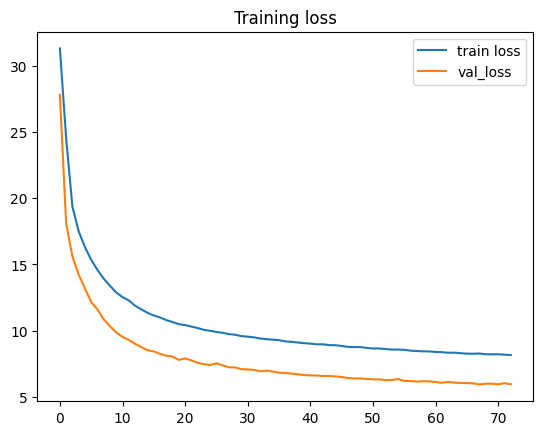

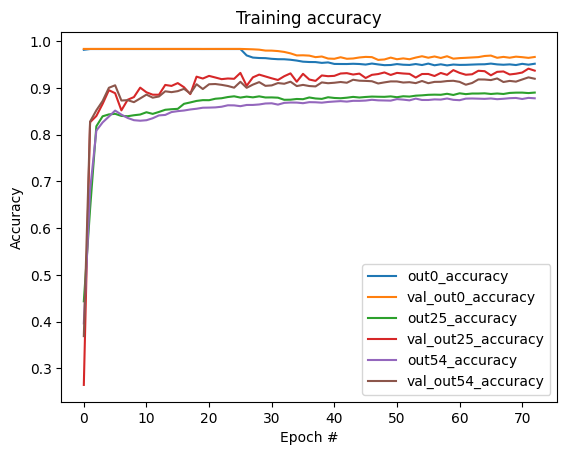

In [18]:
# Show loss curves
plt.figure()
plt.title('Training loss')
plt.plot(hist.epoch, hist.history['loss'], label='train loss')
plt.plot(hist.epoch, hist.history['val_loss'], label='val_loss')
plt.legend()
plt.savefig(save_folder + '/%s Training loss.pdf' %(name), format='pdf')
# plt.show()

plt.figure()
plt.title('Training accuracy')
plt.xlabel("Epoch #")
plt.ylabel("Accuracy")
lossNames = ['out0_accuracy', 'out25_accuracy', 'out54_accuracy']
for (i, l) in enumerate(lossNames):
	# plot the loss for both the training and validation data
	title = "Loss for {}".format(l) if l != "loss" else "Total loss"
	plt.plot(hist.epoch, hist.history[l], label=l)
	plt.plot(hist.epoch, hist.history["val_" + l],
		label="val_" + l)
	plt.legend()
plt.savefig(save_folder + '/%s Training acc.pdf' %(name), format='pdf')
plt.show()


In [19]:
evalDict = model.evaluate(data_test,[labels_test[:,iter,:] for iter in range(channel_width)])

1817/1817 [==============================] - 38s 21ms/step - loss: 5.8974 - out0_loss: 0.0600 - out1_loss: 0.0475 - out2_loss: 0.0657 - out3_loss: 0.0586 - out4_loss: 0.0684 - out5_loss: 0.0548 - out6_loss: 0.0844 - out7_loss: 0.0573 - out8_loss: 0.0776 - out9_loss: 0.0650 - out10_loss: 0.0796 - out11_loss: 0.0654 - out12_loss: 0.0853 - out13_loss: 0.0751 - out14_loss: 0.0860 - out15_loss: 0.0732 - out16_loss: 0.1006 - out17_loss: 0.0710 - out18_loss: 0.0987 - out19_loss: 0.0735 - out20_loss: 0.0928 - out21_loss: 0.0715 - out22_loss: 0.0929 - out23_loss: 0.0787 - out24_loss: 0.0952 - out25_loss: 0.0802 - out26_loss: 0.1027 - out27_loss: 0.0739 - out28_loss: 0.0938 - out29_loss: 0.0831 - out30_loss: 0.0927 - out31_loss: 0.0781 - out32_loss: 0.0979 - out33_loss: 0.0863 - out34_loss: 0.1016 - out35_loss: 0.0848 - out36_loss: 0.1137 - out37_loss: 0.0794 - out38_loss: 0.0957 - out39_loss: 0.0815 - out40_loss: 0.0970 - out41_loss: 0.0781 - out42_loss: 0.0933 - out43_loss: 0.0841 - out44_loss

In [20]:
totalA = 0
for i in range(total_channels+1,total_channels+1+total_channels):
    totalA += evalDict[i]

totalA /= total_channels
print(totalA)

0.9375277063514613


In [21]:
# Saving dict of history and evaluation result
with open(save_folder + '/' + 'histDict', 'wb') as file_pi:
    pickle.dump(hist.history, file_pi)

with open(save_folder + '/' + 'evalDict' + str(totalA), 'wb') as file_pi:
    pickle.dump(evalDict, file_pi)

In [22]:
#uncomment to save model
model.save(save_folder + '/' + name + '_Model')

2023-05-19 11:04:07.115177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04:07.120772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04:07.126319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04

2023-05-19 11:04:07.320521: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04:07.326233: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04:07.331910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04

2023-05-19 11:04:07.522445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04:07.528708: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04:07.534320: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04

2023-05-19 11:04:08.239604: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6]
	 [[{{node inputs}}]]
2023-05-19 11:04:08.245165: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6]
	 [[{{node inputs}}]]
2023-05-19 11:04:08.250401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6]
	 [[{{node inputs}}]]
2023-05-19 11:04:08.25

2023-05-19 11:04:08.446205: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6]
	 [[{{node inputs}}]]
2023-05-19 11:04:11.410857: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04:11.422816: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04:1

2023-05-19 11:04:11.826074: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04:11.837930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04:11.849408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04

2023-05-19 11:04:12.242550: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04:12.255228: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04:12.267594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,192]
	 [[{{node inputs}}]]
2023-05-19 11:04

2023-05-19 11:04:13.094271: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6]
	 [[{{node inputs}}]]
2023-05-19 11:04:13.106211: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6]
	 [[{{node inputs}}]]
2023-05-19 11:04:13.117727: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6]
	 [[{{node inputs}}]]
2023-05-19 11:04:13.12

2023-05-19 11:04:13.507843: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6]
	 [[{{node inputs}}]]
2023-05-19 11:04:13.520044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6]
	 [[{{node inputs}}]]
2023-05-19 11:04:13.531910: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype float and shape [?,6]
	 [[{{node inputs}}]]
2023-05-19 11:04:13.54

INFO:tensorflow:Assets written to: singleScan_Test_lesscrazy_W/Test_weighted_Model/assets


INFO:tensorflow:Assets written to: singleScan_Test_lesscrazy_W/Test_weighted_Model/assets


In [23]:
#Test on test data
true_test_labels = np.argmax(labels_test, axis=-1)
test_predictions = model.predict(data_test)
test_result = np.argmax(test_predictions, axis=-1).T

1817/1817 [==============================] - 11s 6ms/step


In [24]:
#classification report
class_names = ['Empty channel', 'Wi-Fi', 'Bluetooth']
class_report = classification_report(true_test_labels.flatten(), test_result.flatten(),target_names=class_names)
print(class_report)

with open(save_folder + '/' + 'classReportString', 'wb') as file_pi:
    pickle.dump(class_report, file_pi)

               precision    recall  f1-score   support

Empty channel       0.99      0.94      0.96   3658230
        Wi-Fi       0.87      0.95      0.91    831920
    Bluetooth       0.42      0.81      0.55    102910

     accuracy                           0.94   4593060
    macro avg       0.76      0.90      0.81   4593060
 weighted avg       0.95      0.94      0.94   4593060



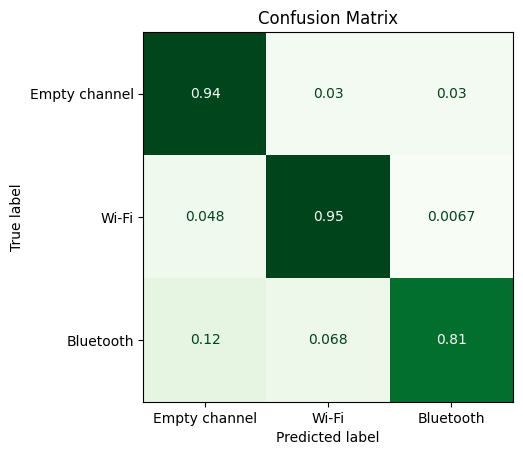

In [25]:
#Confusion matric plot
ConfusionMatrixDisplay.from_predictions(true_test_labels.flatten(), test_result.flatten(),normalize='true',cmap='Greens',colorbar=False,display_labels=class_names)
plt.title('Confusion Matrix')
plt.savefig(save_folder +'/confusion_matrix_'+ name +'.pdf', format='pdf')

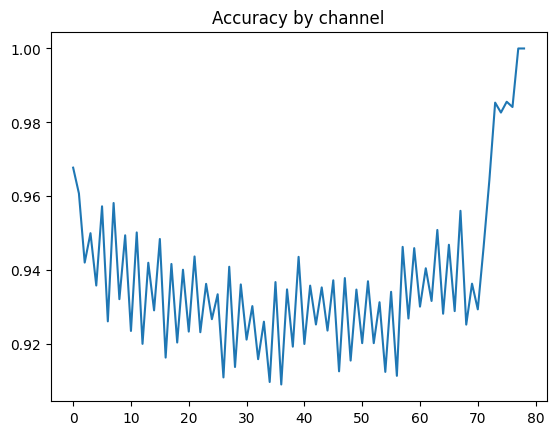

In [26]:
#%matplotlib inline

#accuracy for each channel
plt.plot(evalDict[total_channels+1:total_channels+1+total_channels])
plt.title('Accuracy by channel')
plt.savefig(save_folder +'/acc_by_channel_'+ name +'.pdf', format='pdf')

In [27]:
class_reportDict = classification_report(true_test_labels.flatten(), test_result.flatten(),output_dict=True, target_names=class_names)
for key in class_reportDict:
    try:
        class_reportDict[key]['Samples'] = class_reportDict[key].pop('support')
    except Exception as e:
        print(e)
print(class_reportDict)


'float' object has no attribute 'pop'
{'Empty channel': {'precision': 0.9850645111626974, 'recall': 0.9392263471678927, 'f1-score': 0.961599478102513, 'Samples': 3658230}, 'Wi-Fi': {'precision': 0.8697100465155373, 'recall': 0.9452880084623522, 'f1-score': 0.905925464278679, 'Samples': 831920}, 'Bluetooth': {'precision': 0.4172919415469641, 'recall': 0.8144106500825965, 'f1-score': 0.5518328916396438, 'Samples': 102910}, 'accuracy': 0.9375277048416524, 'macro avg': {'precision': 0.7573554997417329, 'recall': 0.8996416685709471, 'f1-score': 0.8064526113402787, 'Samples': 4593060}, 'weighted avg': {'precision': 0.9514496310243102, 'recall': 0.9375277048416524, 'f1-score': 0.9423344554393608, 'Samples': 4593060}}


In [28]:
class_reportDict.pop('accuracy')
print(class_reportDict)

{'Empty channel': {'precision': 0.9850645111626974, 'recall': 0.9392263471678927, 'f1-score': 0.961599478102513, 'Samples': 3658230}, 'Wi-Fi': {'precision': 0.8697100465155373, 'recall': 0.9452880084623522, 'f1-score': 0.905925464278679, 'Samples': 831920}, 'Bluetooth': {'precision': 0.4172919415469641, 'recall': 0.8144106500825965, 'f1-score': 0.5518328916396438, 'Samples': 102910}, 'macro avg': {'precision': 0.7573554997417329, 'recall': 0.8996416685709471, 'f1-score': 0.8064526113402787, 'Samples': 4593060}, 'weighted avg': {'precision': 0.9514496310243102, 'recall': 0.9375277048416524, 'f1-score': 0.9423344554393608, 'Samples': 4593060}}


In [29]:
df = pd.DataFrame(class_reportDict).transpose().round(decimals=3)
dfi.export(df, save_folder + '/' +name + "_ClassReport.png", table_conversion="matplotlib")

In [30]:
from keras.utils.layer_utils import count_params

nr_params = count_params(model.trainable_weights)

cre = open(save_folder + '/' + 'Params_' + str(nr_params), 'x')